In [1]:
from utils import config, parse_midas_data, sample_utils as su, temporal_changes_utils, stats_utils, midas_db_utils, parse_patric
from collections import defaultdict
import numpy as np
from numpy.random import binomial as sample_binomial
import math
import pickle
import sys
import random
from math import log10,ceil,log,exp

import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
from matplotlib.patches import Patch

# Cohort list
cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'olm', 'hmp']

# Plot directory
plot_dir = "%s/" % (config.analysis_directory)

# Species list
good_species_list = parse_midas_data.load_pickled_good_species_list()

# Sample-subject-order maps
sys.stderr.write("Loading sample metadata...\n")
subject_sample_map = su.parse_subject_sample_map()
sample_order_map = su.parse_sample_order_map()
sample_subject_map = su.parse_sample_subject_map()
same_mi_pair_dict = su.get_same_mi_pair_dict(subject_sample_map)
sys.stderr.write("Done!\n")

# Timepoint pair types
tp_pair_names = ['MM', 'MI', 'II', 'AA']

# Cohorts
cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'hmp']
mi_cohorts = ['backhed', 'ferretti', 'yassour', 'shao']

# Samples for each cohort
samples = {cohort: su.get_sample_names(cohort) for cohort in cohorts}
hmp_samples = su.get_sample_names('hmp')
mother_samples = su.get_sample_names('mother')
infant_samples = su.get_sample_names('infant')
olm_samples = su.get_sample_names('olm')
infant_samples_no_olm = [sample for sample in infant_samples if sample not in olm_samples]
mi_samples_no_olm = [sample for sample in (mother_samples + infant_samples) if sample not in olm_samples]

# Sample-cohort map
sample_cohort_map = su.parse_sample_cohort_map()

# Sample-timepoint map
mi_sample_day_dict = su.get_mi_sample_day_dict(exclude_cohorts=['olm'])
mi_tp_sample_dict = su.get_mi_tp_sample_dict(exclude_cohorts=['olm']) # no binning
mi_tp_sample_dict_binned, mi_tp_binned_labels = su.get_mi_tp_sample_dict(exclude_cohorts=['olm'], binned=True)

Loading sample metadata...
Done!


In [2]:
subjects_count = {'mother': set(), 'infant': set(), 'adult': set()}
cohorts_count = defaultdict(set)
cohorts_mother_count = defaultdict(set)
samples_count = {'mother': 0, 'infant': 0, 'adult': 0}
samples_cohort_count = defaultdict(int)
for sample in sample_subject_map:
    subject = sample_subject_map[sample]
    if sample in mother_samples:
        x = 'mother'
        cohort = sample_cohort_map[sample]
        cohorts_mother_count[cohort].add(subject)
        samples_cohort_count[cohort] += 1
    elif sample in infant_samples_no_olm:
        x = 'infant'
        cohort = sample_cohort_map[sample]
        cohorts_count[cohort].add(subject)
        samples_cohort_count[cohort] += 1
    elif sample in hmp_samples:
        x = 'adult'
    else:
        continue
    subjects_count[x].add(subject)
    samples_count[x] += 1

In [3]:
num_tps = defaultdict(list)
subject_sample_map = su.parse_subject_sample_map()
for subject in subject_sample_map:
    sample = subject_sample_map[subject].keys()[0]
    if sample not in infant_samples_no_olm:
        continue
    num = len(subject_sample_map[subject])
    try:
        cohort = sample_cohort_map[sample]
    except:
        continue
    num_tps[cohort].append(num)

In [4]:
num_non = 0
num_qp = 0
for species in good_species_list:
    test = su.load_qp_samples(infant_samples_no_olm, species)
    num_non += len(test['non-qp'])
    num_qp += len(test['qp'])

In [6]:
num_non_hmp = 0
num_qp_hmp = 0
for species in good_species_list:
    test = su.load_qp_samples(hmp_samples, species)
    num_non_hmp += len(test['non-qp'])
    num_qp_hmp += len(test['qp'])

KeyboardInterrupt: 

In [ ]:
print(num_non)
print(num_qp)
print(num_non_hmp)
print(num_qp_hmp)

In [7]:
# Get some basic metadata numbers for report
cohort_infant_subjects_map = {cohort: set() for cohort in mi_cohorts}
cohort_mother_subjects_map = {cohort: set() for cohort in mi_cohorts}

for sample in mi_samples_no_olm:
    subject = sample_subject_map[sample]
    cohort = sample_cohort_map[sample]
    if sample in mother_samples:
        cohort_mother_subjects_map[cohort].add(subject)
    elif sample in infant_samples:
        cohort_infant_subjects_map[cohort].add(subject)
    else:
        print("Shouldn't happen!")

for cohort in mi_cohorts:
    print("%s: %i infants, %i mothers" % (cohort, 
                                          len(cohort_infant_subjects_map[cohort]), 
                                          len(cohort_mother_subjects_map[cohort])))

print("Total infant subjects: %i" % (sum([len(cohort_infant_subjects_map[cohort]) for cohort in mi_cohorts])))
print("Total mother subjects: %i" % (sum([len(cohort_mother_subjects_map[cohort]) for cohort in mi_cohorts])))

backhed: 98 infants, 98 mothers
ferretti: 25 infants, 21 mothers
yassour: 43 infants, 43 mothers
shao: 596 infants, 175 mothers
Total infant subjects: 762
Total mother subjects: 337


In [8]:
# Set up data and custom bins for metadata overview figure

custom_bins = ['Mother', 'Birth\n(meconium)', 'Day 1', 'Day 3-4', 'Day 6', 
               'Week 1', 'Week 2', 'Week 3', 'Month 1', 'Month 2', 'Month 3', 
               'Month 4', 'Month 12', 'Month 4-14']
custom_infant_bins = custom_bins[1:]
custom_bin_defs = {'Mother': (-100, 100), 'Birth\n(meconium)': (0, 0), 'Day 1': (1, 1), 'Day 3-4': (3,4), 'Day 6': (6,6),
                  'Week 1': (7, 13), 'Week 2': (14, 20), 'Week 3': (21, 21), 'Month 1': (30, 31), 'Month 2': (60, 62),
                  'Month 3': (91, 93), 'Month 4': (122, 122), 'Month 12': (366, 366), 'Month 4-14': (124, 440)}

def get_infant_tp_bin(tp, custom_infant_bins, custom_bin_defs):
    for bin_label in custom_infant_bins:
        start, end = custom_bin_defs[bin_label]
        if tp >= start and tp <= end:
            return bin_label
    return str(tp)

timepoints_by_cohort = {cohort: [] for cohort in mi_cohorts}
subject_ids_by_cohort = {cohort: [] for cohort in mi_cohorts}
all_timepoints = set()

custom_bins_by_cohort = {cohort: [] for cohort in mi_cohorts}

i = 0
for subject in subject_sample_map:
    for sample in subject_sample_map[subject]:        
        if sample not in mi_samples_no_olm:
            continue
        cohort = sample_cohort_map[sample]
        day = mi_sample_day_dict[sample]
        
        if sample in mother_samples:
            if not (day >= 0 and day <= 7): # ignore other mom timepoints here
                continue
            custom_bin = 'Mother'
        else:
            custom_bin = get_infant_tp_bin(day, custom_infant_bins, custom_bin_defs)
        custom_bins_by_cohort[cohort].append(custom_bin)
        
        timepoints_by_cohort[cohort].append(day)
        subject_ids_by_cohort[cohort].append(i)
        
        all_timepoints.add(day)
    i += 1

# Custom tweak to Shao
custom_bins_by_cohort['shao'].remove('Month 12')

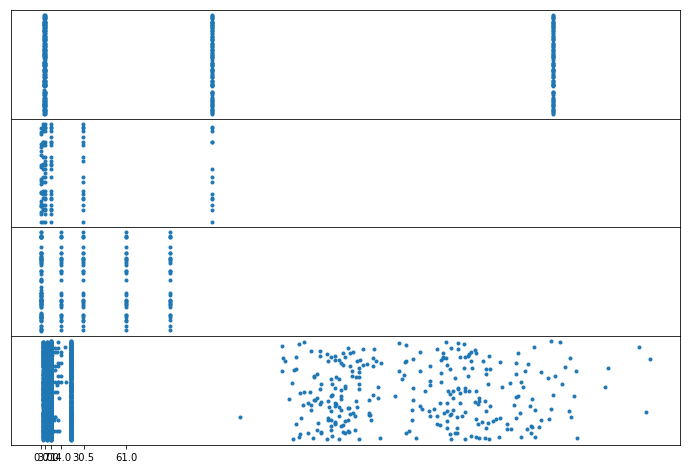

In [9]:
# Show distribution of timepoints per subject by cohorts

fig, ax = plt.subplots(4, 1, figsize=(12,8), sharex=True, gridspec_kw={'wspace':0.025, 'hspace':0})

cohort_i = 0
for cohort in mi_cohorts:
    timepoints = timepoints_by_cohort[cohort]
    subject_ids = subject_ids_by_cohort[cohort]
    ax[cohort_i].set_yticks([])
    ax[cohort_i].set_xticks([0, 3, 7, 14, 30.5, 61])
    # ax[cohort_i].set_xticklabels(['Birth\n(meconium)'])
    ax[cohort_i].plot(timepoints, subject_ids, '.')
    
    cohort_i += 1

plt.show()

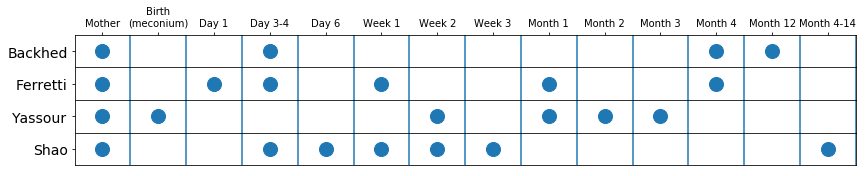

In [10]:
# Show timepoints by cohort
fig, ax = plt.subplots(4, 1, figsize=(14,2.4), gridspec_kw={'wspace':0.025, 'hspace':0})

mi_cohort_labels = []

cohort_i = 0
for cohort in mi_cohorts:
    custom_bin_idxs = []
    for custom_bin in set(custom_bins_by_cohort[cohort]):
        custom_bin_idxs.append(custom_bins.index(custom_bin))
    ax[cohort_i].set_xlim((-0.5, len(custom_bins)-0.5))
    ax[cohort_i].plot(custom_bin_idxs, [cohort_i]*len(custom_bin_idxs), 'o', markersize=14)    
    ax[cohort_i].set_yticks([cohort_i])
    ax[cohort_i].set_yticklabels([cohort.capitalize()], fontsize=14)
    ax[cohort_i].set_xticks([])
    for x in np.arange(0.5, len(custom_bins), step=1):
        ax[cohort_i].axvline(x=x)
    cohort_i += 1

ax[0].set_xticks(np.arange(len(custom_bins)))
ax[0].set_xticklabels(custom_bins)
ax[0].xaxis.tick_top()

plt.tick_params(top=False)
fig.savefig('%s/cohort_timepoints_v1.pdf' % (config.analysis_directory),bbox_inches='tight')
plt.show()

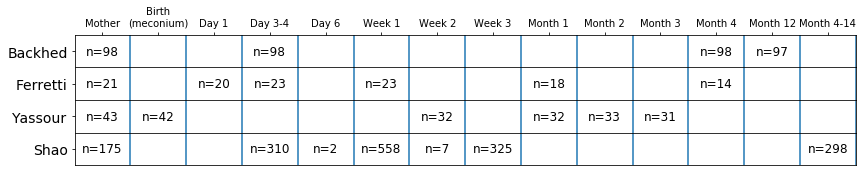

In [45]:
# Alternate: include numbers of samples per timepoint-cohort pair
fig, ax = plt.subplots(4, 1, figsize=(14,2.4), gridspec_kw={'wspace':0.025, 'hspace':0})

mi_cohort_labels = []
for cohort in mi_cohorts:
    mi_cohort_labels.append('%s\n%i subjects')

cohort_i = 0
for cohort in mi_cohorts:
    custom_bin_idxs = []
    for custom_bin in set(custom_bins_by_cohort[cohort]):
        custom_bin_idxs.append(custom_bins.index(custom_bin))
    ax[cohort_i].set_xlim((-0.5, len(custom_bins)-0.5))
    for custom_bin_idx in custom_bin_idxs:
        custom_bin = custom_bins[custom_bin_idx]        
        ax[cohort_i].text(custom_bin_idx, 0.5, 'n=%i' % (custom_bins_by_cohort[cohort].count(custom_bin)), 
                          ha='center', va='center', fontsize=12)
    ax[cohort_i].set_yticks([0.5])
    ax[cohort_i].set_yticklabels([cohort.capitalize()], fontsize=14)
    ax[cohort_i].set_xticks([])
    for x in np.arange(0.5, len(custom_bins), step=1):
        ax[cohort_i].axvline(x=x)
    cohort_i += 1

ax[0].set_xticks(np.arange(len(custom_bins)))
ax[0].set_xticklabels(custom_bins)
ax[0].xaxis.tick_top()

plt.tick_params(top=False)
fig.savefig('%s/cohort_timepoints_v2.pdf' % (config.analysis_directory),bbox_inches='tight')
plt.show()

In [5]:
# ======================================================================
# Load pickled data
# ======================================================================

# Parameters
sweep_type = 'full' # assume full for now
pp_prev_cohort = 'all'
min_coverage = 0

ddir = config.data_directory
pdir = "%s/pickles/cov%i_prev_%s/" % (ddir, min_coverage, pp_prev_cohort)

snp_changes = pickle.load(open('%s/big_snp_changes_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_changes = pickle.load(open('%s/big_gene_changes_%s.pkl' % (pdir, sweep_type), 'rb'))
snp_change_freqs = pickle.load(open('%s/snp_change_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
snp_change_null_freqs = pickle.load(open('%s/snp_change_null_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_gain_freqs = pickle.load(open('%s/gene_gain_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_loss_freqs = pickle.load(open('%s/gene_loss_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_loss_null_freqs = pickle.load(open('%s/gene_loss_null_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
between_snp_change_counts = pickle.load(open('%s/between_snp_change_counts_%s.pkl' % (pdir, sweep_type), 'rb'))
between_gene_change_counts = pickle.load(open('%s/between_gene_change_counts_%s.pkl' % (pdir, sweep_type), 'rb'))

In [6]:
# nonconsecutive
pdir = "%s/pickles/cov%i_prev_%s/nonconsecutive/" % (ddir, min_coverage, pp_prev_cohort)

dnds_info = pickle.load(open('%s/dnds_info.pkl' % (pdir), 'rb'))
snp_change_freqs_with_opps = pickle.load(open('%s/snp_change_freqs_with_opps_full.pkl' % (pdir), 'rb'))

In [7]:
# seeding analysis pickles
pdir = "%s/pickles/seeding" % (ddir)
species_allele_counts_map = {}
for species in snp_changes.keys():
    fpath = "%s/allele_counts_map_%s.pkl" % (pdir, species)
    species_allele_counts_map[species] = pickle.load(open(fpath, 'rb'))

In [8]:
# ======================================================================
# Load pickled data
# ======================================================================

# Parameters
sweep_type = 'full' # assume full for now
pp_prev_cohort = 'hmp'
min_coverage = 0

ddir = config.data_directory
pdir = "%s/pickles/cov%i_prev_%s/" % (ddir, min_coverage, pp_prev_cohort)

gene_gain_freqs_prev_hmp = pickle.load(open('%s/gene_gain_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_loss_freqs_prev_hmp = pickle.load(open('%s/gene_loss_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_loss_null_freqs_prev_hmp = pickle.load(open('%s/gene_loss_null_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))

In [9]:
hmp = 0
other = 0
for species in gene_changes:
    for sample_i, sample_j in gene_changes[species]:
        if sample_i in hmp_samples:
            hmp += 1
        else:
            other += 1

In [10]:
len(gene_changes)

217

In [12]:
# Calculate number of days for a timpeoint pair

mi_sample_day_dict = su.get_mi_sample_day_dict()

def sample_pair_to_days(sample1, sample2):
    days = mi_sample_day_dict[sample2] - mi_sample_day_dict[sample1]
    if days < 0:
        return np.abs(days)
    return days

def tp_pair_to_days(tp_pair):
    tpa, tpb = tp_pair
    o1 = float(tpa[1:])
    o2 = float(tpb[1:])
    return np.abs(o1-o2)

# Rough approximation of HMP time intervals
def adult_tp_pair_to_days(tp_pair):
    tpa, tpb = tp_pair
    return np.abs(int(tpa[-1:]) - int(tpb[-1:]))*183

def tp_pair_to_tp_type(tp_pair):
    tpa, tpb = tp_pair
    tp_type = tpa[0] + tpb[0]
    if tp_type == 'IM':
        tp_type = 'MI'
    return tp_type

In [13]:
# Settings for prevalence plots

modification_difference_threshold = config.modification_difference_threshold
replacement_difference_threshold = config.replacement_difference_threshold
default_num_bootstraps = 10000
min_sample_size = 3
min_haploid_sample_size = 10

variant_types = ['1D','4D']
within_host_type = 'consecutive' # consecutive timepoints (vs. longest)

num_bootstraps = 10 # for gene change prevalence null

# For partitioning SNVs according to prevalence
derived_freq_bins = np.array([-1,0,0.01,0.1,0.5,0.9,0.99,1,2])
derived_virtual_freqs = np.arange(0,len(derived_freq_bins)-1)
derived_virtual_xticks = list(derived_virtual_freqs[:-1]+0.5)
derived_virtual_xticklabels = ['0','.01','.1','.5','.9','.99','1']

# For partitioning genes into different prevalence classes
gene_freq_bins = np.array([-1,0.1,0.5,0.9,2])
gene_freq_xticks = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
gene_freq_xticklabels = ['0','0.1','0.5', '0.9','1','0.9','0.5', '0.1','0']
gene_gain_virtual_freqs = np.array([3.5,2.5,1.5,0.5])
gene_loss_virtual_freqs = np.array([-3.5,-2.5,-1.5,-0.5])

# Function
def get_f_idx(f):
    return ((f>derived_freq_bins[:-1])*
            (f<=derived_freq_bins[1:])).argmax()

In [14]:
# Define function needed for survival curve plots

def calculate_unnormalized_survival_from_vector(counts):
    counts = sorted(counts)
    xs = []
    ns = []
    ns_cur = len(counts)
    min = -1
    for count in counts:
        if count > min:
            ns.append(ns_cur) # Number of elements greater or equal
            xs.append(count)
            min = count
        ns_cur -= 1
    xs.append(xs[len(xs)-1]+1)
    ns.append(0)
    return xs, np.array(ns)

In [15]:
# Custom sample pair cohorts [not just sample!]

def custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j):
    for cohort in custom_cohort_tests:
        if custom_cohort_tests[cohort](sample_i, sample_j):
            return cohort

custom_cohort_tests = {}
custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples_no_olm)
# custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples_no_olm) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['Day 0-Week 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7))
custom_cohort_tests['Week 1-Month 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 7 and mi_sample_day_dict[sample_j] <= 31))
custom_cohort_tests['Month 1-Year 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 31 and mi_sample_day_dict[sample_j] <= 400))
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)

# Make pooled snp change distributions from snp_changes

pooled_snp_change_distribution = defaultdict(list)
pooled_between_snp_change_distribution = defaultdict(list)

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:
        # if sample_i in mother_samples and sample_j in infant_samples:
            # print("%i > %i" % (mi_sample_day_dict[sample_i], mi_sample_day_dict[sample_j]))
        # if sample_j in mother_samples and sample_i in infant_samples:
            # print("%i < %i" % (mi_sample_day_dict[sample_i], mi_sample_day_dict[sample_j]))
        
        val = snp_changes[species][(sample_i, sample_j)]
        num_snp_changes = val if (type(val) == type(1)) else len(val)
        custom_cohort = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        pooled_snp_change_distribution[custom_cohort].append(num_snp_changes)
        
        num_snp_changes_between = between_snp_change_counts[species][(sample_i, sample_j)]
        if sample_i in hmp_samples and sample_j in hmp_samples:
            pooled_between_snp_change_distribution['AA'].append(num_snp_changes_between)
        else:
            pooled_between_snp_change_distribution['MI'].append(num_snp_changes_between)

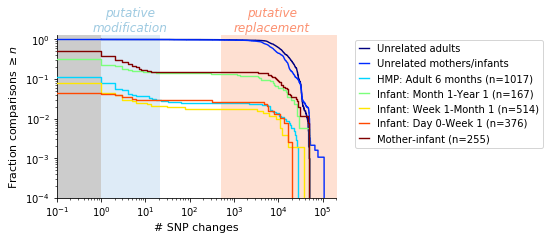

In [10]:
fig_snp, ax_snp = plt.subplots(figsize=(5,3))

colormap = cmx.get_cmap('jet', 7)
colors = [colormap(x) for x in np.array([x for x in range(0,7)])/7.0]

modification_difference_threshold = config.modification_difference_threshold
replacement_difference_threshold = config.replacement_difference_threshold

# Plot SNP change distribution

ax_snp.set_xscale('log')
ax_snp.set_yscale('log')
ax_snp.set_ylabel('Fraction comparisons $\geq n$', fontsize=11)
ax_snp.set_xlabel('# SNP changes', fontsize=11)

ax_snp.spines['top'].set_visible(False)
ax_snp.spines['right'].set_visible(False)
ax_snp.get_xaxis().tick_bottom()
ax_snp.get_yaxis().tick_left()

color_i = 0

ymin, ymax = 0.0001, 1.3
ax_snp.set_ylim([ymin,ymax])
xmin, xmax = 1e-01, 2e05
ax_snp.set_xlim([xmin, xmax])

# Now fill in the graphics

ax_snp.fill_between([xmin,1], [ymin,ymin],[ymax,ymax],color='0.8',zorder=1)
ax_snp.fill_between([1,modification_difference_threshold],[ymin,ymin],[ymax,ymax],color='#deebf7',zorder=1)
ax_snp.fill_between([replacement_difference_threshold,xmax],[ymin,ymin],[ymax,ymax],color='#fee0d2',zorder=1)

ax_snp.text( exp((log(1e05)+log(replacement_difference_threshold))/2), ymax*1.2, 'putative\nreplacement',fontsize=12,fontstyle='italic',ha='center',color='#fc9272',zorder=1)
ax_snp.text( exp((log(1)+log(modification_difference_threshold))/2), ymax*1.2, 'putative\nmodification',fontsize=12,fontstyle='italic',ha='center',color='#9ecae1',zorder=1)

# Unrelated adults
counts = pooled_between_snp_change_distribution['AA']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label="Unrelated adults", where='pre',zorder=4)
color_i += 1

# Unrelated mother/infant
counts = pooled_between_snp_change_distribution['MI']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label="Unrelated mothers/infants", where='pre',zorder=4)
color_i += 1

# Save
# ax_snp.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=10, numpoints=1, ncol=1, handlelength=1)
# fig_snp.savefig('%s/temporal_snp_changes_%s_pooled_a1.png' % (config.analysis_directory, sweep_type),bbox_inches='tight',dpi=600)

# Within-host, adult
counts = pooled_snp_change_distribution['AA']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = 'HMP: Adult 6 months' + (' (n=%d)' % ns[0])
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Save
# ax_snp.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=10, numpoints=1, ncol=1, handlelength=1)
# fig_snp.savefig('%s/temporal_snp_changes_%s_pooled_a2.png' % (config.analysis_directory, sweep_type),bbox_inches='tight',dpi=600)

# Within-host, infant-infant
for infant_custom_cohort in ['Month 1-Year 1', 'Week 1-Month 1', 'Day 0-Week 1']:
    counts = pooled_snp_change_distribution[infant_custom_cohort]
    xs, ns = calculate_unnormalized_survival_from_vector(counts)
    mlabel = ("Infant: %s" % (infant_custom_cohort)) + (' (n=%d)' % ns[0])
    ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
    color_i += 1

# Save
# ax_snp.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=10, numpoints=1, ncol=1, handlelength=1)
# fig_snp.savefig('%s/temporal_snp_changes_%s_pooled_a3.png' % (config.analysis_directory, sweep_type),bbox_inches='tight',dpi=600)

# Within-host, mother-infant
counts = pooled_snp_change_distribution['MI']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = "Mother-infant" + (' (n=%d)' % ns[0])
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Save
ax_snp.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=10, numpoints=1, ncol=1, handlelength=1)
fig_snp.savefig('%s/temporal_snp_changes_%s_pooled_a4.pdf' % (config.analysis_directory, sweep_type),bbox_inches='tight',dpi=600)
plt.show()

In [11]:
# Represent this in tabular form

event_types = ['no change', 'modification', 'replacement']
custom_cohorts_ordered = ['MI', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'MM', 'AA']

def num_snp_changes_to_event_type(n):
    if n == 0:
        return 'no change'
    elif n <= modification_difference_threshold:
        return 'modification'
    elif n >= replacement_difference_threshold:
        return 'replacement'
    else:
        return 'oof'

# Number of QP pairs by cohort and event type
cohort_event_type_dict = {cohort: defaultdict(int) for cohort in pooled_snp_change_distribution.keys()}
# Number of SNP changes by cohort and event type (TODO: awful naming)
cohort_event_type_dict2 = {cohort: defaultdict(int) for cohort in pooled_snp_change_distribution.keys()}

for custom_cohort in pooled_snp_change_distribution:
    for num_snp_changes in pooled_snp_change_distribution[custom_cohort]:
        event_type = num_snp_changes_to_event_type(num_snp_changes)        
        cohort_event_type_dict[custom_cohort][event_type] += 1
        cohort_event_type_dict2[custom_cohort][event_type] += num_snp_changes

print('\t'.join(['\t'] + custom_cohorts_ordered))
for event_type in event_types:
    vals = '\t\t'.join([str(cohort_event_type_dict[custom_cohort][event_type]) for custom_cohort in custom_cohorts_ordered])
    print(event_type + '\t' + vals)

		MI	Day 0-Week 1	Week 1-Month 1	Month 1-Year 1	MM	AA
no change	122		359		474		114		61		905
modification	94		6		29		29		10		82
replacement	38		10		9		22		3		25


In [13]:
# Try to understand SNP change distribution of infants in greater detail...

timeline_data = defaultdict(dict)

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:
        
        if sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm:
            val = snp_changes[species][(sample_i, sample_j)]
            num_snp_changes = val if (type(val) == type(1)) else len(val)
            day1 = mi_sample_day_dict[sample_i]
            day2 = mi_sample_day_dict[sample_j]
            init_day = day1
            day_length = day2-day1
            val = snp_changes[species][(sample_i, sample_j)]
            num_snp_changes = val if (type(val) == type(1)) else len(val)
            try:
                timeline_data[init_day][day_length].append(num_snp_changes)
            except:
                timeline_data[init_day][day_length] = []
                timeline_data[init_day][day_length].append(num_snp_changes)

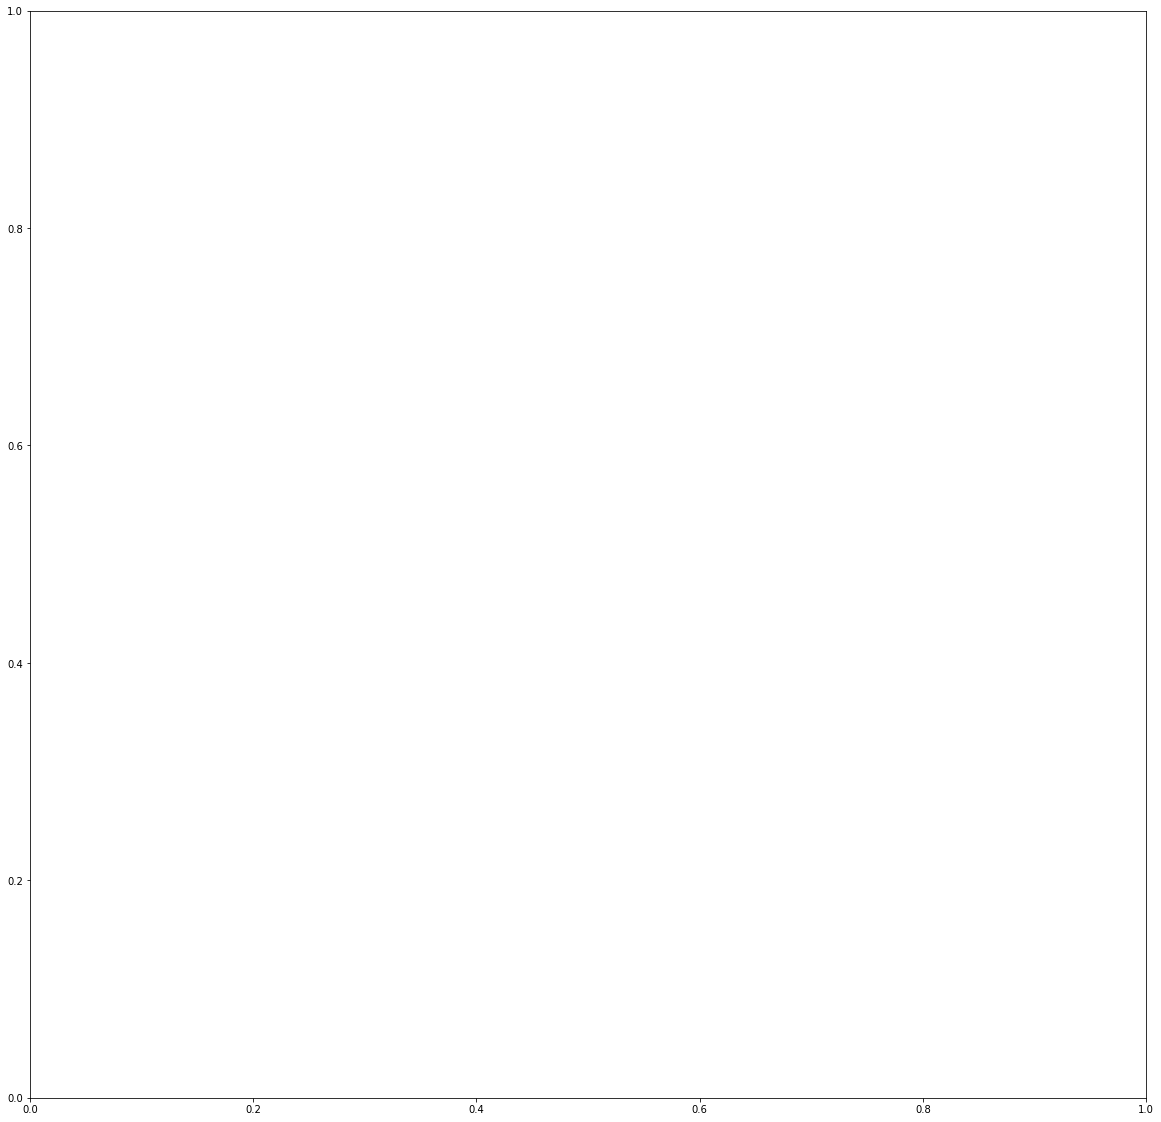

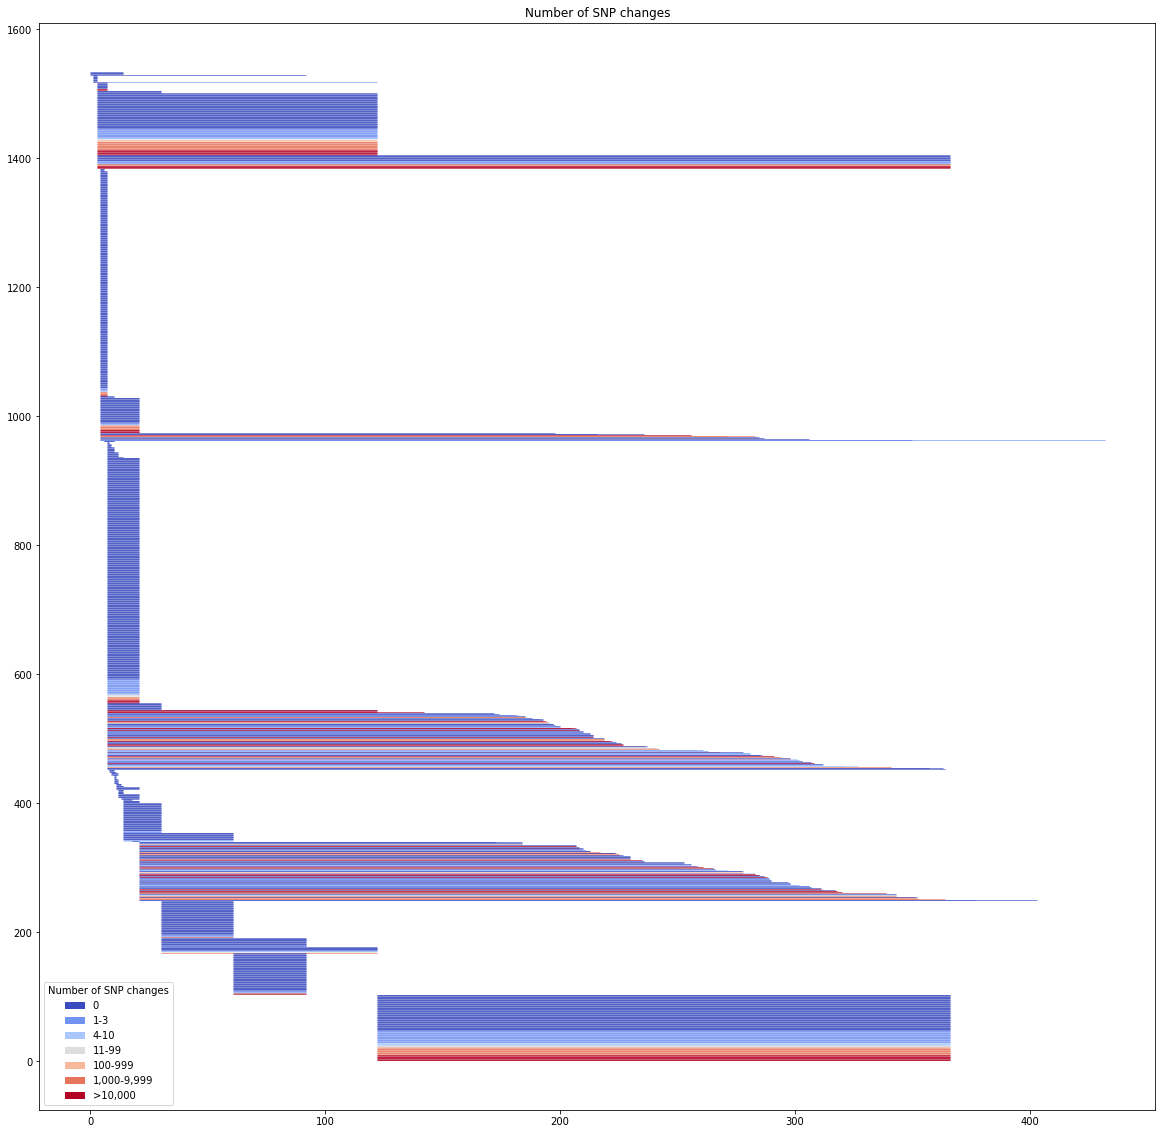

In [14]:
# Through timeline visualization!
# x-axis: days
# y-axis: sample pairs
# color: # SNP changes
from matplotlib.patches import Patch

colormap = cmx.get_cmap('coolwarm', 7)
colors = [colormap(x) for x in np.array([x for x in range(0,7)])/7.0]

bins = [(0,0),(1,3),(4,10),(11,99),(100,999),(1000,9999),(10000,9999999)]
bin_to_color = {bins[i]: colors[i] for i in range(len(bins))}
binlabels = ['0', '1-3', '4-10', '11-99', '100-999', '1,000-9,999', '>10,000']

fig, ax = plt.subplots(figsize=(20,20))

i = 1534
for init_day in sorted(timeline_data.keys()):
    for day_length in sorted(timeline_data[init_day].keys()):
        for num_snp_changes in sorted(timeline_data[init_day][day_length]):
            # Get bin of number SNP changes
            for j in range(len(bins)):
                lower, upper = bins[j]
                if num_snp_changes >= lower and num_snp_changes <= upper:
                    color = colors[j]
                    label = binlabels[j]
            lines = ax.hlines(i, init_day, init_day+day_length, color=color)
            lines.set_linewidth(0.01*64)
            i -= 1


legend_elements = [Patch(facecolor=colors[k], label=binlabels[k]) for k in range(len(bins))]
ax.legend(handles=legend_elements, loc='lower left', title='Number of SNP changes', frameon=True)
ax.set_title("Number of SNP changes")
fig.savefig('%s/snp_changes_timeline_infant.pdf' % (config.analysis_directory),bbox_inches='tight')
plt.show()

In [58]:
# Plot SNP change distribution with all infant-infant QP pairs combined

custom_cohort_tests = {}
# custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples_no_olm)
custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples_no_olm) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['II-1mon'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (sample_pair_to_days(sample_i, sample_j) <= 32))
custom_cohort_tests['II-1yr'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (sample_pair_to_days(sample_i, sample_j) > 90))
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)

pooled_snp_change_distribution = defaultdict(list)
pooled_between_snp_change_distribution = defaultdict(list)

time_length_dist = []

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:        
        val = snp_changes[species][(sample_i, sample_j)]
        num_snp_changes = val if (type(val) == type(1)) else len(val)
        custom_cohort = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        if custom_cohort == 'II-1yr':
            time_length_dist.append(sample_pair_to_days(sample_i, sample_j))
        pooled_snp_change_distribution[custom_cohort].append(num_snp_changes)
        
        num_snp_changes_between = between_snp_change_counts[species][(sample_i, sample_j)]
        if sample_i in hmp_samples and sample_j in hmp_samples:
            pooled_between_snp_change_distribution['AA'].append(num_snp_changes_between)
        else:
            pooled_between_snp_change_distribution['MI'].append(num_snp_changes_between)

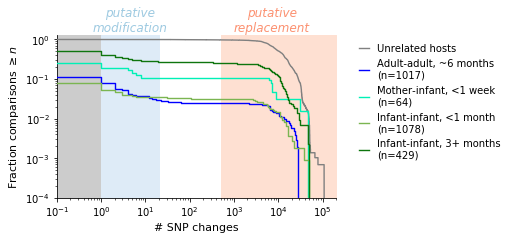

In [59]:
fig_snp, ax_snp = plt.subplots(figsize=(5,3))

colormap = cmx.get_cmap('viridis', 8)
colors = [colormap(x) for x in np.array([x for x in range(0,8)])/8.0]
colors = ['gray', 'blue', '#00f0b6', '#7bb551', '#0e750e']

modification_difference_threshold = config.modification_difference_threshold
replacement_difference_threshold = config.replacement_difference_threshold

ax_snp.set_xscale('log')
ax_snp.set_yscale('log')
ax_snp.set_ylabel('Fraction comparisons $\geq n$', fontsize=11)
ax_snp.set_xlabel('# SNP changes', fontsize=11)

ax_snp.spines['top'].set_visible(False)
ax_snp.spines['right'].set_visible(False)
ax_snp.get_xaxis().tick_bottom()
ax_snp.get_yaxis().tick_left()

color_i = 0

ymin, ymax = 0.0001, 1.3
ax_snp.set_ylim([ymin,ymax])
xmin, xmax = 1e-01, 2e05
ax_snp.set_xlim([xmin, xmax])

# Now fill in the graphics

ax_snp.fill_between([xmin,1], [ymin,ymin],[ymax,ymax],color='0.8',zorder=1)
ax_snp.fill_between([1,modification_difference_threshold],[ymin,ymin],[ymax,ymax],color='#deebf7',zorder=1)
ax_snp.fill_between([replacement_difference_threshold,xmax],[ymin,ymin],[ymax,ymax],color='#fee0d2',zorder=1)

ax_snp.text( exp((log(1e05)+log(replacement_difference_threshold))/2), ymax*1.2, 'putative\nreplacement',fontsize=12,fontstyle='italic',ha='center',color='#fc9272',zorder=1)
ax_snp.text( exp((log(1)+log(modification_difference_threshold))/2), ymax*1.2, 'putative\nmodification',fontsize=12,fontstyle='italic',ha='center',color='#9ecae1',zorder=1)
'''
# Unrelated adults
counts = pooled_between_snp_change_distribution['AA']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label="Unrelated adults", where='pre',zorder=4)
color_i += 1

# Unrelated mother/infant
counts = pooled_between_snp_change_distribution['MI']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label="Unrelated mothers/infants", where='pre',zorder=4)
color_i += 1

# Save
ax_snp.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=10, numpoints=1, ncol=1, handlelength=1)
fig_snp.savefig('%s/temporal_snp_changes_%s_pooled_infant_combined_a1.png' % (config.analysis_directory, sweep_type),bbox_inches='tight',dpi=600)
'''

# Unrelated hosts (adults OR mother/infant)
counts = pooled_between_snp_change_distribution['AA'] + pooled_between_snp_change_distribution['MI']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label="Unrelated hosts", where='pre',zorder=4)
color_i += 1

# Within-host, adult
counts = pooled_snp_change_distribution['AA']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = 'Adult-adult, ~6 months' + ('\n(n=%d)' % ns[0])
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Within-host, mother-infant
counts = pooled_snp_change_distribution['MI']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = "Mother-infant, <1 week" + ('\n(n=%d)' % ns[0])
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Within-host, infant-infant
for infant_custom_cohort, infant_custom_label in zip(['II-1mon', 'II-1yr'], ['Infant-infant, <1 month', 'Infant-infant, 3+ months']):
    counts = pooled_snp_change_distribution[infant_custom_cohort]
    xs, ns = calculate_unnormalized_survival_from_vector(counts)
    mlabel = ('%s\n(n=%d)' % (infant_custom_label, ns[0]))
    ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
    color_i += 1

# Save
ax_snp.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=10, numpoints=1, ncol=1, handlelength=1, frameon=False)
fig_snp.savefig('%s/temporal_snp_changes_%s_pooled_infant_combined_v2.pdf' % (config.analysis_directory, sweep_type),bbox_inches='tight',dpi=600)
plt.show()

In [60]:
# Also get numeric sense of II, II-short and II-long distributions
cohort_event_type_dict = {cohort: defaultdict(int) for cohort in pooled_snp_change_distribution.keys()}
custom_cohorts_ordered = ['II-1mon', 'II-1yr', 'II']

# Stash in II numbers
pooled_snp_change_distribution['II'] = []
for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:        
        val = snp_changes[species][(sample_i, sample_j)]
        num_snp_changes = val if (type(val) == type(1)) else len(val)
        if sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm:
            pooled_snp_change_distribution['II'].append(num_snp_changes)

for custom_cohort in custom_cohorts_ordered:
    for num_snp_changes in pooled_snp_change_distribution[custom_cohort]:
        event_type = num_snp_changes_to_event_type(num_snp_changes)        
        cohort_event_type_dict[custom_cohort][event_type] += 1

print('\t'.join(['\t'] + custom_cohorts_ordered))
for event_type in event_types:
    vals = '\t\t'.join([str(cohort_event_type_dict[custom_cohort][event_type]) for custom_cohort in custom_cohorts_ordered])
    print(event_type + '\t' + vals)


KeyError: 'II'

In [ ]:
# One more visualization of distribution of # SNP differences for groups of QP pairs

# Plot SNP change distribution with all infant-infant QP pairs combined

pooled_snp_change_distribution = defaultdict(list)

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:        
        
        val = snp_changes[species][(sample_i, sample_j)]
        num_snp_changes = val if (type(val) == type(1)) else len(val)
        
        if sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm:
            duration_days = sample_pair_to_days(sample_i, sample_j)
            duration_weeks = duration_days / 7
        pooled_snp_change_distribution[duration_weeks].append(num_snp_changes)

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))

colormap = cmx.get_cmap('coolwarm', 7)
colors = [colormap(x) for x in np.array([x for x in range(0,7)])/7.0]

bins = [(0,0),(1,3),(4,10),(11,99),(100,999),(1000,9999),(10000,9999999)]
bin_to_color = {bins[i]: colors[i] for i in range(len(bins))}
binlabels = ['0', '1-3', '4-10', '11-99', '100-999', '1,000-9,999', '>10,000']

def get_snp_bin(all_bins, num):
    for start, end in all_bins:
        if num >= start and num <= end:
            return (start, end)

weeks = sorted(pooled_snp_change_distribution.keys())

# Map each bin to proportion in each week
bin_totals = {}
bin_proportions = {snp_bin: np.zeros(len(weeks)) for snp_bin in bins}

for i in range(len(weeks)):
    week = weeks[i]
    bin_dict = {snp_bin: 0 for snp_bin in bins}
    for num_snp_changes in pooled_snp_change_distribution[week]:
        snp_bin = get_snp_bin(bins, num_snp_changes)
        bin_dict[snp_bin] += 1
    
    total = sum(bin_dict.values())
    bin_totals[week] = total
    if total < 10:
        continue
    for snp_bin in bin_dict:
        bin_proportions[snp_bin][i] = float(bin_dict[snp_bin])/total

cum_proportion = np.zeros(len(weeks))
for snp_bin in bins:
    ax.bar(weeks, bin_proportions[snp_bin], width=1, bottom=cum_proportion, color=bin_to_color[snp_bin])
    cum_proportion += bin_proportions[snp_bin]

legend_elements = [Patch(facecolor=colors[k], label=binlabels[k]) for k in range(len(bins))]
ax.legend(handles=legend_elements, loc='lower right', title='Number of SNP changes', frameon=True)
ax.set_xticks(weeks)
ax.set_xlabel('Duration in weeks, rounded down\nNote: weeks with <10 QP pairs are omitted')
ax.set_ylabel('Proportion of QP pairs')
plt.show()

In [ ]:
# Just distribution of durations
fig, ax = plt.subplots(figsize=(18,6))
ax.bar(weeks, [bin_totals[week] for week in weeks], width=1)
ax.set_xticks(weeks)
ax.set_xlabel('Duration in weeks, rounded down')
ax.set_ylabel('Number of QP pairs')
plt.show()

In [9]:
# SNP change rates: pickle II/MI/AA

count_time_tups_by_tp_type = defaultdict(list)

for species in snp_changes:
    for s1, s2 in snp_changes[species]:        
        val = snp_changes[species][(s1, s2)]
        if type(val) == type(1):
            continue # Only looking at modifications/no change
        if (s1 in olm_samples):
            continue # Ignore Olm
        
        num_sweeps = len(val)
    
        tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        
        if tp_type in ['AA']:
            days = adult_tp_pair_to_days(tp_pair)
        else:
            days = sample_pair_to_days(s1, s2)
        
        # Condition MI on comparing to infants in first week
        if tp_type == 'MI':
            if s2 in infant_samples and mi_sample_day_dict[s2] > 7:
                # print(mi_sample_day_dict[s2])
                continue
            if s1 in infant_samples and mi_sample_day_dict[s1] > 7:
                # print(mi_sample_day_dict[s1])
                continue
        
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if days == 0:
            if mi_sample_day_dict[s1] == 0:
                days = 1
            else:
                continue
        
        count_time_tups_by_tp_type[tp_type].append((num_sweeps, days))

In [10]:
# Subsample QP pairs in a category to n=50 and get #sweeps/day
# bootstrap 20 times and take average

bootstrapped_rates_by_tp_type = defaultdict(list)
bootstrapped_rates_by_tp_type_no_zeros = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in count_time_tups_by_tp_type:
    for _ in np.arange(num_bootstraps):
        all_tups = count_time_tups_by_tp_type[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_sweeps = 0
        total_days = 0
        total_days_no_zeros = 0
        for num_sweeps, days in bootstrap:
            total_sweeps += num_sweeps
            total_days += days
            if num_sweeps > 0:
                total_days_no_zeros += days
        bootstrapped_rates_by_tp_type[tp_type].append(float(total_sweeps)/total_days)
        # bootstrapped_rates_by_tp_type_no_zeros[tp_type].append(float(total_sweeps)/total_days_no_zeros)

In [11]:
# SNP change rate: subdivisions with infant

count_time_tups_by_infant_tp_type = defaultdict(list)
infant_tp_type_dict = {'Day 0-Week 1': (0, 7), 'Week 1-Month 1': (7,31), 'Month 1-Month 4': (31,122), 'Month 1-Year 1': (31, 367)}
infant_tp_type_cohort_comp = {tt: [] for tt in infant_tp_type_dict}

for species in snp_changes:
    for s1, s2 in snp_changes[species]:        
        val = snp_changes[species][(s1, s2)]
        if type(val) == type(1):
            continue # Only looking at modifications/no change
        if (s1 not in infant_samples_no_olm) or (s2 not in infant_samples_no_olm) or (s1 in olm_samples):
            continue # Only looking at infant-infant

        day1 = mi_sample_day_dict[s1]
        day2 = mi_sample_day_dict[s2]

        for infant_tp_type in infant_tp_type_dict:
            start, end = infant_tp_type_dict[infant_tp_type]
            if day1 >= start and day2 <= end:            
                days = day2 - day1
                break
        
        num_sweeps = len(val)
        count_time_tups_by_infant_tp_type[infant_tp_type].append((num_sweeps, days))
        infant_tp_type_cohort_comp[infant_tp_type].append(sample_cohort_map[s1])

In [12]:
bootstrapped_rates_by_infant_tp_type = defaultdict(list)
bootstrapped_rates_by_infant_tp_type_no_zeros = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in count_time_tups_by_infant_tp_type:
    for _ in np.arange(num_bootstraps):
        all_tups = count_time_tups_by_infant_tp_type[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_sweeps = 0
        total_days = 0
        total_days_no_zeros = 0
        for num_sweeps, days in bootstrap:
            total_sweeps += num_sweeps
            total_days += days
            if num_sweeps > 0:
                total_days_no_zeros += days
        bootstrapped_rates_by_infant_tp_type[tp_type].append(float(total_sweeps)/total_days)
        try:
            bootstrapped_rates_by_infant_tp_type_no_zeros[tp_type].append(float(total_sweeps)/total_days_no_zeros)
        except:
            continue

Averages:
[0.06060606060606061, 0.01834862385321101, 0.013508473873948535, 0.0037812413538688555, 0.0025278058645096056, 0.0014128695796713]


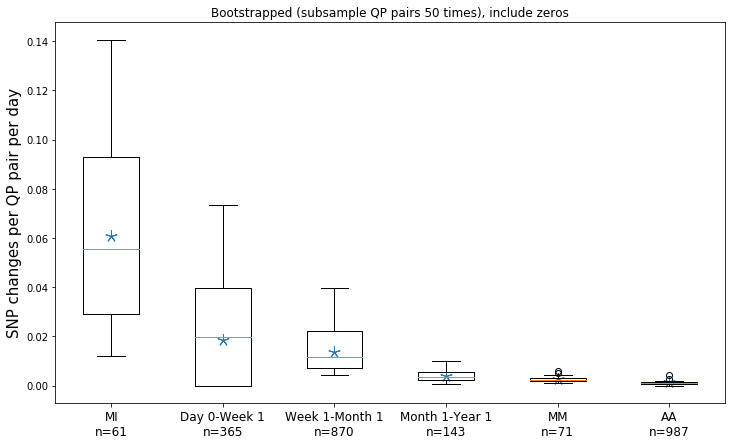

In [13]:
# SNP change rates boxplot

fig, ax = plt.subplots(figsize=(12,7))

tp_types = ['MI', 'MM', 'AA']
tp_type_labels = []
infant_tp_types = ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
infant_tp_type_labels = []

annotations = []

bootstrapped_rates_infant = [bootstrapped_rates_by_infant_tp_type[infant_tp_type] for infant_tp_type in infant_tp_types]
for infant_tp_type in infant_tp_types:
    snp_count, total_days = (0,0)
    for count, days in count_time_tups_by_infant_tp_type[infant_tp_type]:
        snp_count += count
        total_days += days
    annotations.append(float(snp_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f %%' % (snp_count, total_days, (snp_count*100.0)/total_days))
    # infant_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (infant_tp_type, len(bootstrapped_rates_by_infant_tp_type[infant_tp_type]), len(count_time_tups_by_infant_tp_type[infant_tp_type])))
    infant_tp_type_labels.append('%s\nn=%i' % (infant_tp_type, len(count_time_tups_by_infant_tp_type[infant_tp_type])))

bootstrapped_rates = [bootstrapped_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    snp_count, total_days = (0,0)
    for count, days in count_time_tups_by_tp_type[tp_type]:
        snp_count += count
        total_days += days
    annotations.append(float(snp_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f%%' % (snp_count, total_days, float(snp_count)/total_days))
    # tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, len(bootstrapped_rates_by_tp_type[tp_type]), len(count_time_tups_by_tp_type[tp_type])))
    tp_type_labels.append('%s\nn=%i' % (tp_type, len(count_time_tups_by_tp_type[tp_type])))

bootstrapped_rates_reordered = [bootstrapped_rates[0]] + bootstrapped_rates_infant + bootstrapped_rates[1:]
tp_type_labels_reordered = [tp_type_labels[0]] + infant_tp_type_labels + tp_type_labels[1:]
annotations_reordered = [annotations[3]] + annotations[0:3] + annotations[4:]

print("Averages:")
print(annotations_reordered)

i = 0
for rates in bootstrapped_rates_reordered:
    # ax.text(i+0.7, max(rates) + 0.005, annotations_reordered[i], color='red')
    i += 1

ax.plot(np.arange(1, 1+len(annotations)), annotations_reordered, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates_reordered)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(tp_type_labels_reordered, fontsize=12)
ax.set_ylabel("SNP changes per QP pair per day", fontsize=15)
ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

plt.show()

fig.savefig('%s/snp_change_rates_by_tp_type_overall_with_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

In [14]:
# Store for later use
snp_change_rates = bootstrapped_rates_reordered
snp_change_rate_annotations = annotations_reordered
snp_change_rate_tp_type_labels = tp_type_labels_reordered

Averages:
[0.014787430683918669, 0.008857395925597875, 0.0013646702047005307, 0.0008113291045876973, 0.000358337314859054, 0.00012590969756490645]


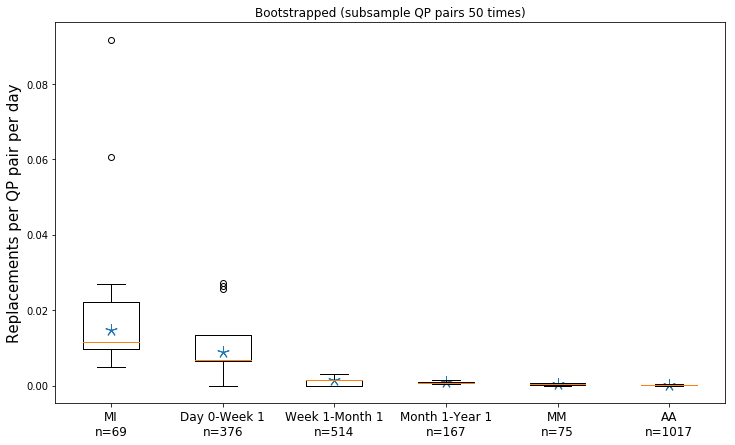

In [15]:
# Finally, get sense of how many replacements occur
# per unit time [in a host]
# HEY: reusing variable names so be careful!

# Overview of replacement info

infant_tp_type_dict = {'Day 0-Week 1': (0, 7), 'Week 1-Month 1': (7,31), 'Month 1-Month 4': (31,122), 'Month 1-Year 1': (31, 367)}
replacement_time_tups_by_infant_tp_type = defaultdict(list)
replacement_time_tups_by_tp_type = defaultdict(list)
all_time_tups_by_infant_tp_type = defaultdict(list)
all_time_tups_by_tp_type = defaultdict(list)

for species in snp_changes:
    for s1, s2 in snp_changes[species]:
        if s1 in olm_samples:
            continue
        
        tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
        tpa, tpb = tp_pair
        tp_type = tp_pair_to_tp_type(tp_pair)            
        days = adult_tp_pair_to_days(tp_pair) if tp_type in ['AA'] else sample_pair_to_days(s1, s2)
        
        # Condition MI on comparing to infants in first week
        if tp_type == 'MI':
            if s2 in infant_samples and mi_sample_day_dict[s2] > 7:
                continue
            if s1 in infant_samples and mi_sample_day_dict[s1] > 7:
                continue
        
        val = snp_changes[species][(s1, s2)]
        
        if isinstance(val, int): # replacement
            replacement_time_tups_by_tp_type[tp_type].append((1, days))
            all_time_tups_by_tp_type[tp_type].append((val, days))
        else: # not replacement
            all_time_tups_by_tp_type[tp_type].append((len(val), days))            
        
        if tp_type == 'II':
            day1, day2 = mi_sample_day_dict[s1], mi_sample_day_dict[s2]
            for infant_tp_type in infant_tp_type_dict:
                start, end = infant_tp_type_dict[infant_tp_type]
                if day1 >= start and day2 <= end:            
                    days = np.abs(day1 - day2)
                    if isinstance(val, int):
                        replacement_time_tups_by_infant_tp_type[infant_tp_type].append((1, days))
                        all_time_tups_by_infant_tp_type[infant_tp_type].append((val, days))
                    else:
                        all_time_tups_by_infant_tp_type[infant_tp_type].append((len(val), days))

bootstrapped_replacement_rates_alt_by_tp_type = defaultdict(list)
bootstrapped_replacement_rates_alt_by_infant_tp_type = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in all_time_tups_by_tp_type:
    for _ in np.arange(num_bootstraps):
        all_tups = all_time_tups_by_tp_type[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_replacements = 0
        total_days = 0
        for num_snp_changes, days in bootstrap:
            if num_snp_changes >= 500:
                total_replacements += 1
            total_days += days
        bootstrapped_replacement_rates_alt_by_tp_type[tp_type].append(float(total_replacements)/total_days)

for tp_type in all_time_tups_by_infant_tp_type:
    for _ in np.arange(num_bootstraps):
        all_tups = all_time_tups_by_infant_tp_type[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_replacements = 0
        total_days = 0
        for num_snp_changes, days in bootstrap:
            if num_snp_changes >= 500:
                total_replacements += 1
            total_days += days
        bootstrapped_replacement_rates_alt_by_infant_tp_type[tp_type].append(float(total_replacements)/total_days)

fig, ax = plt.subplots(figsize=(12,7))

tp_types = ['MI', 'MM', 'AA']
tp_type_labels = []
infant_tp_types = ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
infant_tp_type_labels = []

annotations = []

bootstrapped_rates_infant = [bootstrapped_replacement_rates_alt_by_infant_tp_type[infant_tp_type] for infant_tp_type in infant_tp_types]
for infant_tp_type in infant_tp_types:
    replacement_count, total_days = (0,0)
    for num_snp_changes, days in all_time_tups_by_infant_tp_type[infant_tp_type]:
        if num_snp_changes >= 500:
            replacement_count += 1
        total_days += days
    annotations.append(float(replacement_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f %%' % (snp_count, total_days, (snp_count*100.0)/total_days))
    # infant_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (infant_tp_type, len(bootstrapped_replacement_rates_alt_by_infant_tp_type[infant_tp_type]), len(all_time_tups_by_infant_tp_type[infant_tp_type])))
    infant_tp_type_labels.append('%s\nn=%i' % (infant_tp_type, len(all_time_tups_by_infant_tp_type[infant_tp_type])))

bootstrapped_rates = [bootstrapped_replacement_rates_alt_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    replacement_count, total_days = (0,0)
    for num_snp_changes, days in all_time_tups_by_tp_type[tp_type]:
        if num_snp_changes >= 500:
            replacement_count += 1
        total_days += days
    annotations.append(float(replacement_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f%%' % (snp_count, total_days, float(snp_count)/total_days))
    # tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, len(bootstrapped_replacement_rates_alt_by_tp_type[tp_type]), len(all_time_tups_by_tp_type[tp_type])))
    tp_type_labels.append('%s\nn=%i' % (tp_type, len(all_time_tups_by_tp_type[tp_type])))

bootstrapped_rates_reordered = [bootstrapped_rates[0]] + bootstrapped_rates_infant + bootstrapped_rates[1:]
tp_type_labels_reordered = [tp_type_labels[0]] + infant_tp_type_labels + tp_type_labels[1:]
annotations_reordered = [annotations[3]] + annotations[0:3] + annotations[4:]

print("Averages:")
print(annotations_reordered)

i = 0
for rates in bootstrapped_rates_reordered:
    # ax.text(i+0.7, max(rates) + 0.005, annotations_reordered[i], color='red')
    i += 1

ax.plot(np.arange(1, 1+len(annotations)), annotations_reordered, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates_reordered)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(tp_type_labels_reordered, fontsize=12)
ax.set_ylabel("Replacements per QP pair per day", fontsize=15)
ax.set_title("Bootstrapped (subsample QP pairs 50 times)")

plt.show()

fig.savefig('%s/replacement_rates_by_tp_type_overall_with_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

In [16]:
# store for later use
replacement_rates = bootstrapped_rates_reordered
replacement_rate_annotations = annotations_reordered
replacement_rate_tp_type_labels = tp_type_labels_reordered

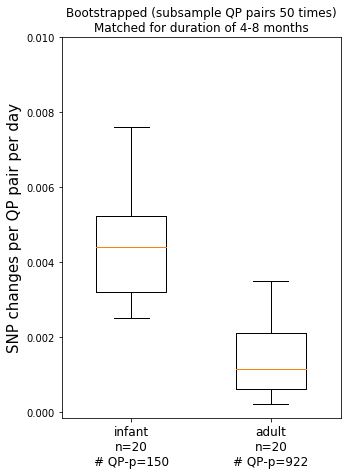

In [17]:
# Perform matching for SNP change rate

# Can now try to make bootstrapped boxplots for each
# duration category; now do 6 months

count_time_tups_by_tp_type_6mon = {'infant': [], 'adult': []}

# Arbitrarily set adults to be 35 years old -> 12765 days at second timepoint
adult_days = 12765

for species in snp_changes:
    for s1, s2 in snp_changes[species]:   
        val = snp_changes[species][(s1, s2)]
        if type(val) == type(1):
            continue # Only looking at modifications/no change
        if (s1 in olm_samples):
            continue # Ignore Olm
        
        num_sweeps = len(val)

        # Form tp_type, days (duration between timepoints), cohort
        tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        day1 = mi_sample_day_dict[s1] if tp_type not in ['AA'] else (adult_days + (sample_order_map[s1][1] * 30.5))
        days = adult_tp_pair_to_days(tp_pair) if tp_type in ['AA'] else sample_pair_to_days(s1, s2)
        cohort = sample_cohort_map[s1]
        '''
        # 6 months +/- 8 days
        if days >= 175 and days <= 191:            
            if tp_type == 'II':
                # print(day1)
                count_time_tups_by_tp_type_6mon['infant'].append((num_sweeps, days))
            elif tp_type == 'AA':
                count_time_tups_by_tp_type_6mon['adult'].append((num_sweeps, days))
        '''
        # 4-8 months
        if days >= (4*30.5) and days <= (8*30.5):            
            if tp_type == 'II':
                # print(day1)
                count_time_tups_by_tp_type_6mon['infant'].append((num_sweeps, days))
            elif tp_type == 'AA':
                count_time_tups_by_tp_type_6mon['adult'].append((num_sweeps, days))

bootstrapped_rates_by_tp_type_6mon = defaultdict(list)
bootstrapped_rates_by_tp_type_6mon_no_zeros = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in count_time_tups_by_tp_type_6mon:
    for _ in np.arange(num_bootstraps):
        all_tups = count_time_tups_by_tp_type_6mon[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_sweeps = 0
        total_days = 0
        total_days_no_zeros = 0
        for num_sweeps, days in bootstrap:
            total_sweeps += num_sweeps
            total_days += days
            if num_sweeps > 0:
                total_days_no_zeros += days
        bootstrapped_rates_by_tp_type_6mon[tp_type].append(float(total_sweeps)/total_days)
        try:
            bootstrapped_rates_by_tp_type_6mon_no_zeros[tp_type].append(float(total_sweeps)/total_days_no_zeros)
        except:
            continue

fig, ax = plt.subplots(figsize=(5,7))

bootstrapped_rates_by_tp_type_6mon_ordered = []
labels = []

for ctt in ['infant', 'adult']:
    bootstrapped_rates_by_tp_type_6mon_ordered.append(bootstrapped_rates_by_tp_type_6mon[ctt])
    labels.append(ctt + '\nn=20\n# QP-p=%i' % (len(count_time_tups_by_tp_type_6mon[ctt])))

ax.boxplot(bootstrapped_rates_by_tp_type_6mon_ordered, widths=[0.5 for _ in bootstrapped_rates_by_tp_type_6mon_ordered])
ax.set_ylim(top=0.01)
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylabel("SNP changes per QP pair per day", fontsize=15)
ax.set_title("Bootstrapped (subsample QP pairs 50 times)\nMatched for duration of 4-8 months")

plt.show()

fig.savefig('%s/snp_change_rates_by_tp_type_ii_vs_aa_with_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

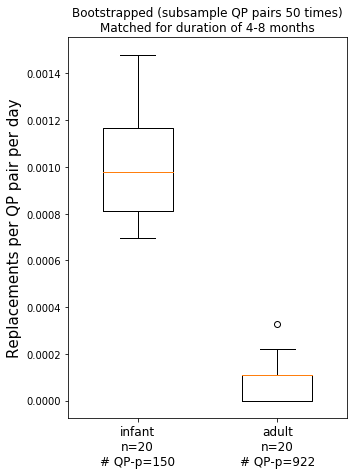

In [18]:
# Perform matching for replacement rate

# Can now try to make bootstrapped boxplots for each
# duration category; now do 6 months

all_time_tups_by_tp_type_6mon = {'infant': [], 'adult': []}

# Arbitrarily set adults to be 35 years old -> 12765 days at second timepoint
adult_days = 12765

for species in snp_changes:
    for s1, s2 in snp_changes[species]:
        
        if (s1 in olm_samples):
            continue # Ignore Olm
        
        val = snp_changes[species][(s1, s2)]
        num_snp_changes = val if isinstance(val, int) else len(val)

        # Form tp_type, days (duration between timepoints), cohort
        tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        day1 = mi_sample_day_dict[s1] if tp_type not in ['AA'] else (adult_days + (sample_order_map[s1][1] * 30.5))
        days = adult_tp_pair_to_days(tp_pair) if tp_type in ['AA'] else sample_pair_to_days(s1, s2)
        cohort = sample_cohort_map[s1]
        '''
        # 6 months +/- 8 days
        if days >= 175 and days <= 191:            
            if tp_type == 'II':
                all_time_tups_by_tp_type_6mon['infant'].append((num_snp_changes, days))
            elif tp_type == 'AA':
                all_time_tups_by_tp_type_6mon['adult'].append((num_snp_changes, days))
        '''
        # 4-8 months
        if days >= (4*30.5) and days <= (8*30.5):            
            if tp_type == 'II':
                all_time_tups_by_tp_type_6mon['infant'].append((num_snp_changes, days))
            elif tp_type == 'AA':
                all_time_tups_by_tp_type_6mon['adult'].append((num_snp_changes, days))
                
bootstrapped_rates_by_tp_type_6mon = defaultdict(list)
bootstrapped_rates_by_tp_type_6mon_no_zeros = defaultdict(list)

num_bootstraps = 20
n = 50
        
for tp_type in all_time_tups_by_tp_type_6mon:
    for _ in np.arange(num_bootstraps):
        all_tups = all_time_tups_by_tp_type_6mon[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_replacements = 0
        total_days = 0
        total_days_no_zeros = 0
        for num_snp_changes, days in bootstrap:
            if num_snp_changes >= 500:
                total_replacements += 1
            total_days += days
            if num_snp_changes > 0:
                total_days_no_zeros += days
        bootstrapped_rates_by_tp_type_6mon[tp_type].append(float(total_replacements)/total_days)
        try:
            bootstrapped_rates_by_tp_type_6mon_no_zeros[tp_type].append(float(total_sweeps)/total_days_no_zeros)
        except:
            continue

fig, ax = plt.subplots(figsize=(5,7))

bootstrapped_rates_by_tp_type_6mon_ordered = []
labels = []

for ctt in ['infant', 'adult']:
    bootstrapped_rates_by_tp_type_6mon_ordered.append(bootstrapped_rates_by_tp_type_6mon[ctt])
    labels.append(ctt + '\nn=20\n# QP-p=%i' % (len(count_time_tups_by_tp_type_6mon[ctt])))

ax.boxplot(bootstrapped_rates_by_tp_type_6mon_ordered, widths=[0.5 for _ in bootstrapped_rates_by_tp_type_6mon_ordered])
# ax.set_ylim(top=0.035)
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylabel("Replacements per QP pair per day", fontsize=15)
ax.set_title("Bootstrapped (subsample QP pairs 50 times)\nMatched for duration of 4-8 months")

plt.show()

fig.savefig('%s/replacement_rates_by_tp_type_ii_vs_aa_with_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

In [19]:
# Now do all this for gene changes yee boi

infant_tp_type_dict = {'Day 0-Week 1': (0, 7), 'Week 1-Month 1': (7,31), 'Month 1-Month 4': (31,122), 'Month 1-Year 1': (31, 366)}

gain_tups_by_infant_tp_type = defaultdict(list)
gain_tups_by_tp_type = defaultdict(list)
loss_tups_by_infant_tp_type = defaultdict(list)
loss_tups_by_tp_type = defaultdict(list)

gain_tups_by_tp_type_6mon = {'infant': [], 'adult': []}
loss_tups_by_tp_type_6mon = {'infant': [], 'adult': []}

# Arbitrarily set adults to be 35 years old -> 12765 days at second timepoint
adult_days = 12765

for species in gene_changes:
    for s1, s2 in gene_changes[species]:
        gains, losses = gene_changes[species][(s1, s2)]
        if type(gains) == type(1):
            continue # Only looking at modifications/no change
        if s1 in olm_samples:
            continue # Ignore Olm
        
        tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
        tpa, tpb = tp_pair
        tp_type = tp_pair_to_tp_type(tp_pair)            
        days = adult_tp_pair_to_days(tp_pair) if tp_type in ['AA'] else sample_pair_to_days(s1, s2)
        
        # Condition MI on comparing to infants in first week
        if tp_type == 'MI':
            if s2 in infant_samples and mi_sample_day_dict[s2] > 7:
                continue
            if s1 in infant_samples and mi_sample_day_dict[s1] > 7:
                continue
        
        # Get number of gene gains/losses
        try:
            num_gains = len(gene_changes[species][(s1, s2)][0])
            num_losses = len(gene_changes[species][(s1, s2)][1])
        except:
            print("Weird")
            num_gains, num_losses = gene_changes[species][(s1, s2)]
        
        # Store by normal tp type
        gain_tups_by_tp_type[tp_type].append((num_gains, days))
        loss_tups_by_tp_type[tp_type].append((num_losses, days))
        
        # Store by infant tp type
        if tp_type == 'II':
            day1, day2 = mi_sample_day_dict[s1], mi_sample_day_dict[s2]
            for infant_tp_type in infant_tp_type_dict:
                start, end = infant_tp_type_dict[infant_tp_type]
                if day1 >= start and day2 <= end:            
                    days = np.abs(day1 - day2)
                    gain_tups_by_infant_tp_type[infant_tp_type].append((num_gains, days))
                    loss_tups_by_infant_tp_type[infant_tp_type].append((num_losses, days))
        '''
        # 6 months +/- 8 days
        if days >= 175 and days <= 191:            
            if tp_type == 'II':
                gain_tups_by_tp_type_6mon['infant'].append((num_gains, days))
                loss_tups_by_tp_type_6mon['infant'].append((num_losses, days))
            elif tp_type == 'AA':
                gain_tups_by_tp_type_6mon['adult'].append((num_gains, days))
                loss_tups_by_tp_type_6mon['adult'].append((num_losses, days))
        '''
        # 4-8 months
        tt:            
            if tp_type == 'II':
                gain_tups_by_tp_type_6mon['infant'].append((num_gains, days))
                loss_tups_by_tp_type_6mon['infant'].append((num_losses, days))
            elif tp_type == 'AA':
                gain_tups_by_tp_type_6mon['adult'].append((num_gains, days))
                loss_tups_by_tp_type_6mon['adult'].append((num_losses, days))

In [20]:
bootstrapped_gain_rates_by_tp_type = defaultdict(list)
bootstrapped_gain_rates_by_infant_tp_type = defaultdict(list)
bootstrapped_loss_rates_by_tp_type = defaultdict(list)
bootstrapped_loss_rates_by_infant_tp_type = defaultdict(list)

num_bootstraps = 20
n = 50

for source, target in zip([gain_tups_by_tp_type, gain_tups_by_infant_tp_type, 
                           loss_tups_by_tp_type, loss_tups_by_infant_tp_type], 
                          [bootstrapped_gain_rates_by_tp_type, bootstrapped_gain_rates_by_infant_tp_type, 
                           bootstrapped_loss_rates_by_tp_type, bootstrapped_loss_rates_by_infant_tp_type]):
    for tp_type in source:
        for _ in np.arange(num_bootstraps):
            bootstrap = [random.choice(source[tp_type]) for i in np.arange(n)]
            total_gains, total_days = 0, 0
            for num_gains, days in bootstrap:
                total_gains += num_gains; total_days += days
            target[tp_type].append(float(total_gains)/total_days)

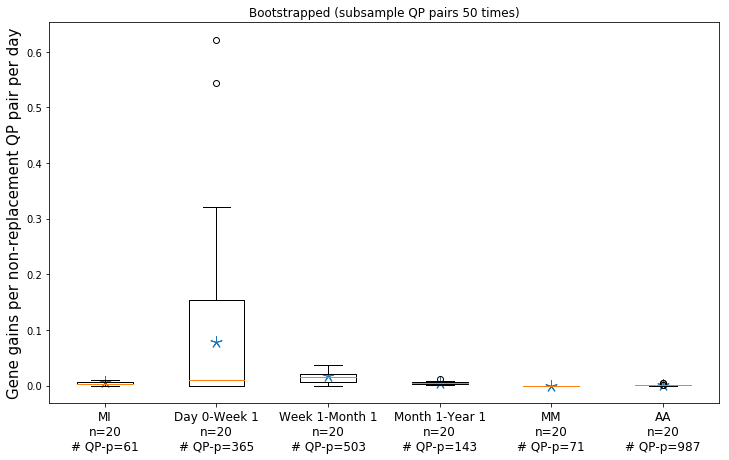

In [21]:
# Plot gene gain rates first

fig, ax = plt.subplots(figsize=(12,7))

tp_types = ['MI', 'MM', 'AA']
tp_type_labels = []
infant_tp_types = ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
infant_tp_type_labels = []

annotations = []

bootstrapped_rates_infant = [bootstrapped_gain_rates_by_infant_tp_type[infant_tp_type] for infant_tp_type in infant_tp_types]
for infant_tp_type in infant_tp_types:
    gain_count, total_days = (0,0)
    for num_gains, days in gain_tups_by_infant_tp_type[infant_tp_type]:
        gain_count += num_gains
        total_days += days
    annotations.append(float(gain_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f %%' % (snp_count, total_days, (snp_count*100.0)/total_days))
    infant_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (infant_tp_type, 
                                                          len(bootstrapped_gain_rates_by_infant_tp_type[infant_tp_type]), 
                                                          len(gain_tups_by_infant_tp_type[infant_tp_type])))

bootstrapped_rates = [bootstrapped_gain_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    gain_count, total_days = (0,0)
    for num_gains, days in gain_tups_by_tp_type[tp_type]:
        gain_count += num_gains
        total_days += days
    annotations.append(float(gain_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f%%' % (snp_count, total_days, float(snp_count)/total_days))
    tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, 
                                                   len(bootstrapped_gain_rates_by_tp_type[tp_type]), 
                                                   len(gain_tups_by_tp_type[tp_type])))

bootstrapped_rates_reordered = [bootstrapped_rates[0]] + bootstrapped_rates_infant + bootstrapped_rates[1:]
tp_type_labels_reordered = [tp_type_labels[0]] + infant_tp_type_labels + tp_type_labels[1:]
annotations_reordered = [annotations[3]] + annotations[0:3] + annotations[4:]

i = 0
for rates in bootstrapped_rates_reordered:
    # ax.text(i+0.7, max(rates) + 0.005, annotations_reordered[i], color='red')
    i += 1

ax.plot(np.arange(1, 1+len(annotations)), annotations_reordered, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates_reordered)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(tp_type_labels_reordered, fontsize=12)
ax.set_ylabel("Gene gains per non-replacement QP pair per day", fontsize=15)
ax.set_title("Bootstrapped (subsample QP pairs 50 times)")

plt.show()

fig.savefig('%s/gene_gain_rates_by_tp_type_overall_with_zeros_labelled.png' % plot_dir, bbox_inches='tight', dpi=600)

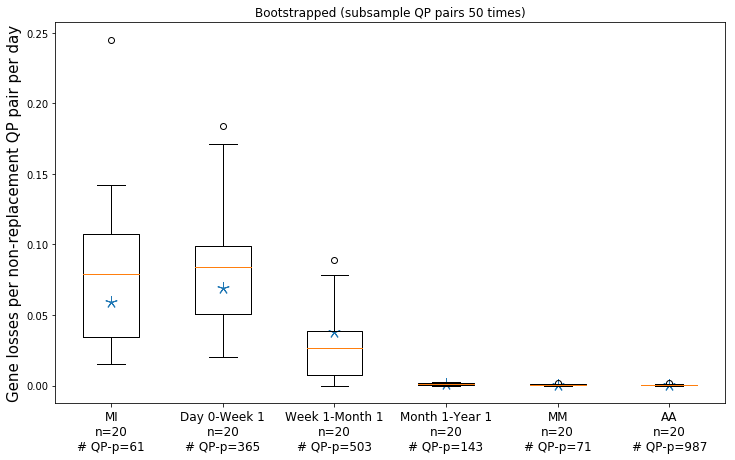

In [22]:
# Next plot gene loss rates

fig, ax = plt.subplots(figsize=(12,7))

tp_types = ['MI', 'MM', 'AA']
tp_type_labels = []
infant_tp_types = ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
infant_tp_type_labels = []

annotations = []

bootstrapped_rates_infant = [bootstrapped_loss_rates_by_infant_tp_type[infant_tp_type] for infant_tp_type in infant_tp_types]
for infant_tp_type in infant_tp_types:
    loss_count, total_days = (0,0)
    for num_losss, days in loss_tups_by_infant_tp_type[infant_tp_type]:
        loss_count += num_losss
        total_days += days
    annotations.append(float(loss_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f %%' % (snp_count, total_days, (snp_count*100.0)/total_days))
    infant_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (infant_tp_type, 
                                                          len(bootstrapped_loss_rates_by_infant_tp_type[infant_tp_type]), 
                                                          len(loss_tups_by_infant_tp_type[infant_tp_type])))

bootstrapped_rates = [bootstrapped_loss_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    loss_count, total_days = (0,0)
    for num_losss, days in loss_tups_by_tp_type[tp_type]:
        loss_count += num_losss
        total_days += days
    annotations.append(float(loss_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f%%' % (snp_count, total_days, float(snp_count)/total_days))
    tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, 
                                                   len(bootstrapped_loss_rates_by_tp_type[tp_type]), 
                                                   len(loss_tups_by_tp_type[tp_type])))

bootstrapped_rates_reordered = [bootstrapped_rates[0]] + bootstrapped_rates_infant + bootstrapped_rates[1:]
tp_type_labels_reordered = [tp_type_labels[0]] + infant_tp_type_labels + tp_type_labels[1:]
annotations_reordered = [annotations[3]] + annotations[0:3] + annotations[4:]

i = 0
for rates in bootstrapped_rates_reordered:
    # ax.text(i+0.7, max(rates) + 0.005, annotations_reordered[i], color='red')
    i += 1

ax.plot(np.arange(1, 1+len(annotations)), annotations_reordered, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates_reordered)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(tp_type_labels_reordered, fontsize=12)
ax.set_ylabel("Gene losses per non-replacement QP pair per day", fontsize=15)
ax.set_title("Bootstrapped (subsample QP pairs 50 times)")

plt.show()

fig.savefig('%s/gene_loss_rates_by_tp_type_overall_with_zeros_labelled.png' % plot_dir, bbox_inches='tight', dpi=600)

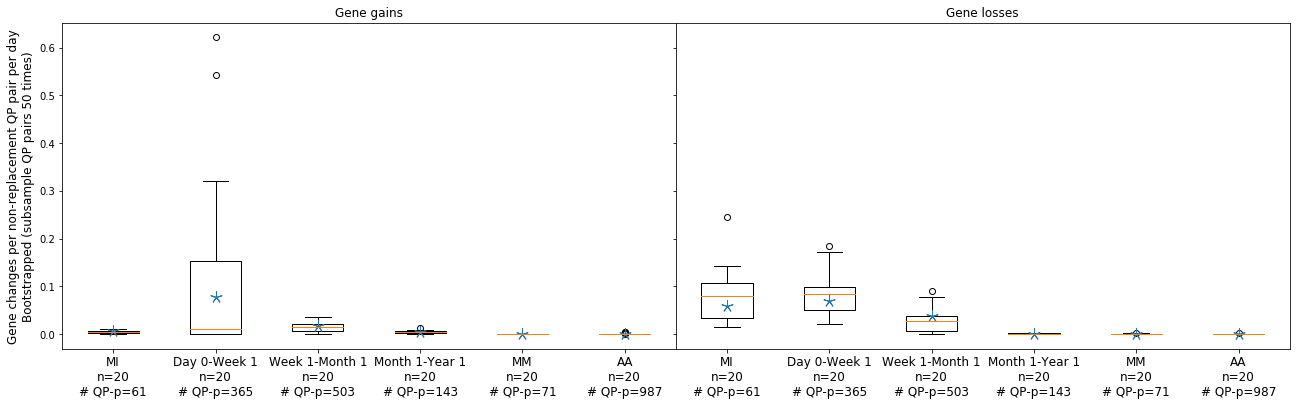

In [23]:
# Combined gain and loss rate plot

fig, ax = plt.subplots(1, 2, figsize=(22, 6), sharey=True)

boxprops = dict(color='#77acff')
medianprops = dict(color='black')
flierprops = dict(marker='.')

# =================== GET DATA ====================
tp_types = ['MI', 'MM', 'AA']
gain_tp_type_labels = []
loss_tp_type_labels = []
infant_tp_types = ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
gain_infant_tp_type_labels = []
loss_infant_tp_type_labels = []

gain_annotations = []
loss_annotations = []

bootstrapped_gain_rates_infant = [bootstrapped_gain_rates_by_infant_tp_type[infant_tp_type] for infant_tp_type in infant_tp_types]
bootstrapped_loss_rates_infant = [bootstrapped_loss_rates_by_infant_tp_type[infant_tp_type] for infant_tp_type in infant_tp_types]

for infant_tp_type in infant_tp_types:
    # Store gain info
    gain_count, total_days = (0,0)
    for num_gains, days in gain_tups_by_infant_tp_type[infant_tp_type]:
        gain_count += num_gains; total_days += days
    gain_annotations.append(float(gain_count)/total_days)
    gain_infant_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (infant_tp_type, 
                                                          len(bootstrapped_gain_rates_by_infant_tp_type[infant_tp_type]), 
                                                          len(gain_tups_by_infant_tp_type[infant_tp_type])))
    # Store loss info
    loss_count, total_days = (0,0)
    for num_losses, days in loss_tups_by_infant_tp_type[infant_tp_type]:
        loss_count += num_losses; total_days += days
    loss_annotations.append(float(loss_count)/total_days)
    loss_infant_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (infant_tp_type, 
                                                          len(bootstrapped_loss_rates_by_infant_tp_type[infant_tp_type]), 
                                                          len(loss_tups_by_infant_tp_type[infant_tp_type])))
    
bootstrapped_gain_rates = [bootstrapped_gain_rates_by_tp_type[tp_type] for tp_type in tp_types]
bootstrapped_loss_rates = [bootstrapped_loss_rates_by_tp_type[tp_type] for tp_type in tp_types]

for tp_type in tp_types:
    
    # Store gain info
    gain_count, total_days = (0,0)
    for num_gains, days in gain_tups_by_tp_type[tp_type]:
        gain_count += num_gains; total_days += days    
    gain_annotations.append(float(gain_count)/total_days)
    gain_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, 
                                                   len(bootstrapped_gain_rates_by_tp_type[tp_type]), 
                                                   len(gain_tups_by_tp_type[tp_type])))
    
    # Store loss info
    loss_count, total_days = (0,0)
    for num_losss, days in loss_tups_by_tp_type[tp_type]:
        loss_count += num_losss
        total_days += days
    loss_annotations.append(float(loss_count)/total_days)
    loss_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, 
                                                   len(bootstrapped_loss_rates_by_tp_type[tp_type]), 
                                                   len(loss_tups_by_tp_type[tp_type])))

bootstrapped_gain_rates_reordered = [bootstrapped_gain_rates[0]] + bootstrapped_gain_rates_infant + bootstrapped_gain_rates[1:]
bootstrapped_loss_rates_reordered = [bootstrapped_loss_rates[0]] + bootstrapped_loss_rates_infant + bootstrapped_loss_rates[1:]
gain_tp_type_labels_reordered = [gain_tp_type_labels[0]] + gain_infant_tp_type_labels + gain_tp_type_labels[1:]
loss_tp_type_labels_reordered = [loss_tp_type_labels[0]] + loss_infant_tp_type_labels + loss_tp_type_labels[1:]
gain_annotations_reordered = [gain_annotations[3]] + gain_annotations[0:3] + gain_annotations[4:]
loss_annotations_reordered = [loss_annotations[3]] + loss_annotations[0:3] + loss_annotations[4:]
# ===============================

ax[0].boxplot(bootstrapped_gain_rates_reordered)
ax[0].plot(np.arange(1, 1+len(gain_annotations)), gain_annotations_reordered, marker=(5, 2), linestyle='None', markersize=12)
ax[0].set_xticklabels(gain_tp_type_labels_reordered, fontsize=12)
ax[0].set_ylabel("Gene changes per non-replacement QP pair per day\nBootstrapped (subsample QP pairs 50 times)", fontsize=12)
ax[0].set_title("Gene gains")

ax[1].boxplot(bootstrapped_loss_rates_reordered)
ax[1].plot(np.arange(1, 1+len(loss_annotations)), loss_annotations_reordered, marker=(5, 2), linestyle='None', markersize=12)
ax[1].set_xticklabels(loss_tp_type_labels_reordered, fontsize=12)
ax[1].set_title("Gene losses")

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

fig.savefig('%s/gene_gain_and_loss_rates_by_tp_type_overall_with_zeros_labelled.png' % plot_dir, bbox_inches='tight', dpi=600)

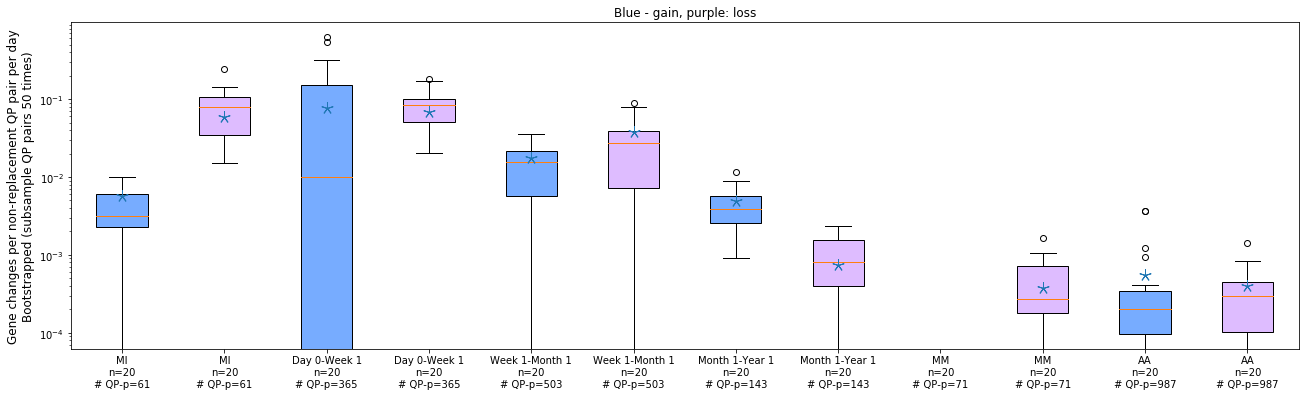

In [24]:
# Combined gain and loss rate plot: another version

fig, ax = plt.subplots(figsize=(22, 6))

boxprops = dict(color='#77acff')
medianprops = dict(color='black')
flierprops = dict(marker='.')

# =================== GET DATA ====================
tp_types = ['MI', 'MM', 'AA']
gain_tp_type_labels = []
loss_tp_type_labels = []
infant_tp_types = ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
gain_infant_tp_type_labels = []
loss_infant_tp_type_labels = []

gain_annotations = []
loss_annotations = []

bootstrapped_gain_rates_infant = [bootstrapped_gain_rates_by_infant_tp_type[infant_tp_type] for infant_tp_type in infant_tp_types]
bootstrapped_loss_rates_infant = [bootstrapped_loss_rates_by_infant_tp_type[infant_tp_type] for infant_tp_type in infant_tp_types]

for infant_tp_type in infant_tp_types:
    # Store gain info
    gain_count, total_days = (0,0)
    for num_gains, days in gain_tups_by_infant_tp_type[infant_tp_type]:
        gain_count += num_gains; total_days += days
    gain_annotations.append(float(gain_count)/total_days)
    gain_infant_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (infant_tp_type, 
                                                          len(bootstrapped_gain_rates_by_infant_tp_type[infant_tp_type]), 
                                                          len(gain_tups_by_infant_tp_type[infant_tp_type])))
    # Store loss info
    loss_count, total_days = (0,0)
    for num_losses, days in loss_tups_by_infant_tp_type[infant_tp_type]:
        loss_count += num_losses; total_days += days
    loss_annotations.append(float(loss_count)/total_days)
    loss_infant_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (infant_tp_type, 
                                                          len(bootstrapped_loss_rates_by_infant_tp_type[infant_tp_type]), 
                                                          len(loss_tups_by_infant_tp_type[infant_tp_type])))
    
bootstrapped_gain_rates = [bootstrapped_gain_rates_by_tp_type[tp_type] for tp_type in tp_types]
bootstrapped_loss_rates = [bootstrapped_loss_rates_by_tp_type[tp_type] for tp_type in tp_types]

for tp_type in tp_types:
    
    # Store gain info
    gain_count, total_days = (0,0)
    for num_gains, days in gain_tups_by_tp_type[tp_type]:
        gain_count += num_gains; total_days += days    
    gain_annotations.append(float(gain_count)/total_days)
    gain_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, 
                                                   len(bootstrapped_gain_rates_by_tp_type[tp_type]), 
                                                   len(gain_tups_by_tp_type[tp_type])))
    
    # Store loss info
    loss_count, total_days = (0,0)
    for num_losss, days in loss_tups_by_tp_type[tp_type]:
        loss_count += num_losss
        total_days += days
    loss_annotations.append(float(loss_count)/total_days)
    loss_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, 
                                                   len(bootstrapped_loss_rates_by_tp_type[tp_type]), 
                                                   len(loss_tups_by_tp_type[tp_type])))

bootstrapped_gain_rates_reordered = [bootstrapped_gain_rates[0]] + bootstrapped_gain_rates_infant + bootstrapped_gain_rates[1:]
bootstrapped_loss_rates_reordered = [bootstrapped_loss_rates[0]] + bootstrapped_loss_rates_infant + bootstrapped_loss_rates[1:]
gain_tp_type_labels_reordered = [gain_tp_type_labels[0]] + gain_infant_tp_type_labels + gain_tp_type_labels[1:]
loss_tp_type_labels_reordered = [loss_tp_type_labels[0]] + loss_infant_tp_type_labels + loss_tp_type_labels[1:]
gain_annotations_reordered = [gain_annotations[3]] + gain_annotations[0:3] + gain_annotations[4:]
loss_annotations_reordered = [loss_annotations[3]] + loss_annotations[0:3] + loss_annotations[4:]
# ===============================

bootstrapped_all_rates_reordered = []
for gain_rates, loss_rates in zip(bootstrapped_gain_rates_reordered, bootstrapped_loss_rates_reordered):
    bootstrapped_all_rates_reordered.append(gain_rates)
    bootstrapped_all_rates_reordered.append(loss_rates)

all_tp_type_labels_reordered = []
for gain_label, loss_label in zip(gain_tp_type_labels_reordered, loss_tp_type_labels_reordered):
    all_tp_type_labels_reordered.append(gain_label)
    all_tp_type_labels_reordered.append(loss_label)

all_annotations_reordered = []
for gain_annotation, loss_annotation in zip(gain_annotations_reordered, loss_annotations_reordered):
    all_annotations_reordered.append(gain_annotation)
    all_annotations_reordered.append(loss_annotation)

boxplots = ax.boxplot(bootstrapped_all_rates_reordered, patch_artist=True, zorder=-1)
for i in np.arange(len(bootstrapped_all_rates_reordered), step=2):
    boxplots['boxes'][i].set_facecolor('#77acff') # gain
    boxplots['boxes'][i+1].set_facecolor('#debcff') # loss

ax.plot(np.arange(1, 1+len(all_annotations_reordered)), all_annotations_reordered, marker=(5, 2), linestyle='None', markersize=12)
ax.set_xticklabels(all_tp_type_labels_reordered)
ax.set_ylabel("Gene changes per non-replacement QP pair per day\nBootstrapped (subsample QP pairs 50 times)", fontsize=12)
ax.set_title("Blue - gain, purple: loss")
ax.set_yscale('log')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

fig.savefig('%s/gene_gain_and_loss_rates_by_tp_type_overall_with_zeros_labelled_sbs.png' % plot_dir, bbox_inches='tight', dpi=600)

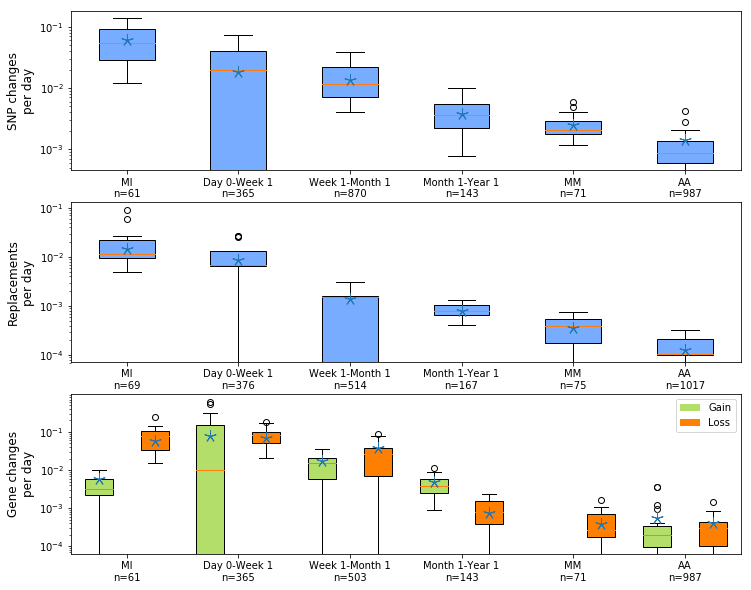

In [25]:
# Combined SNP change, replacement, gene gain and loss rate plot: final version??

fig, ax = plt.subplots(3, 1, figsize=(12, 10))

boxprops = dict(color='#77acff')
medianprops = dict(color='black')
flierprops = dict(marker='.')

# =================== GET DATA ====================
tp_types = ['MI', 'MM', 'AA']
gain_tp_type_labels = []
loss_tp_type_labels = []
infant_tp_types = ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
gain_infant_tp_type_labels = []
loss_infant_tp_type_labels = []

gain_annotations = []
loss_annotations = []

bootstrapped_gain_rates_infant = [bootstrapped_gain_rates_by_infant_tp_type[infant_tp_type] for infant_tp_type in infant_tp_types]
bootstrapped_loss_rates_infant = [bootstrapped_loss_rates_by_infant_tp_type[infant_tp_type] for infant_tp_type in infant_tp_types]

for infant_tp_type in infant_tp_types:
    # Store gain info
    gain_count, total_days = (0,0)
    for num_gains, days in gain_tups_by_infant_tp_type[infant_tp_type]:
        gain_count += num_gains; total_days += days
    gain_annotations.append(float(gain_count)/total_days)
    gain_infant_tp_type_labels.append('%s\nn=%i' % (infant_tp_type, len(gain_tups_by_infant_tp_type[infant_tp_type])))
    # Store loss info
    loss_count, total_days = (0,0)
    for num_losses, days in loss_tups_by_infant_tp_type[infant_tp_type]:
        loss_count += num_losses; total_days += days
    loss_annotations.append(float(loss_count)/total_days)
    loss_infant_tp_type_labels.append('%s\nn=%i' % (infant_tp_type, len(loss_tups_by_infant_tp_type[infant_tp_type])))
    
bootstrapped_gain_rates = [bootstrapped_gain_rates_by_tp_type[tp_type] for tp_type in tp_types]
bootstrapped_loss_rates = [bootstrapped_loss_rates_by_tp_type[tp_type] for tp_type in tp_types]

for tp_type in tp_types:
    
    # Store gain info
    gain_count, total_days = (0,0)
    for num_gains, days in gain_tups_by_tp_type[tp_type]:
        gain_count += num_gains; total_days += days    
    gain_annotations.append(float(gain_count)/total_days)
    gain_tp_type_labels.append('%s\nn=%i' % (tp_type,  len(gain_tups_by_tp_type[tp_type])))
    
    # Store loss info
    loss_count, total_days = (0,0)
    for num_losss, days in loss_tups_by_tp_type[tp_type]:
        loss_count += num_losss
        total_days += days
    loss_annotations.append(float(loss_count)/total_days)
    loss_tp_type_labels.append('%s\nn=%i' % (tp_type, len(loss_tups_by_tp_type[tp_type])))

bootstrapped_gain_rates_reordered = [bootstrapped_gain_rates[0]] + bootstrapped_gain_rates_infant + bootstrapped_gain_rates[1:]
bootstrapped_loss_rates_reordered = [bootstrapped_loss_rates[0]] + bootstrapped_loss_rates_infant + bootstrapped_loss_rates[1:]
gain_tp_type_labels_reordered = [gain_tp_type_labels[0]] + gain_infant_tp_type_labels + gain_tp_type_labels[1:]
loss_tp_type_labels_reordered = [loss_tp_type_labels[0]] + loss_infant_tp_type_labels + loss_tp_type_labels[1:]
gain_annotations_reordered = [gain_annotations[3]] + gain_annotations[0:3] + gain_annotations[4:]
loss_annotations_reordered = [loss_annotations[3]] + loss_annotations[0:3] + loss_annotations[4:]
# ===============================

boxplots_0 = ax[0].boxplot(snp_change_rates, patch_artist=True, zorder=-1)
for i in np.arange(len(snp_change_rates)):
    boxplots_0['boxes'][i].set_facecolor('#77acff')

ax[0].plot(np.arange(1, 1+len(snp_change_rate_annotations)), snp_change_rate_annotations, marker=(5, 2), linestyle='None', markersize=12)
ax[0].set_xticklabels(snp_change_rate_tp_type_labels)
ax[0].set_ylabel("SNP changes\nper day", fontsize=12)
# ax[0].set_title("SNP changes per non-replacement QP pair per day")
ax[0].set_yscale('log')

boxplots_1 = ax[1].boxplot(replacement_rates, patch_artist=True, zorder=-1)
for i in np.arange(len(replacement_rates)):
    boxplots_1['boxes'][i].set_facecolor('#77acff')

ax[1].plot(np.arange(1, 1+len(replacement_rate_annotations)), replacement_rate_annotations, marker=(5, 2), linestyle='None', markersize=12)
ax[1].set_xticklabels(replacement_rate_tp_type_labels)
ax[1].set_ylabel("Replacements\nper day", fontsize=12)
# ax[1].set_title("Replacements per QP pair per day")
ax[1].set_yscale('log')

bootstrapped_all_rates_reordered = []
for gain_rates, loss_rates in zip(bootstrapped_gain_rates_reordered, bootstrapped_loss_rates_reordered):
    bootstrapped_all_rates_reordered.append(gain_rates)
    bootstrapped_all_rates_reordered.append(loss_rates)

all_tp_type_labels_reordered = []
for gain_label, loss_label in zip(gain_tp_type_labels_reordered, loss_tp_type_labels_reordered):
    all_tp_type_labels_reordered.append(gain_label)
    all_tp_type_labels_reordered.append(loss_label)

all_annotations_reordered = []
for gain_annotation, loss_annotation in zip(gain_annotations_reordered, loss_annotations_reordered):
    all_annotations_reordered.append(gain_annotation)
    all_annotations_reordered.append(loss_annotation)

boxplots_2 = ax[2].boxplot(bootstrapped_all_rates_reordered, patch_artist=True, zorder=-1)
for i in np.arange(len(bootstrapped_all_rates_reordered), step=2):
    boxplots_2['boxes'][i].set_facecolor('#b3de69') # gain
    boxplots_2['boxes'][i+1].set_facecolor('#ff7f00') # loss

ax[2].plot(np.arange(1, 1+len(all_annotations_reordered)), all_annotations_reordered, marker=(5, 2), linestyle='None', markersize=12)
ax[2].set_xticks(np.arange(2*len(gain_tp_type_labels_reordered), step=2) + 1.5)
ax[2].set_xticklabels(gain_tp_type_labels_reordered)
ax[2].set_ylabel("Gene changes\nper day", fontsize=12)
# ax[2].set_title("Gene changes per non-replacement QP pair per day")
ax[2].set_yscale('log')

legend_elements = [Patch(facecolor='#b3de69', label='Gain'), Patch(facecolor='#ff7f00', label='Loss')]

ax[2].legend(handles=legend_elements, loc='upper right')

plt.subplots_adjust(wspace=0, hspace=0.2)
plt.show()

# fig.savefig('%s/gene_gain_and_loss_rates_by_tp_type_overall_with_zeros_labelled_sbs.png' % plot_dir, bbox_inches='tight', dpi=600)

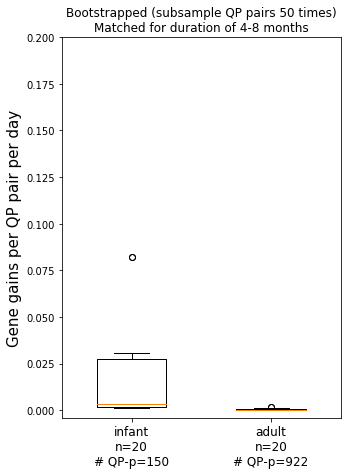

In [18]:
bootstrapped_rates_by_tp_type_6mon = defaultdict(list)
bootstrapped_rates_by_tp_type_6mon_no_zeros = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in gain_tups_by_tp_type_6mon:
    for _ in np.arange(num_bootstraps):
        all_tups = gain_tups_by_tp_type_6mon[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_gains = 0
        total_days = 0
        total_days_no_zeros = 0
        for num_gains, days in bootstrap:
            total_gains += num_gains
            total_days += days
            if num_gains > 0:
                total_days_no_zeros += days
        bootstrapped_rates_by_tp_type_6mon[tp_type].append(float(total_gains)/total_days)
        try:
            bootstrapped_rates_by_tp_type_6mon_no_zeros[tp_type].append(float(total_gains)/total_days_no_zeros)
        except:
            continue

fig, ax = plt.subplots(figsize=(5,7))

bootstrapped_rates_by_tp_type_6mon_ordered = []
labels = []

for ctt in ['infant', 'adult']:
    bootstrapped_rates_by_tp_type_6mon_ordered.append(bootstrapped_rates_by_tp_type_6mon[ctt])
    labels.append(ctt + '\nn=20\n# QP-p=%i' % (len(gain_tups_by_tp_type_6mon[ctt])))

ax.boxplot(bootstrapped_rates_by_tp_type_6mon_ordered, widths=[0.5 for _ in bootstrapped_rates_by_tp_type_6mon_ordered])
ax.set_ylim(top=0.2)
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylabel("Gene gains per QP pair per day", fontsize=15)
ax.set_title("Bootstrapped (subsample QP pairs 50 times)\nMatched for duration of 4-8 months")

plt.show()

fig.savefig('%s/gene_gain_rates_by_tp_type_ii_vs_aa_with_zeros_labelled.png' % plot_dir, bbox_inches='tight', dpi=600)

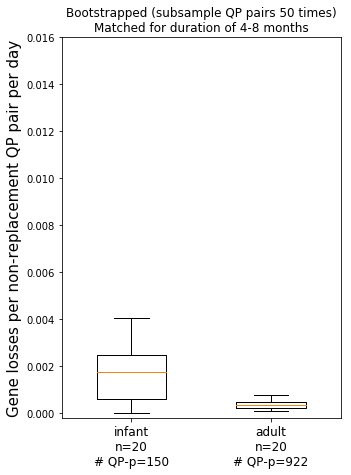

In [19]:
bootstrapped_rates_by_tp_type_6mon = defaultdict(list)
bootstrapped_rates_by_tp_type_6mon_no_zeros = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in loss_tups_by_tp_type_6mon:
    for _ in np.arange(num_bootstraps):
        all_tups = loss_tups_by_tp_type_6mon[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_losss = 0
        total_days = 0
        total_days_no_zeros = 0
        for num_loss, days in bootstrap:
            total_losss += num_loss
            total_days += days
            if num_loss > 0:
                total_days_no_zeros += days
        bootstrapped_rates_by_tp_type_6mon[tp_type].append(float(total_losss)/total_days)
        try:
            bootstrapped_rates_by_tp_type_6mon_no_zeros[tp_type].append(float(total_losss)/total_days_no_zeros)
        except:
            continue

fig, ax = plt.subplots(figsize=(5,7))

bootstrapped_rates_by_tp_type_6mon_ordered = []
labels = []

for ctt in ['infant', 'adult']:
    bootstrapped_rates_by_tp_type_6mon_ordered.append(bootstrapped_rates_by_tp_type_6mon[ctt])
    labels.append(ctt + '\nn=20\n# QP-p=%i' % (len(loss_tups_by_tp_type_6mon[ctt])))

ax.boxplot(bootstrapped_rates_by_tp_type_6mon_ordered, widths=[0.5 for _ in bootstrapped_rates_by_tp_type_6mon_ordered])
ax.set_ylim(top=0.016)
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylabel("Gene losses per non-replacement QP pair per day", fontsize=15)
ax.set_title("Bootstrapped (subsample QP pairs 50 times)\nMatched for duration of 4-8 months")

plt.show()

fig.savefig('%s/gene_loss_rates_by_tp_type_ii_vs_aa_with_zeros_labelled.png' % plot_dir, bbox_inches='tight', dpi=600)

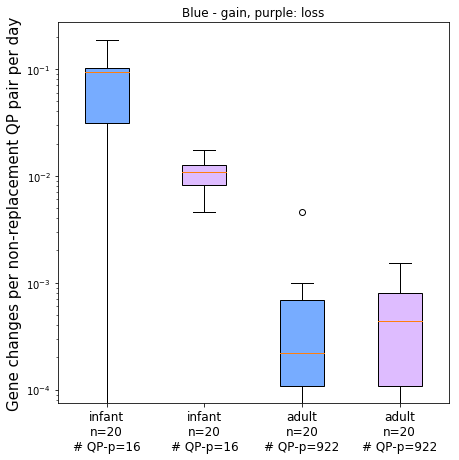

In [40]:
# Combined gene gain and loss rates matched for 6 months

bootstrapped_gain_rates_by_tp_type_6mon = defaultdict(list)
bootstrapped_gain_rates_by_tp_type_6mon_no_zeros = defaultdict(list)
bootstrapped_loss_rates_by_tp_type_6mon = defaultdict(list)
bootstrapped_loss_rates_by_tp_type_6mon_no_zeros = defaultdict(list)

num_bootstraps = 20; n = 50

for tp_type in gain_tups_by_tp_type_6mon:
    for _ in np.arange(num_bootstraps):
        all_tups = gain_tups_by_tp_type_6mon[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_gains = 0; total_days = 0; total_days_no_zeros = 0
        for num_gains, days in bootstrap:
            total_gains += num_gains; total_days += days
            if num_gains > 0:
                total_days_no_zeros += days
        bootstrapped_gain_rates_by_tp_type_6mon[tp_type].append(float(total_gains)/total_days)
        if total_days_no_zeros > 0:
            bootstrapped_gain_rates_by_tp_type_6mon_no_zeros[tp_type].append(float(total_gains)/total_days_no_zeros)

for tp_type in loss_tups_by_tp_type_6mon:
    for _ in np.arange(num_bootstraps):
        all_tups = loss_tups_by_tp_type_6mon[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_losses = 0; total_days = 0; total_days_no_zeros = 0
        for num_loss, days in bootstrap:
            total_losses += num_loss; total_days += days
            if num_loss > 0:
                total_days_no_zeros += days
        bootstrapped_loss_rates_by_tp_type_6mon[tp_type].append(float(total_losses)/total_days)
        if total_days_no_zeros > 0:
            bootstrapped_loss_rates_by_tp_type_6mon_no_zeros[tp_type].append(float(total_losses)/total_days_no_zeros)

bootstrapped_gain_rates_by_tp_type_6mon_ordered = []
bootstrapped_loss_rates_by_tp_type_6mon_ordered = []
gain_labels = []; loss_labels = []

for ctt in ['infant', 'adult']:
    bootstrapped_gain_rates_by_tp_type_6mon_ordered.append(bootstrapped_gain_rates_by_tp_type_6mon[ctt])
    bootstrapped_loss_rates_by_tp_type_6mon_ordered.append(bootstrapped_loss_rates_by_tp_type_6mon[ctt])
    gain_labels.append(ctt + '\nn=20\n# QP-p=%i' % (len(gain_tups_by_tp_type_6mon[ctt])))
    loss_labels.append(ctt + '\nn=20\n# QP-p=%i' % (len(loss_tups_by_tp_type_6mon[ctt])))

bootstrapped_all_rates_ordered = []
for gr, lr in zip(bootstrapped_gain_rates_by_tp_type_6mon_ordered, bootstrapped_loss_rates_by_tp_type_6mon_ordered):
    bootstrapped_all_rates_ordered += [gr, lr]

all_labels = []
for gl, ll in zip(gain_labels, loss_labels):
    all_labels += [gl, ll]

# PLOT

fig, ax = plt.subplots(figsize=(7,7))

boxplots = ax.boxplot(bootstrapped_all_rates_ordered, patch_artist=True, zorder=-1)
for i in np.arange(len(bootstrapped_all_rates_ordered), step=2):
    boxplots['boxes'][i].set_facecolor('#77acff') # gain
    boxplots['boxes'][i+1].set_facecolor('#debcff') # loss

ax.set_xticklabels(all_labels, fontsize=12)
ax.set_ylabel("Gene changes per non-replacement QP pair per day", fontsize=15)
ax.set_title("Bootstrapped (subsample QP pairs 50 times)\nBootstrapped (subsample QP pairs 50 times)\nMatched for duration of 6 months")
ax.set_title("Blue - gain, purple: loss")
ax.set_yscale('log')
plt.show()

fig.savefig('%s/gene_gain_and_loss_rates_by_tp_type_ii_vs_aa_with_zeros_labelled_sbs.png' % plot_dir, bbox_inches='tight', dpi=600)

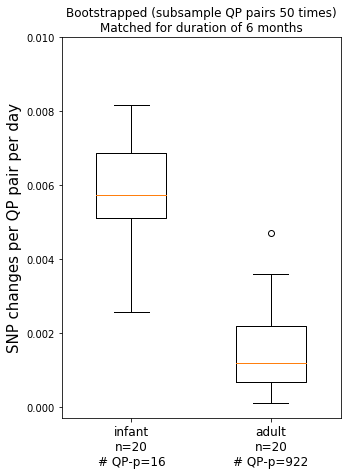

In [31]:
# Perform matching for gene gains/losses

# Can now try to make bootstrapped boxplots for each
# duration category; now do 6 months

count_time_tups_by_tp_type_6mon = {'infant': [], 'adult': []}

# Arbitrarily set adults to be 35 years old -> 12765 days at second timepoint
adult_days = 12765

for species in snp_changes:
    for s1, s2 in snp_changes[species]:   
        val = snp_changes[species][(s1, s2)]
        if type(val) == type(1):
            continue # Only looking at modifications/no change
        if (s1 in olm_samples):
            continue # Ignore Olm
        
        num_sweeps = len(val)

        # Form tp_type, days (duration between timepoints), cohort
        tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        day1 = mi_sample_day_dict[s1] if tp_type not in ['AA'] else (adult_days + (sample_order_map[s1][1] * 30.5))
        days = adult_tp_pair_to_days(tp_pair) if tp_type in ['AA'] else sample_pair_to_days(s1, s2)
        cohort = sample_cohort_map[s1]

        # 6 months +/- 8 days
        if days >= 175 and days <= 191:            
            if tp_type == 'II':
                # print(day1)
                count_time_tups_by_tp_type_6mon['infant'].append((num_sweeps, days))
            elif tp_type == 'AA':
                count_time_tups_by_tp_type_6mon['adult'].append((num_sweeps, days))

bootstrapped_rates_by_tp_type_6mon = defaultdict(list)
bootstrapped_rates_by_tp_type_6mon_no_zeros = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in count_time_tups_by_tp_type_6mon:
    for _ in np.arange(num_bootstraps):
        all_tups = count_time_tups_by_tp_type_6mon[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_sweeps = 0
        total_days = 0
        total_days_no_zeros = 0
        for num_sweeps, days in bootstrap:
            total_sweeps += num_sweeps
            total_days += days
            if num_sweeps > 0:
                total_days_no_zeros += days
        bootstrapped_rates_by_tp_type_6mon[tp_type].append(float(total_sweeps)/total_days)
        try:
            bootstrapped_rates_by_tp_type_6mon_no_zeros[tp_type].append(float(total_sweeps)/total_days_no_zeros)
        except:
            continue

fig, ax = plt.subplots(figsize=(5,7))

bootstrapped_rates_by_tp_type_6mon_ordered = []
labels = []

for ctt in ['infant', 'adult']:
    bootstrapped_rates_by_tp_type_6mon_ordered.append(bootstrapped_rates_by_tp_type_6mon[ctt])
    labels.append(ctt + '\nn=20\n# QP-p=%i' % (len(count_time_tups_by_tp_type_6mon[ctt])))

ax.boxplot(bootstrapped_rates_by_tp_type_6mon_ordered, widths=[0.5 for _ in bootstrapped_rates_by_tp_type_6mon_ordered])
ax.set_ylim(top=0.01)
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylabel("SNP changes per QP pair per day", fontsize=15)
ax.set_title("Bootstrapped (subsample QP pairs 50 times)\nMatched for duration of 6 months")

plt.show()

# fig.savefig('%s/snp_change_rates_by_tp_type_ii_vs_aa_with_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

In [ ]:
# Gene gains and losses: prevalences

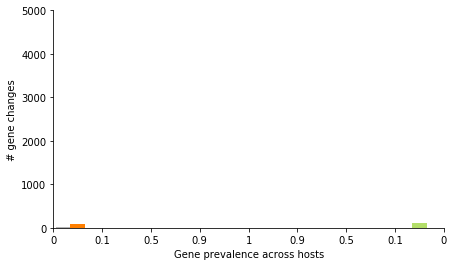

In [10]:
# Earlier version that worked
fig, gene_prev_axis = plt.subplots(figsize=(7,4))

gene_prev_axis.spines['top'].set_visible(False)
gene_prev_axis.spines['right'].set_visible(False)
gene_prev_axis.get_xaxis().tick_bottom()
gene_prev_axis.get_yaxis().tick_left() 
gene_prev_axis.set_xlabel('Gene prevalence across hosts')
gene_prev_axis.set_ylabel('# gene changes')
gene_prev_axis.set_xlim([gene_freq_xticks[0],gene_freq_xticks[-1]])
gene_prev_axis.set_xticks(gene_freq_xticks)
gene_prev_axis.set_xticklabels(gene_freq_xticklabels)
gene_prev_axis.plot([0,0],[100,100],'k-')
gene_prev_axis.set_ylim([0,5000])

total_freq_gains = np.zeros(len(gene_freq_bins)-1)*1.0
total_freq_losses = np.zeros(len(gene_freq_bins)-1)*1.0
total_null_freq_losses = np.zeros(len(gene_freq_bins)-1)*1.0

for species in gene_gain_freqs:
	for sample_i, sample_j in gene_gain_freqs[species]:
		# Only plot infant-infant here
		if not(sample_i in hmp_samples and sample_j in hmp_samples):
			continue
		for f in gene_gain_freqs[species][(sample_i, sample_j)]:
			f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
			total_freq_gains[f_idx] += 1

for species in gene_loss_freqs:
	for sample_i, sample_j in gene_loss_freqs[species]:
		# Only plot infant-infant here
		if not(sample_i in hmp_samples and sample_j in hmp_samples):
			continue
		for f in gene_loss_freqs[species][(sample_i, sample_j)]:
			f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
			total_freq_losses[f_idx] += 1

for species in gene_loss_null_freqs:
	for sample_i, sample_j in gene_loss_null_freqs[species]:
		# Only plot infant-infant here
		if not(sample_i in hmp_samples and sample_j in hmp_samples):
			continue
		for f in gene_loss_null_freqs[species][(sample_i, sample_j)]:
			f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
			total_null_freq_losses[f_idx] += (1.0/num_bootstraps)

gene_prev_axis.bar(gene_gain_virtual_freqs, total_freq_gains,width=0.3,linewidth=0,facecolor='#b3de69',label='gain')
gene_prev_axis.bar(gene_loss_virtual_freqs, total_freq_losses,width=0.3,linewidth=0, facecolor='#ff7f00',label='loss')
gene_prev_axis.bar(gene_loss_virtual_freqs-0.3, total_null_freq_losses,width=0.3,linewidth=0, facecolor='0.7',label='de novo\nexpectation')

plt.show()
# fig.savefig('%s/gene_change_prevalence_II_no_olm.pdf' % (config.analysis_directory),bbox_inches='tight')

/u/local/apps/python/2.7.13/lib/python2.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


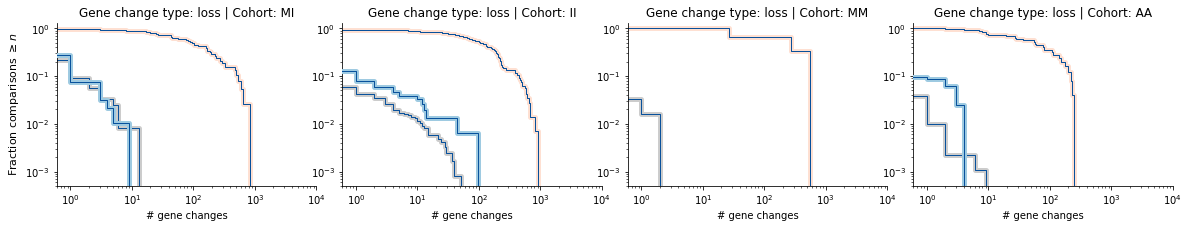

In [32]:
# Gene gains and losses
'''
custom_cohort_tests = {}
custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples_no_olm)
# custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples_no_olm) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['Day 0-Week 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7))
custom_cohort_tests['Week 1-Month 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 7 and mi_sample_day_dict[sample_j] <= 31))
custom_cohort_tests['Month 1-Year 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 31 and mi_sample_day_dict[sample_j] <= 366))
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)
'''
custom_cohort_tests = {}
custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples_no_olm)
# custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples_no_olm) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['II'] = lambda sample_i, sample_j: (sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm)
# custom_cohort_tests['II-short'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (sample_pair_to_days(sample_i, sample_j) <= 32))
# custom_cohort_tests['II-long'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (sample_pair_to_days(sample_i, sample_j) > 32))
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)

custom_cohorts_ordered = ['MI', 'II', 'MM', 'AA']
desired_custom_cohort = 'II'

true_modification_gene_change_distribution = {cohort: {gg_type: [] for gg_type in ['gain', 'loss', 'all']} 
                                              for cohort in custom_cohorts_ordered}
replacement_gene_change_distribution = {cohort: {gg_type: [] for gg_type in ['gain', 'loss', 'all']}
                                        for cohort in custom_cohorts_ordered}
no_snv_gene_change_distribution = {cohort: {gg_type: [] for gg_type in ['gain', 'loss', 'all']}
                                   for cohort in custom_cohorts_ordered}

for species in gene_changes:
    for sample_i, sample_j in gene_changes[species]:
        custom_cohort = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        if not custom_cohort:
            continue
        try:
            num_snp_changes = len(snp_changes[species][(sample_i, sample_j)])
            num_gains = len(gene_changes[species][(sample_i, sample_j)][0])
            num_losses = len(gene_changes[species][(sample_i, sample_j)][1])
        except:
            num_snp_changes = snp_changes[species][(sample_i, sample_j)]
            num_gains, num_losses = gene_changes[species][(sample_i, sample_j)]
        num_gene_changes = num_gains + num_losses

        if num_snp_changes == 0:
            no_snv_gene_change_distribution[custom_cohort]['all'].append(num_gene_changes)
            no_snv_gene_change_distribution[custom_cohort]['loss'].append(num_losses)
            no_snv_gene_change_distribution[custom_cohort]['gain'].append(num_gains)
        elif num_snp_changes <= modification_difference_threshold:
            true_modification_gene_change_distribution[custom_cohort]['all'].append(num_gene_changes)
            true_modification_gene_change_distribution[custom_cohort]['loss'].append(num_losses)
            true_modification_gene_change_distribution[custom_cohort]['gain'].append(num_gains)
        elif num_snp_changes >= replacement_difference_threshold:
            replacement_gene_change_distribution[custom_cohort]['all'].append(num_gene_changes)
            replacement_gene_change_distribution[custom_cohort]['loss'].append(num_losses)
            replacement_gene_change_distribution[custom_cohort]['gain'].append(num_gains)

# Now plot
fig, gene_change_axis = plt.subplots(1, 4, figsize=(20,3))
gene_change_axis[0].set_xscale('log')
gene_change_axis[0].set_yscale('log')
gene_change_axis[0].set_ylabel('Fraction comparisons $\geq n$', fontsize=11)

# xs, ns = stats_utils.calculate_unnormalized_survival_from_vector(pooled_between_gene_change_distribution[cohort], min_x=1e-07, max_x=1e09)
# gene_change_axis.step(xs,ns/ns[0],linewidth=1,color='r', alpha=0.5, label='Between-host',zorder=1)

gg_type = 'loss'

for i in range(len(custom_cohorts_ordered)):
    desired_custom_cohort = custom_cohorts_ordered[i]
    
    # Formatting
    gene_change_axis[i].set_xlim([0.6,1e04])
    gene_change_axis[i].spines['top'].set_visible(False)
    gene_change_axis[i].spines['right'].set_visible(False)
    gene_change_axis[i].get_xaxis().tick_bottom()
    gene_change_axis[i].get_yaxis().tick_left()
    gene_change_axis[i].loglog([0.1],[1],'k.')    
    gene_change_axis[i].set_xlabel('# gene changes')
    gene_change_axis[i].set_title('Gene change type: %s | Cohort: %s' % (gg_type, desired_custom_cohort))
    
    # Within-host modification
    xs, ns = stats_utils.calculate_unnormalized_survival_from_vector(true_modification_gene_change_distribution[desired_custom_cohort][gg_type], min_x=1e-07, max_x=1e09)
    gene_change_axis[i].step(xs,ns/ns[0],'-',color='#08519c',linewidth=1, label='Within-host',zorder=3,where='pre',path_effects=[pe.Stroke(linewidth=5, foreground='#9ecae1'), pe.Normal()])
    
    # Within-host replacement
    xs, ns = stats_utils.calculate_unnormalized_survival_from_vector(replacement_gene_change_distribution[desired_custom_cohort][gg_type], min_x=1e-07, max_x=1e09)
    gene_change_axis[i].step(xs,ns/ns[0],'-',color='#08519c',linewidth=1, label='Within-host',zorder=2,where='pre',path_effects=[pe.Stroke(linewidth=5, foreground='#fee0d2'), pe.Normal()])
    
    # Within-host no change
    xs, ns = stats_utils.calculate_unnormalized_survival_from_vector(no_snv_gene_change_distribution[desired_custom_cohort][gg_type], min_x=1e-07, max_x=1e09)
    gene_change_axis[i].step(xs,ns/ns[0],'-',color='#08519c',linewidth=1, label='Within-host',zorder=2,where='pre',path_effects=[pe.Stroke(linewidth=5, foreground='0.8'), pe.Normal()])
    
    ymin = 0.0005
    ymax = 1.3
    gene_change_axis[i].set_ylim([ymin,ymax])

plt.subplots_adjust(wspace=0.1)
# fig.savefig('%s/gene_change_survival_curve_cohorts_combined_%s.pdf' % (config.analysis_directory, gg_type),bbox_inches='tight')
plt.show()

In [8]:
# Figure 3: SNP prevalences

desired_event_type = 'modification'
tp_types = ['II', 'MI', 'AA']
prev_cohorts = ['nonpremie', 'hmp', 'mother']
variant_types = ['4D', '1D', '2D', '3D']

prev_distribution = {prev_cohort: {tp_type: {variant_type: np.zeros(len(derived_virtual_freqs)) for variant_type in variant_types} for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}
qp_pairs_by_freq = {prev_cohort: {tp_type: [set()] * len(derived_virtual_freqs) for tp_type in tp_types} 
                          for prev_cohort in prev_cohorts}
null_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(derived_virtual_freqs)) for tp_type in tp_types} 
                          for prev_cohort in prev_cohorts}
nonsyn_opps_distribution = {prev_cohort: {tp_type: {variant_type: np.zeros(len(derived_virtual_freqs)) for variant_type in variant_types} for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}
syn_opps_distribution = {prev_cohort: {tp_type: {variant_type: np.zeros(len(derived_virtual_freqs)) for variant_type in variant_types} for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}

for species in snp_change_freqs:
    for sample_i, sample_j in snp_change_freqs[species]:
        
        tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        if tp_type not in tp_types:
            continue
        
        pdicts = snp_change_freqs_with_opps[species][(sample_i, sample_j)] # list of (vartype, freq_dict, opp_dict tuples)
        npdict = snp_change_null_freqs[species][(sample_i, sample_j)] # dict: prev_cohort > list of (freq, weight) tuples
        
        snp_change_val = snp_changes[species][(sample_i, sample_j)]
        
        # How to assign dN/dS to different prevalence bins?
        # For each QP pair, there are a number of 4D and 1D opportunities,
        # and a number of SNPs that actually change each with different derived allele prevlences
        # For each SNP change, we add its nonsyn_opps and syn_opps to running total for
        # the prevalence bin, then divide actual numbers
        nonsyn_diffs, nonsyn_opps, syn_diffs, syn_opps = dnds_info[species][(sample_i, sample_j)]
        
        if type(snp_change_val) == type(1):
            event_type = 'replacement'
        elif len(snp_change_val) > 0 and len(snp_change_val) <= modification_difference_threshold:
            event_type = 'modification'
        else:
            continue
        
        if event_type != desired_event_type:
            continue
        
        for prev_cohort in prev_cohorts:
            for f, weight in npdict[prev_cohort]:
                f_idx = get_f_idx(f)
                null_prev_distribution[prev_cohort][tp_type][f_idx] += weight
        
        for vartype, fdict, opp_dict in pdicts:
            for prev_cohort in prev_cohorts:
                
                f = fdict[prev_cohort]
                f_idx = get_f_idx(f)
                
                prev_distribution[prev_cohort][tp_type][vartype][f_idx] += 1
                nonsyn_opps_distribution[prev_cohort][tp_type][vartype][f_idx] += nonsyn_opps
                syn_opps_distribution[prev_cohort][tp_type][vartype][f_idx] += syn_opps
                
                qp_pairs_by_freq[prev_cohort][tp_type][f_idx].add((sample_i, sample_j, species))

In [9]:
# Opportunities per prevalence bin summed over QP pairs instead of SNP changes
nonsyn_opps_distribution_alt = {prev_cohort: {tp_type: np.zeros(len(derived_virtual_freqs)) for tp_type in tp_types} 
                          for prev_cohort in prev_cohorts}
syn_opps_distribution_alt = {prev_cohort: {tp_type: np.zeros(len(derived_virtual_freqs)) for tp_type in tp_types} 
                          for prev_cohort in prev_cohorts}

for prev_cohort in prev_cohorts:
    for tp_type in tp_types:
        for i in range(len(derived_virtual_freqs)):
            for qp_pair in qp_pairs_by_freq[prev_cohort][tp_type][i]:
                sample_i, sample_j, species = qp_pair
                nonsyn_diffs, nonsyn_opps, syn_diffs, syn_opps = dnds_info[species][(sample_i, sample_j)]
                nonsyn_opps_distribution_alt[prev_cohort][tp_type][i] += nonsyn_opps
                syn_opps_distribution_alt[prev_cohort][tp_type][i] += syn_opps

In [10]:
# Get overall dN/dS for II, AA, MI
from __future__ import division

prev_cohort = 'hmp' # arbitrary

for tp_type in ['II', 'MI', 'AA']:
    dNs = []
    nonsyn_opps = sum(nonsyn_opps_distribution_alt[prev_cohort][tp_type])
    nonsyn_count = sum(prev_distribution[prev_cohort][tp_type]['1D'])
    syn_opps = sum(syn_opps_distribution_alt[prev_cohort][tp_type])
    syn_count = sum(prev_distribution[prev_cohort][tp_type]['4D'])
    dNdS = (nonsyn_count/nonsyn_opps)/(syn_count/syn_opps)
    print("dN/dS for %s: %.03f" % (tp_type, dNdS))

dN/dS for II: 0.674
dN/dS for MI: 0.561
dN/dS for AA: 0.730


In [11]:
# Get dN/dS for II life stages

infant_tp_type_dict = {'Day 0-Week 1': (0, 7), 'Week 1-Month 1': (7,31), 'Month 1-Year 1': (31, 367)}

nonsyn_counts_by_stage = {stage: 0 for stage in infant_tp_type_dict}
syn_counts_by_stage = {stage: 0 for stage in infant_tp_type_dict}
qp_pairs_by_stage = {stage: set() for stage in infant_tp_type_dict}

for species in snp_changes:
    for s1, s2 in snp_changes[species]:        
        val = snp_changes[species][(s1, s2)]
        
        if type(snp_change_val) == type(1):
            event_type = 'replacement'
        elif len(snp_change_val) > 0 and len(snp_change_val) <= modification_difference_threshold:
            event_type = 'modification'
        else:
            continue
        
        # Only look at modification
        if event_type != 'modification':
            continue
        
        if (s1 in infant_samples_no_olm and s2 in infant_samples_no_olm):
            day1, day2 = mi_sample_day_dict[s1], mi_sample_day_dict[s2]
            for infant_tp_type in infant_tp_type_dict:
                start, end = infant_tp_type_dict[infant_tp_type]
                if day1 >= start and day2 <= end:            
                    break
        
        qp_pairs_by_stage[infant_tp_type].add((s1, s2, species))
        
        pdicts = snp_change_freqs[species][(s1, s2)]
        for vartype, freq_dict in pdicts:
            if vartype == '1D':
                nonsyn_counts_by_stage[infant_tp_type] += 1
            elif vartype == '4D':
                syn_counts_by_stage[infant_tp_type] += 1

for stage in infant_tp_type_dict:
    nonsyn_count = nonsyn_counts_by_stage[stage]
    syn_count = syn_counts_by_stage[stage]
    total_nonsyn_opps = 0
    total_syn_opps = 0
    for qp_pair in qp_pairs_by_stage[stage]:
        s1, s2, species = qp_pair
        _, nonsyn_opps, _, syn_opps = dnds_info[species][(s1, s2)]
        total_nonsyn_opps += nonsyn_opps
        total_syn_opps += syn_opps
    print(stage)
    print('Number of nonsynonymous SNP modifications: %i' % (nonsyn_count))
    print('Number of synonymous SNP modifications: %i' % (syn_count))
    print('dN/dS: %.03f' % ((nonsyn_count/total_nonsyn_opps)/(syn_count/total_syn_opps)))

Month 1-Year 1
Number of nonsynonymous SNP modifications: 127
Number of synonymous SNP modifications: 32
dN/dS: 0.913
Day 0-Week 1
Number of nonsynonymous SNP modifications: 42
Number of synonymous SNP modifications: 13
dN/dS: 0.768
Week 1-Month 1
Number of nonsynonymous SNP modifications: 431
Number of synonymous SNP modifications: 175
dN/dS: 0.588


/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:71: RuntimeWarning: divide by zero encountered in true_divide
/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in true_divide
/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in less
/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in greater


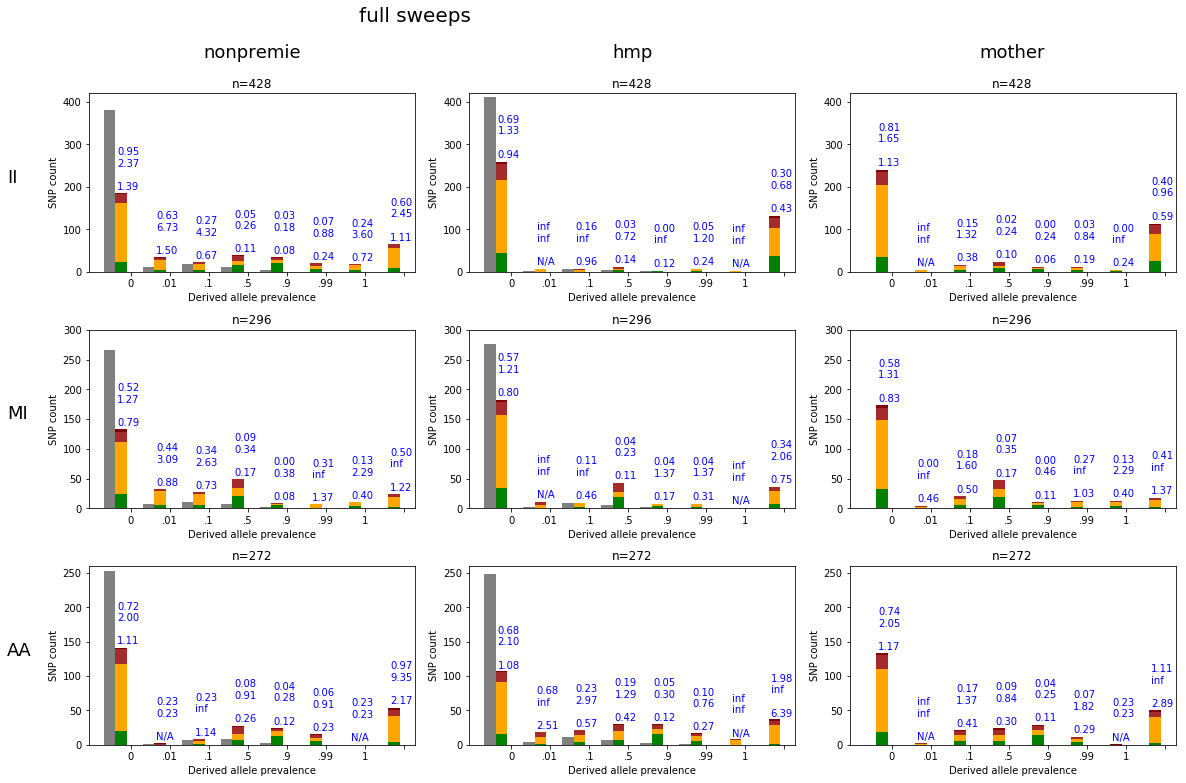

In [12]:
# the whole shebang (format 2)
# binned histogram of prevalences of sites
# that undergo modification
# in infants, adults, mothers with respect to themselves

# from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(3, 3, figsize=(16, 10)) # sharey='row' # originally (12, 10) for 3 x 2
colors = {'1D': 'orange', '4D': 'green', '2D': 'brown', '3D': 'maroon'}

i=0
event_type = 'modification'

tp_types = ['II', 'MI', 'AA']
prev_cohorts = ['nonpremie', 'hmp', 'mother']

num_bootstraps = 10000

for tp_type in tp_types:
    j = 0
    for prev_cohort in prev_cohorts:
        
        # Get and plot actual counts
        cum_bin_counts = np.zeros(len(derived_virtual_freqs))        
        for variant_type in ['4D', '1D', '2D', '3D']:
            bin_counts = prev_distribution[prev_cohort][tp_type][variant_type]
            ax[i][j].bar(derived_virtual_freqs, bin_counts, bottom=cum_bin_counts, width=0.3, align='center', color=colors[variant_type])
            cum_bin_counts += bin_counts
        
        # Get and plot null expectation
        null_bin_counts = null_prev_distribution[prev_cohort][tp_type]        
        ax[i][j].bar(derived_virtual_freqs-0.3, null_bin_counts, width=0.3, align='center', color='gray')
        
        # Get dN/dS values
        dNs = []
        for nonsyn_opps, nonsyn_count in zip(nonsyn_opps_distribution_alt[prev_cohort][tp_type], prev_distribution[prev_cohort][tp_type]['1D']):
            if nonsyn_opps <= 0:
                dNs.append('N/A')
                continue
            dNs.append(float(nonsyn_count)/float(nonsyn_opps))
        
        dSs = []
        for syn_opps, syn_count in zip(syn_opps_distribution_alt[prev_cohort][tp_type], prev_distribution[prev_cohort][tp_type]['4D']):
            if syn_opps <= 0:
                dSs.append('N/A')
                continue
            dSs.append(float(syn_count)/float(syn_opps))
        
        dNdSs = []
        for dN, dS in zip(dNs, dSs):
            try:
                dNdSs.append('%.02f' % (dN/float(dS)))
            except:
                dNdSs.append('N/A') # Dummy number
        
        # Get bootstrapped dN/dS values
        non_ns = prev_distribution[prev_cohort][tp_type]['1D']
        syn_ns = prev_distribution[prev_cohort][tp_type]['4D']
        non_opportunities = nonsyn_opps_distribution_alt[prev_cohort][tp_type]
        syn_opportunities = syn_opps_distribution_alt[prev_cohort][tp_type]
        
        total_ns = (non_ns + syn_ns).astype('int64')
        ps = non_ns*1.0/total_ns
        
        bootstrapped_dNdSs = []
        
        for bootstrap_idx in xrange(0,num_bootstraps):
            bootstrapped_non_ns = sample_binomial(total_ns, ps)
            bootstrapped_syn_ns = total_ns - bootstrapped_non_ns
            bootstrapped_dNdSs.append( bootstrapped_non_ns*1.0/bootstrapped_syn_ns / (non_opportunities*1.0/syn_opportunities) )

        bootstrapped_dNdSs = np.sort( bootstrapped_dNdSs, axis=0 )
        bootstrapped_dNdSs_lower = bootstrapped_dNdSs[long(0.025*num_bootstraps),:]
        bootstrapped_dNdSs_upper = bootstrapped_dNdSs[long(0.975*num_bootstraps),:]
                
        # Show dN/dS values
        for k in range(len(dNdSs)):
            dNdS = dNdSs[k]
            dNdS_lower = bootstrapped_dNdSs_lower[k]
            dNdS_upper = bootstrapped_dNdSs_upper[k]
            dNdS_with_CI_str = '%.02f\n%.02f\n\n%s' % (dNdS_lower, dNdS_upper, dNdS)
            ax[i][j].text(k-0.1, cum_bin_counts[k] + (max(cum_bin_counts)*0.04), dNdS_with_CI_str, color='blue')
        # xtick_labels_with_dNdS = ['%s\ndN/dS:\n%s' % (freq, dNdS) for freq, dNdS in zip(derived_virtual_xticklabels, dNdSs)]
        
        ax[i][j].set_xticks(derived_virtual_freqs + 0.25)
        ax[i][j].set_xticklabels(derived_virtual_xticklabels)
        ax[i][j].set_ylabel("SNP count")
        ax[i][j].set_xlabel("Derived allele prevalence")
        ax[i][j].set_title("n=%i" % sum(cum_bin_counts))
        if j == 0:
            ax[i][j].text(-0.25, 0.5, tp_type, fontsize=18, transform=ax[i][j].transAxes)
        if i == 0:
            ax[i][j].text(0.5, 1.2, prev_cohort, ha='center', fontsize=18, transform=ax[i][j].transAxes)
        
        j += 1
    i += 1

ax[0][0].text(1.0, 1.4, "%s sweeps" % sweep_type, ha='center', fontsize=20, transform=ax[0][0].transAxes)
for u in range(len(prev_cohorts)):
    ax[0][u].set_ylim((0,420))
    ax[1][u].set_ylim((0,300))
    ax[2][u].set_ylim((0,260))

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()
plt.show()
fig.savefig('%s/modification_snp_prevs_%s.pdf' % (config.analysis_directory, sweep_type))

In [13]:
# Get bootstrapped dN/dS values per prevalence bin
num_bootstraps = 10000

for tp_type in tp_types:
    for prev_cohort in prev_cohorts:
        
        non_ns = prev_distribution[prev_cohort][tp_type]['1D']
        syn_ns = prev_distribution[prev_cohort][tp_type]['4D']
        non_opportunities = nonsyn_opps_distribution_alt[prev_cohort][tp_type]
        syn_opportunities = syn_opps_distribution_alt[prev_cohort][tp_type]
        
        total_ns = (non_ns + syn_ns).astype('int64')
        ps = non_ns*1.0/total_ns
        
        bootstrapped_dNdSs = []
        
        for bootstrap_idx in xrange(0,num_bootstraps):

            bootstrapped_non_ns = sample_binomial(total_ns, ps)
            bootstrapped_syn_ns = total_ns - bootstrapped_non_ns

            bootstrapped_dNdSs.append( bootstrapped_non_ns*1.0/bootstrapped_syn_ns / (non_opportunities*1.0/syn_opportunities) )

        bootstrapped_dNdSs = np.sort( bootstrapped_dNdSs, axis=0 )  
        
        print(prev_cohort)
        print(tp_type)
        print( "Lower CI " + str(bootstrapped_dNdSs[long(0.025*num_bootstraps),:]))
        print( "Upper CI " + str(bootstrapped_dNdSs[long(0.975*num_bootstraps),:]))
        print('')

/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in true_divide


nonpremie
II
Lower CI [0.94645075 0.63066381 0.26694765 0.04576245 0.02883035 0.06552351
 0.24025288 0.6006322 ]
Upper CI [2.20732335 6.72708068 2.04214949 0.26027395 0.18018966 0.88092723
 3.60379322 2.45057939]

hmp
II
Lower CI [0.6864368         inf 0.16016859 0.         0.         0.04805058
        inf 0.28625875]
Upper CI [1.33231143        inf        inf 0.72075864        inf 1.20126441
        inf 0.6435345 ]

mother
II
Lower CI [0.80765862        inf 0.15015805 0.01848099 0.         0.03003161
 0.         0.39571063]
Upper CI [1.65404868        inf 1.32139085 0.24025288 0.24025288 0.84088509
        inf 0.96101153]

nonpremie
MI
Lower CI [0.51881129 0.37486719 0.34362826 0.07929883 0.         0.30544734
 0.130906   0.49635193]
Upper CI [1.26670808 3.09265431 2.6344833  0.34362826 0.38180917        inf
 2.29085504        inf]

hmp
MI
Lower CI [0.55279328        inf 0.11454275 0.03818092 0.03818092 0.03818092
        inf 0.34362826]
Upper CI [1.20957146        inf        inf 0.2

/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in less
/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in greater


nonpremie
AA
Lower CI [0.72498345 0.22808468 0.22808468 0.08293988 0.04025024 0.05702117
 0.22808468 0.96935989]
Upper CI [1.99574096 0.22808468        inf 0.91233872 0.27877017 0.91233872
 0.22808468 9.3514719 ]

hmp
AA
Lower CI [0.64623993 0.68425404 0.22808468 0.18661474 0.04801783 0.10137097
        inf 1.9767339 ]
Upper CI [2.10344761        inf 2.96510085 1.29247986 0.29651008 0.76028227
        inf        inf]

mother
AA
Lower CI [0.73688897        inf 0.12671371 0.09123387 0.03801411 0.06516705
 0.22808468 1.10783988]
Upper CI [2.05276213        inf 1.36850808 0.8363105  0.25089315 1.82467744
 0.22808468        inf]



In [14]:
# Heatmap of how SNP changes change from adult prev to infant prev

desired_event_type = 'modification'
tp_types = ['II', 'MI', 'AA']
prev_cohorts = ['nonpremie', 'hmp']
variant_types = ['4D', '1D', '2D', '3D']

# List of (hmp_f_idx, nonpremie_f_idx, weight) tuples for each SNP change
prev_compare_distribution = {tp_type: [] for tp_type in tp_types}
null_prev_compare_distribution = {tp_type: [] for tp_type in tp_types}

for species in snp_change_freqs:
    for sample_i, sample_j in snp_change_freqs[species]:
        
        tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        if tp_type not in tp_types:
            continue
        
        pdicts = snp_change_freqs_with_opps[species][(sample_i, sample_j)] # list of (vartype, freq_dict, opp_dict tuples)
        npdict = snp_change_null_freqs[species][(sample_i, sample_j)] # dict: prev_cohort > list of (freq, weight) tuples
        
        snp_change_val = snp_changes[species][(sample_i, sample_j)]
        
        if type(snp_change_val) == type(1):
            event_type = 'replacement'
        elif len(snp_change_val) > 0 and len(snp_change_val) <= modification_difference_threshold:
            event_type = 'modification'
        else:
            continue
        
        if event_type != desired_event_type:
            continue
        
        '''
        
        for tup1, tup2 in zip(npdict['hmp'], npdict['nonpremie']):
            f1, weight1 = tup1; f2, weight2 = tp2
            f1_idx = get_f_idx(f1); f2_idx = get_f_idx(f2)
            null_prev_compare_distribution[tp_type].append((f1_idx, f2_idx, weight))
        '''
        
        # Loop over SNP changes
        for vartype, fdict, opp_dict in pdicts:
            prev_compare_distribution[tp_type].append((get_f_idx(fdict['hmp']), get_f_idx(fdict['nonpremie']), 1))

In [15]:
prev_compare_matrix = {tp_type: np.zeros((len(derived_virtual_freqs), len(derived_virtual_freqs))) for tp_type in tp_types}

for tp_type in tp_types:
    
    for f_idx_hmp, f_idx_nonpremie, weight in prev_compare_distribution[tp_type]:
        
        # HMP idx selects the row, nonpremie selects column
        
        prev_compare_matrix[tp_type][f_idx_hmp][f_idx_nonpremie] += weight

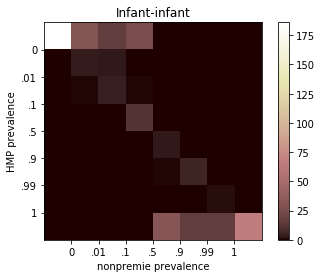

In [16]:
plt.imshow(prev_compare_matrix['II'], cmap='pink')
plt.title("Infant-infant")
plt.xlabel("nonpremie prevalence")
plt.xticks(derived_virtual_freqs[:-1]+0.5, derived_virtual_xticklabels)
plt.yticks(derived_virtual_freqs[:-1]+0.5, derived_virtual_xticklabels)
plt.ylabel("HMP prevalence")
plt.colorbar()
plt.show()

In [31]:
# dN/dS for SNPs that change in infants, that are absent in adults, assuming they’re all de novo

counts_dict = {vartype: 0 for vartype in variant_types}
opps_dict = {'1D': 0, '4D': 0}
qp_pairs_set = set()

desired_event_type = 'modification'

for species in snp_change_freqs:
    for sample_i, sample_j in snp_change_freqs[species]:
        
        tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        if tp_type != 'II':
            continue
        
        pdicts = snp_change_freqs_with_opps[species][(sample_i, sample_j)] # list of (vartype, freq_dict, opp_dict tuples)
        npdict = snp_change_null_freqs[species][(sample_i, sample_j)] # dict: prev_cohort > list of (freq, weight) tuples
        
        snp_change_val = snp_changes[species][(sample_i, sample_j)]
        
        nonsyn_diffs, nonsyn_opps, syn_diffs, syn_opps = dnds_info[species][(sample_i, sample_j)]
        
        if type(snp_change_val) == type(1):
            event_type = 'replacement'
        elif len(snp_change_val) > 0 and len(snp_change_val) <= modification_difference_threshold:
            event_type = 'modification'
        else:
            continue
        
        if event_type != desired_event_type:
            continue
        
        # Check for each SNP change if derived allele absent in adults        
        for vartype, fdict, opp_dict in pdicts:
            f = fdict['hmp']
            f_idx = get_f_idx(f)
            
            if f_idx == 0 and get_f_idx(fdict['nonpremie']) != 0:
                counts_dict[vartype] += 1
                opps_dict['1D'] += nonsyn_opps
                opps_dict['4D'] += syn_opps
                qp_pairs_set.add((sample_i, sample_j, species))

# Opportunities per prevalence bin summed over QP pairs instead of SNP changes
opps_dict_alt = {'1D': 0, '4D': 0}

for qp_pair in qp_pairs_set:
    sample_i, sample_j, species = qp_pair
    nonsyn_diffs, nonsyn_opps, syn_diffs, syn_opps = dnds_info[species][(sample_i, sample_j)]
    opps_dict_alt['1D'] += nonsyn_opps
    opps_dict_alt['4D'] += syn_opps

In [32]:
# dN/dS
dNdS = (counts_dict['1D']/opps_dict_alt['1D'])/(counts_dict['4D']/opps_dict_alt['4D'])
print(counts_dict['1D'])
print(counts_dict['4D'])
print(dNdS)

33
20
0.4226587927684554


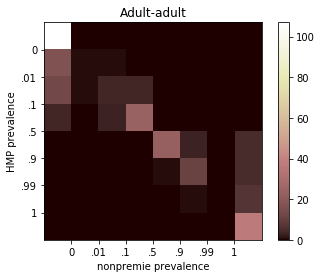

In [76]:
plt.imshow(prev_compare_matrix['AA'], cmap='pink')
plt.title("Adult-adult")
plt.xlabel("nonpremie prevalence")
plt.xticks(derived_virtual_freqs[:-1]+0.5, derived_virtual_xticklabels)
plt.yticks(derived_virtual_freqs[:-1]+0.5, derived_virtual_xticklabels)
plt.ylabel("HMP prevalence")
plt.colorbar()
plt.show()

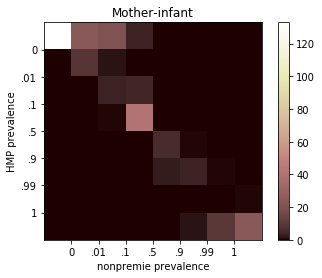

In [77]:
plt.imshow(prev_compare_matrix['MI'], cmap='pink')
plt.title("Mother-infant")
plt.xlabel("nonpremie prevalence")
plt.xticks(derived_virtual_freqs[:-1]+0.5, derived_virtual_xticklabels)
plt.yticks(derived_virtual_freqs[:-1]+0.5, derived_virtual_xticklabels)
plt.ylabel("HMP prevalence")
plt.colorbar()
plt.show()

In [80]:
# Heatmap of how SNP changes change from MOTHER prev to infant prev

desired_event_type = 'modification'
tp_types = ['II', 'MI', 'AA']
prev_cohorts = ['nonpremie', 'mother']
variant_types = ['4D', '1D', '2D', '3D']

# List of (mother_f_idx, nonpremie_f_idx, weight) tuples for each SNP change
prev_compare_distribution = {tp_type: [] for tp_type in tp_types}
null_prev_compare_distribution = {tp_type: [] for tp_type in tp_types}

for species in snp_change_freqs:
    for sample_i, sample_j in snp_change_freqs[species]:
        
        tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        if tp_type not in tp_types:
            continue
        
        pdicts = snp_change_freqs_with_opps[species][(sample_i, sample_j)] # list of (vartype, freq_dict, opp_dict tuples)
        npdict = snp_change_null_freqs[species][(sample_i, sample_j)] # dict: prev_cohort > list of (freq, weight) tuples
        
        snp_change_val = snp_changes[species][(sample_i, sample_j)]
        
        if type(snp_change_val) == type(1):
            event_type = 'replacement'
        elif len(snp_change_val) > 0 and len(snp_change_val) <= modification_difference_threshold:
            event_type = 'modification'
        else:
            continue
        
        if event_type != desired_event_type:
            continue
        
        '''
        
        for tup1, tup2 in zip(npdict['hmp'], npdict['nonpremie']):
            f1, weight1 = tup1; f2, weight2 = tp2
            f1_idx = get_f_idx(f1); f2_idx = get_f_idx(f2)
            null_prev_compare_distribution[tp_type].append((f1_idx, f2_idx, weight))
        '''
        
        # Loop over SNP changes
        for vartype, fdict, opp_dict in pdicts:
            prev_compare_distribution[tp_type].append((get_f_idx(fdict['mother']), get_f_idx(fdict['nonpremie']), 1))

prev_compare_matrix = {tp_type: np.zeros((len(derived_virtual_freqs), len(derived_virtual_freqs))) for tp_type in tp_types}

for tp_type in tp_types:
    
    for f_idx_mother, f_idx_nonpremie, weight in prev_compare_distribution[tp_type]:        
        # Mother idx selects the row, nonpremie selects column        
        prev_compare_matrix[tp_type][f_idx_mother][f_idx_nonpremie] += weight

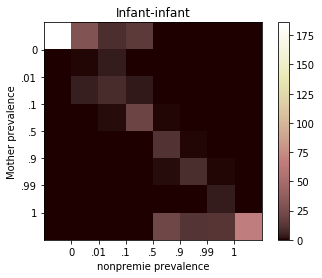

In [85]:
plt.imshow(prev_compare_matrix['II'], cmap='pink')
plt.title("Infant-infant")
plt.xlabel("nonpremie prevalence")
plt.xticks(derived_virtual_freqs[:-1]+0.5, derived_virtual_xticklabels)
plt.yticks(derived_virtual_freqs[:-1]+0.5, derived_virtual_xticklabels)
plt.ylabel("Mother prevalence")
plt.colorbar()
plt.show()

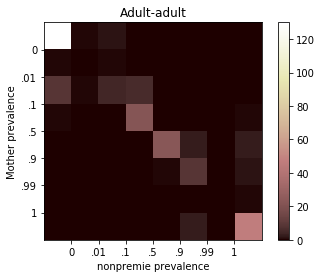

In [84]:
plt.imshow(prev_compare_matrix['AA'], cmap='pink')
plt.title("Adult-adult")
plt.xlabel("nonpremie prevalence")
plt.xticks(derived_virtual_freqs[:-1]+0.5, derived_virtual_xticklabels)
plt.yticks(derived_virtual_freqs[:-1]+0.5, derived_virtual_xticklabels)
plt.ylabel("Mother prevalence")
plt.colorbar()
plt.show()

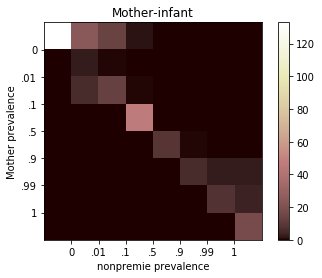

In [83]:
plt.imshow(prev_compare_matrix['MI'], cmap='pink')
plt.title("Mother-infant")
plt.xlabel("nonpremie prevalence")
plt.xticks(derived_virtual_freqs[:-1]+0.5, derived_virtual_xticklabels)
plt.yticks(derived_virtual_freqs[:-1]+0.5, derived_virtual_xticklabels)
plt.ylabel("Mother prevalence")
plt.colorbar()
plt.show()

In [ ]:
# Investigate SNP prevalence ideas

# 1) Do SNPs that change in infants typically have intermediate prevalence in infants but are rare/common in adults?

desired_event_type = 'modification'
tp_types = ['II', 'MI', 'AA']
prev_cohorts = ['nonpremie', 'hmp']
variant_types = ['4D', '1D', '2D', '3D']

prev_distribution = {prev_cohort: {tp_type: {variant_type: np.zeros(len(derived_virtual_freqs)) for variant_type in variant_types} for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}
null_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(derived_virtual_freqs)) for tp_type in tp_types} 
                          for prev_cohort in prev_cohorts}

for species in snp_change_freqs:
    for sample_i, sample_j in snp_change_freqs[species]:
        
        tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        if tp_type not in tp_types:
            continue
        
        pdicts = snp_change_freqs[species][(sample_i, sample_j)] # list of (vartype, freq_dict tuples)
        npdict = snp_change_null_freqs[species][(sample_i, sample_j)] # dict: prev_cohort > list of (freq, weight) tuples
        snp_change_val = snp_changes[species][(sample_i, sample_j)]
        
        if type(snp_change_val) == type(1):
            event_type = 'replacement'
        elif len(snp_change_val) > 0 and len(snp_change_val) <= modification_difference_threshold:
            event_type = 'modification'
        else:
            continue
        
        if event_type != desired_event_type:
            continue
        
        for prev_cohort in prev_cohorts:
            for f, weight in npdict[prev_cohort]:
                f_idx = get_f_idx(f)
                null_prev_distribution[prev_cohort][tp_type][f_idx] += weight
        
        for vartype, fdict in pdicts:
            for prev_cohort in prev_cohorts:
                f = fdict[prev_cohort]
                f_idx = get_f_idx(f)
                prev_distribution[prev_cohort][tp_type][vartype][f_idx] += 1

In [15]:
# Do suspected de novo mutations in infants revert within hosts?

# subject -> species -> (day1, day2) -> list of SNP change tuples OR 'replacement'
host_snp_changes = defaultdict(dict)
# subject -> species -> (day1, day2) -> list of (vartype, fdict) tuples OR 'replacement
host_snp_changes_freqs = defaultdict(dict)

for species in snp_change_freqs:
    for sample_i, sample_j in snp_change_freqs[species]:
        
        tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        if tp_type != 'II': # if tp_type != 'MI' and tp_type != 'II': # Only look at mother-infant or infant-infant
            continue
        
        subject = sample_subject_map[sample_j][:-2] # Combine mother and infant subjects!
        day1, day2 = mi_sample_day_dict[sample_i], mi_sample_day_dict[sample_j]
        
        pdicts = snp_change_freqs_with_opps[species][(sample_i, sample_j)] # list of (vartype, freq_dict, opp_dict tuples)
        npdict = snp_change_null_freqs[species][(sample_i, sample_j)] # dict: prev_cohort > list of (freq, weight) tuples
        
        snp_change_val = snp_changes[species][(sample_i, sample_j)]
        
        nonsyn_diffs, nonsyn_opps, syn_diffs, syn_opps = dnds_info[species][(sample_i, sample_j)]
        
        if type(snp_change_val) == type(1): # Replacement
            try:
                host_snp_changes[subject][species][(day1, day2, tp_type)] = 'replacement'
            except:
                host_snp_changes[subject][species] = {(day1, day2, tp_type): 'replacement'}
        else:
            try:
                host_snp_changes[subject][species][(day1, day2, tp_type)] = snp_changes[species][(sample_i, sample_j)]
                host_snp_changes_freqs[subject][species][(day1, day2, tp_type)] = pdicts
            except:
                host_snp_changes[subject][species] = {(day1, day2, tp_type): snp_changes[species][(sample_i, sample_j)]}
                host_snp_changes_freqs[subject][species] = {(day1, day2, tp_type): pdicts}

In [16]:
num_host_species_pairs = 0
desired_host_species_sites = []

for subject in host_snp_changes:
    for species in host_snp_changes[subject]:        
        if len(host_snp_changes[subject][species].keys()) > 1:
            num_host_species_pairs += 1
            print("Subject: %s, Species: %s" % (subject, species))
            sites = []
            for day1, day2, tp_type in sorted(host_snp_changes[subject][species].keys(), key=lambda x: x[0]):
                print('\n%s Day %i to day %i' % (tp_type, day1, day2))
                snp_change_list = host_snp_changes[subject][species][(day1, day2, tp_type)]
                snp_change_freqs_list = host_snp_changes_freqs[subject][species][(day1, day2, tp_type)]
                for snp_change, x_snp_change_freqs in zip(snp_change_list, snp_change_freqs_list):
                    gene_id, contig, location, vartype, a1, d1, a2, d2 = snp_change
                    vartype2, freq_dict, opp_dict = x_snp_change_freqs
                    if vartype != vartype2:
                        print("Weird")
                    sites.append((gene_id, contig, location))
                    print("Site: %s,%s,%s\t| Vartype: %s" % (gene_id, contig, location, vartype))
                    print("\t%i %i %i %i | %.02f -> %.02f" % (a1, d1, a2, d2, float(a1)/d1, float(a2)/d2))
                    print("\tInfant prev: %.02f | HMP prev: %.02f | Mother prev: %.02f" % (freq_dict['nonpremie'], freq_dict['hmp'], freq_dict['mother']))
            desired_host_species_sites.append(([subject], species, sites))
            print("\n=============================================================================")

Subject: 29, Species: Bacteroides_fragilis_54507

II Day 3 to day 122
Site: 1339327.3.peg.2892,JGDJ01000201,74789	| Vartype: 4D
	13 377 130 138 | 0.03 -> 0.94
	Infant prev: -0.50 | HMP prev: -0.50 | Mother prev: -0.50
Site: 1339327.3.peg.4556,JGDJ01000269,13192	| Vartype: 1D
	10 170 67 70 | 0.06 -> 0.96
	Infant prev: -0.50 | HMP prev: -0.50 | Mother prev: -0.50
Site: 1339327.3.peg.5145,JGDJ01000293,53164	| Vartype: 4D
	23 440 103 107 | 0.05 -> 0.96
	Infant prev: 0.04 | HMP prev: 0.03 | Mother prev: 0.07
Site: 1339327.3.peg.1541,JGDJ01000150,27046	| Vartype: 2D
	22 467 91 95 | 0.05 -> 0.96
	Infant prev: -0.50 | HMP prev: -0.50 | Mother prev: -0.50

II Day 122 to day 366
Site: 1339327.3.peg.3251,JGDJ01000227,42575	| Vartype: 1D
	0 123 23 23 | 0.00 -> 1.00
	Infant prev: -0.50 | HMP prev: -0.50 | Mother prev: -0.50

Subject: M0806, Species: Bacteroides_vulgatus_57955

II Day 30 to day 61
Site: 435590.9.peg.1499,NC_009614,1915720	| Vartype: 1D
	0 31 28 35 | 0.00 -> 0.80
	Infant prev: -0.50 

In [18]:
desired_host_species_sites

[(['29'],
  'Bacteroides_fragilis_54507',
  [('1339327.3.peg.2892', 'JGDJ01000201', 74789L),
   ('1339327.3.peg.4556', 'JGDJ01000269', 13192L),
   ('1339327.3.peg.5145', 'JGDJ01000293', 53164L),
   ('1339327.3.peg.1541', 'JGDJ01000150', 27046L),
   ('1339327.3.peg.3251', 'JGDJ01000227', 42575L)]),
 (['M0806'],
  'Bacteroides_vulgatus_57955',
  [('435590.9.peg.1499', 'NC_009614', 1915720L),
   ('435590.9.peg.1499', 'NC_009614', 1915720L)]),
 (['3'],
  'Bifidobacterium_catenulatum_58257',
  [('566552.4.peg.96', 'NZ_ABXY01000001', 124565L),
   ('566552.4.peg.96', 'NZ_ABXY01000001', 124565L)]),
 (['A00021_T2'],
  'Enterococcus_faecium_56710',
  [('1352.382.peg.338', 'JRJW01000028', 539L),
   ('1352.382.peg.813', 'JRJW01000067', 4580L),
   ('1352.382.peg.900', 'JRJW01000071', 6135L),
   ('1352.382.peg.900', 'JRJW01000071', 6132L)]),
 (['67'],
  'Bacteroides_fragilis_54507',
  [('1339327.3.peg.4421', 'JGDJ01000264', 9480L),
   ('1339327.3.peg.4421', 'JGDJ01000264', 9480L)]),
 (['M0901'],
  '

In [16]:
# Do gene gains/losses in infants revert within hosts?

# subject -> species -> (day1, day2) -> list of SNP change tuples OR 'replacement'
host_gene_changes = defaultdict(dict)

for species in gene_changes:
    for sample_i, sample_j in gene_changes[species]:
        
        tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        if tp_type != 'MI' and tp_type != 'II': # Only look at mother-infant or infant-infant
            continue
        
        subject = sample_subject_map[sample_j][:-2] # Combine mother and infant subjects!
        day1, day2 = mi_sample_day_dict[sample_i], mi_sample_day_dict[sample_j]
        
        gains_val, losses_val = gene_changes[species][(sample_i, sample_j)]
        
        if type(gains_val) == type(1): # Replacement
            try:
                host_gene_changes[subject][species][(day1, day2, tp_type)] = (gains_val, losses_val)
            except:
                host_gene_changes[subject][species] = {(day1, day2, tp_type): (gains_val, losses_val)}
        else:
            try:
                host_gene_changes[subject][species][(day1, day2, tp_type)] = (gains_val, losses_val)
            except:
                host_gene_changes[subject][species] = {(day1, day2, tp_type): (gains_val, losses_val)}

In [26]:
num_host_species_pairs = 0

for subject in host_gene_changes:
    for species in host_gene_changes[subject]:
        
        # Only look at hosts that have at least 1 gene change in each of two timepoints
        all_total_gene_changes = []
        for day1, day2, tp_type in host_gene_changes[subject][species]:
            gains_val, losses_val = host_gene_changes[subject][species][(day1, day2, tp_type)]
            total_gene_changes = 0
            if type(gains_val) == type(1):
                total_gene_changes += gains_val
            else:
                total_gene_changes += len(gains_val)
            if type(losses_val) == type(1):
                total_gene_changes += losses_val
            else:
                total_gene_changes += len(losses_val)
            all_total_gene_changes.append(total_gene_changes)
        
        num_nonzero_gene_changes = 0
        for num in all_total_gene_changes:
            if num > 0:
                num_nonzero_gene_changes += 1
        if num_nonzero_gene_changes < 2:
            continue
        
        if len(host_gene_changes[subject][species].keys()) > 1:
            num_host_species_pairs += 1
            print("Subject: %s, Species: %s" % (subject, species))
            for day1, day2, tp_type in sorted(host_gene_changes[subject][species].keys(), key=lambda x: x[0]):
                print('\n%s Day %i to day %i' % (tp_type, day1, day2))
                gains_val, losses_val = host_gene_changes[subject][species][(day1, day2, tp_type)]
                if type(gains_val) == type(1):
                    print("Gene gains: %i" % gains_val)
                else:
                    for gene_change in gains_val:
                        gene_id, a1, d1, a2, d2 = gene_change
                        print("Gene gain: %s" % (gene_id))
                        print("\t%i %i %i %i | %.02f -> %.02f" % (a1, d1, a2, d2, float(a1)/d1, float(a2)/d2))
                if type(losses_val) == type(1):
                    print("Gene losses: %i" % losses_val)
                else:
                    for gene_change in losses_val:
                        gene_id, a1, d1, a2, d2 = gene_change
                        print("Gene loss: %s" % (gene_id))
                        print("\t%i %i %i %i | %.02f -> %.02f" % (a1, d1, a2, d2, float(a1)/d1, float(a2)/d2))
            print("\n=============================================================================")

Subject: M0305, Species: Bacteroides_uniformis_57318

MI Day 0 to day 30
Gene loss: 997890.3.peg.4158
	45 57 0 107 | 0.80 -> 0.00

MI Day 0 to day 14
Gene loss: 997890.3.peg.4158
	45 57 0 115 | 0.80 -> 0.00

II Day 14 to day 30

MI Day 92 to day 30

MI Day 92 to day 14

Subject: C01758, Species: Escherichia_coli_58110

MI Day 1 to day 21

MI Day 1 to day 311
Gene gains: 428
Gene losses: 589

II Day 21 to day 311
Gene gains: 444
Gene losses: 580

Subject: A01803, Species: Escherichia_coli_58110

II Day 4 to day 21
Gene gain: 1116095.3.peg.72
	16 339 105 159 | 0.05 -> 0.66
Gene gain: 1281256.3.peg.21
	13 339 114 159 | 0.04 -> 0.72
Gene gain: 1444174.3.peg.1729
	16 339 116 159 | 0.05 -> 0.73
Gene gain: 562.5369.peg.3705
	14 339 107 159 | 0.04 -> 0.68

II Day 21 to day 256
Gene gain: 1069495.4.peg.4295
	0 159 50 73 | 0.00 -> 0.69
Gene gain: 1069495.4.peg.4297
	0 159 46 73 | 0.00 -> 0.63
Gene gain: 1069495.4.peg.4298
	0 159 45 73 | 0.00 -> 0.61
Gene gain: 1444231.3.peg.4086
	0 159 44 73 | 0

In [27]:
num_host_species_pairs

35

In [21]:
# Do sweeping alleles in infants exist in mothers?
# Plan: Remake snp_changes but for each SNP change append to tuple
# alt, depth in mother, and only include modifications
# Also, just print stuff

infant_mod_snp_changes_with_mom_freq = {species: defaultdict(list) for species in snp_changes}

presence_threshold = 2

total_qp_pairs = 0
total_snp_changes = 0
missing = 0
present_mom = 0
absent_mom = 0

for species in snp_changes:
    for s1, s2 in snp_changes[species]:
        
        val = snp_changes[species][(s1, s2)]
        tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        
        # Temporary filter: only look at infant-infant (do not include mother-infant)
        if tp_type != 'II':
            continue
        
        # Only look at mothers and infants excluding olm
        cohort = sample_cohort_map[s1]
        if cohort not in ['backhed', 'ferretti', 'yassour', 'shao']:
            continue
        
        # Get mother subject
        subject = sample_subject_map[s2]
        
        if subject not in same_mi_pair_dict:
            continue # No data for infant's mother
        else:
            mother_subject = same_mi_pair_dict[subject]
            this_mother_samples = subject_sample_map[mother_subject].keys()
        
        # Pick mother sample at latest previous timepoint if there are multiple
        day1, day2 = mi_sample_day_dict[s1], mi_sample_day_dict[s2]
        day = day1 if tp_type == 'II' else day2
        
        reference_mother_day = -99999
        for mother_sample in this_mother_samples:
            try:
                mother_day = mi_sample_day_dict[mother_sample]
            except:
                continue # Probably Ferretti non-fecal sample
            if mother_day > reference_mother_day and mother_day <= day:
                reference_mother_day = mother_day
                reference_mother_sample = mother_sample
        
        if reference_mother_day == -99999:
            continue # No previous mother timepoint
        
        if type(val) == type([]): # Modification or no change event
            
            if len(val) > 0: # Modification event
                total_qp_pairs += 1
                # Print QP pair info
                if tp_type == 'II':
                    print("QP pair: Infant day %s\t> Infant day %s  \t| Reference Mother day %s" % (day1, day2, reference_mother_day))
                elif tp_type == 'MI':
                    print("QP pair: Mother day %s\t> Infant day %s  \t| Reference Mother day %s" % (day1, day2, reference_mother_day))
            
            for snp_change, snp_change_freq in zip(val, snp_change_freqs[species][(s1, s2)]):
                gene_name, contig, position, variant_type, A1, D1, A2, D2 = snp_change
                site_tuple = (contig, position, gene_name)
                
                # Filter out sites based on prevalence
                vartype2, freq_dict = snp_change_freq
                
                if freq_dict['nonpremie'] >= 0.5: # Only include alleles that are low prevalence in infants
                    continue
                
                total_snp_changes += 1
                
                # Print basic info about SNP change
                print("\t%s|%s|%s\t%i/%i > %i/%i" % (contig, position, variant_type, A1, D1, A2, D2))
                
                if site_tuple in species_allele_counts_map[species][mother_sample]:
                    mom_alt, mom_depth = species_allele_counts_map[species][mother_sample][site_tuple]
                    infant_mod_snp_changes_with_mom_freq[species][(s1, s2)].append((gene_name, contig, position, variant_type, A1, D1, A2, D2, (mom_alt, mom_depth)))
                    
                    print("\tMom: %i/%i" % (mom_alt, mom_depth))
                    
                    if (float(A1)/D1) < (float(A2)/D2): # Alternate allele is sweeping allele
                        if mom_depth <= 0 or mom_alt <= presence_threshold: # Alternate allele absent in mom
                            absent_mom += 1
                        else:
                            present_mom += 1
                    elif (float(A1)/D1) > (float(A2)/D2): # Reference allele is sweeping allele
                        if mom_depth <= 0 or mom_alt <= presence_threshold: # Reference allele is present in mom
                            present_mom += 1
                        else:
                            absent_mom += 1
                else:
                    print("\tMissing site info for mom")
                    missing += 1 # Site info missing for this mom

QP pair: Infant day 122	> Infant day 366  	| Reference Mother day 2
	NZ_DS362225|9460|1D	0/45 > 92/92
	Mom: 0/46
	NZ_DS362220|172421|1D	0/22 > 107/107
	Mom: 0/176
QP pair: Infant day 3	> Infant day 122  	| Reference Mother day 2
	NZ_DS362247|351526|1D	0/411 > 19/20
	Mom: 0/31
	NZ_DS362249|325333|1D	0/478 > 30/32
	Mom: 0/171
QP pair: Infant day 122	> Infant day 366  	| Reference Mother day 2
	NZ_DS362240|51720|4D	0/62 > 54/56
	Mom: 0/168
	NZ_DS362240|82813|1D	0/45 > 29/34
	Mom: 0/51
	NZ_DS362244|257208|1D	0/50 > 17/18
	Mom: 0/84
	NZ_DS362236|10519|1D	0/41 > 39/46
	Mom: 0/102
	NZ_DS362236|50287|1D	0/56 > 50/54
	Mom: 0/0
	NZ_DS362248|33708|1D	0/61 > 21/22
	Mom: 0/0
	NZ_DS362246|294247|4D	0/62 > 12/15
	Mom: 0/92
	NZ_DS362248|212100|1D	0/56 > 38/42
	Mom: 0/0
	NZ_DS362249|491800|1D	0/66 > 24/29
	Mom: 0/0
QP pair: Infant day 61	> Infant day 92  	| Reference Mother day 0
	NZ_DS362247|352618|1D	0/118 > 257/291
	Missing site info for mom
	NZ_DS362234|36335|1D	0/101 > 211/236
	Missing site info f

In [22]:
print("Total QP pairs: %s" % (total_qp_pairs))
print("Total SNP changes: %s" % (total_snp_changes))
print("Total missing mom site info: %s" % (missing))
print("Total present in mom: %s" % (present_mom))
print("Total absent in mom: %s" % (absent_mom))

Total QP pairs: 84
Total SNP changes: 163
Total missing mom site info: 58
Total present in mom: 4
Total absent in mom: 101


In [23]:
print("Proportion of infant sweeping alleles observed in mothers: %.02f" % (present_mom/float(total_snp_changes)))

Proportion of infant sweeping alleles observed in mothers: 0.02


In [36]:
4/219.0

0.0182648401826484

In [27]:
# Alternate print
print("%i qpp, %i snp changes" % (total_qp_pairs, total_snp_changes))
print("%i present" % (present_mom))
print("%i absent" % (absent_mom))
print("%i missing mom data" % (missing))

84 qpp, 163 snp changes
8 present
97 absent
58 missing mom data


In [11]:
# Gene change prevalence

prev_cohorts = ['hmp', 'infant'] # TODO: update gene freq calculation to use nonpremie instead of infnat

fig, gene_prev_axis = plt.subplots(figsize=(7,4))

gene_prev_axis.spines['top'].set_visible(False)
gene_prev_axis.spines['right'].set_visible(False)
gene_prev_axis.get_xaxis().tick_bottom()
gene_prev_axis.get_yaxis().tick_left() 
gene_prev_axis.set_xlabel('Gene prevalence across hosts')
gene_prev_axis.set_ylabel('# gene changes')
gene_prev_axis.set_xlim([gene_freq_xticks[0],gene_freq_xticks[-1]])
gene_prev_axis.set_xticks(gene_freq_xticks)
gene_prev_axis.set_xticklabels(gene_freq_xticklabels)
gene_prev_axis.plot([0,0],[100,100],'k-')

total_freq_gains = {prev_cohort: (np.zeros(len(gene_freq_bins)-1)*1.0) for prev_cohort in prev_cohorts}
total_freq_losses = {prev_cohort: (np.zeros(len(gene_freq_bins)-1)*1.0) for prev_cohort in prev_cohorts}
total_null_freq_losses = {prev_cohort: (np.zeros(len(gene_freq_bins)-1)*1.0) for prev_cohort in prev_cohorts}

for species in gene_gain_freqs:
    for sample_i, sample_j in gene_gain_freqs[species]:
        tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
        xtp_type = tp_pair_to_tp_type(tp_pair)
        if xtp_type != 'AA':
            continue
        for gene_gain_freq_dict in gene_gain_freqs[species][(sample_i, sample_j)]:
            for prev_cohort in gene_gain_freq_dict:
                f = gene_gain_freq_dict[prev_cohort]
                f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                total_freq_gains[prev_cohort][f_idx] += 1

for species in gene_loss_freqs:
    for sample_i, sample_j in gene_loss_freqs[species]:
        tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
        xtp_type = tp_pair_to_tp_type(tp_pair)
        if xtp_type != 'AA':
            continue
        for gene_loss_freq_dict in gene_loss_freqs[species][(sample_i, sample_j)]:
            for prev_cohort in gene_loss_freq_dict:
                f = gene_loss_freq_dict[prev_cohort]
                f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                total_freq_losses[prev_cohort][f_idx] += 1

num_bootstraps = 10
'''
for species in gene_loss_null_freqs:
    for sample_i, sample_j in gene_loss_null_freqs[species]:
        tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
        xtp_type = tp_pair_to_tp_type(tp_pair)
        if xtp_type != 'AA':
            continue
        for gene_loss_null_freq_dict in gene_loss_null_freqs[species][(sample_i, sample_j)]:
            for prev_cohort in gene_loss_null_freq_dict:
                bootstrapped_fs = gene_loss_null_freq_dict[prev_cohort]
                f = (sum(bootstrapped_fs)/float(num_bootstraps))
                f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                total_null_freq_losses[prev_cohort][f_idx] += 1
'''

for species in gene_loss_null_freqs:
	for sample_i, sample_j in gene_loss_null_freqs[species]:
		# Only plot infant-infant here
		if not(sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm):
			continue
		for f_dict in gene_loss_null_freqs[species][(sample_i, sample_j)]:
			if prev_cohort not in f_dict:
				continue # ??? TODO
			for f in f_dict[prev_cohort]:
				f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
				total_null_freq_losses[f_idx] += (1.0/num_bootstraps)

gene_prev_axis.set_title('AA, prev cohort HMP')
gene_prev_axis.bar(gene_gain_virtual_freqs, total_freq_gains['hmp'],width=0.3,linewidth=0,facecolor='#b3de69',label='gain')
gene_prev_axis.bar(gene_loss_virtual_freqs, total_freq_losses['hmp'],width=0.3,linewidth=0, facecolor='#ff7f00',label='loss')
gene_prev_axis.bar(gene_loss_virtual_freqs-0.3, total_null_freq_losses['hmp'],width=0.3,linewidth=0, facecolor='0.7',label='de novo\nexpectation')
plt.show()
# fig.savefig('%s/gene_change_prevalence_II_no_olm.pdf' % (config.analysis_directory),bbox_inches='tight')

KeyError: 2

In [37]:
total_freq_losses['hmp']

array([11., 30., 31.,  5.])

In [12]:
gene_loss_prev_distribution

NameError: name 'gene_loss_prev_distribution' is not defined

In [19]:
tp_types = ['II', 'MI', 'AA']

gene_gain_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(gene_gain_virtual_freqs)) for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}
gene_loss_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(gene_loss_virtual_freqs)) for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}
gene_loss_null_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(gene_loss_virtual_freqs)) for tp_type in tp_types} 
                          for prev_cohort in prev_cohorts}

gain_qp_pairs = []
loss_qp_pairs = []

# Note: sometimes gene_gain_freqs[species][(sample_i, sample_j)]
# (or gene_loss_freqs) will not have full set of prev cohorts
# because when the data is being pickled,
# it loops over prev_cohort keys in gene_freq_map
# which is generated for each species and will exclude a prev_cohort
# if gene_freqs returned by core_gene_utils.parse_gene_freqs has length 0
# which will happen if the file doesn't exist or it's just empty
# Indeed, number of species with gene_freqs information is halved
# in hmp/prev_hmp compared to infant/prev_infant

for species in gene_gain_freqs:
    for sample_i, sample_j in gene_gain_freqs[species]:
        
        tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        if tp_type not in tp_types:
            continue
        
        gain_qp_pairs.append((species, sample_i, sample_j))
        
        for gene_gain_freq_dict in gene_gain_freqs[species][(sample_i, sample_j)]:
            for prev_cohort in gene_gain_freq_dict:
                f = gene_gain_freq_dict[prev_cohort]
                f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                gene_gain_prev_distribution[prev_cohort][tp_type][f_idx] += 1


for species in gene_loss_freqs:
    for sample_i, sample_j in gene_loss_freqs[species]:
        
        tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        if tp_type not in tp_types:
            continue
        
        loss_qp_pairs.append((species, sample_i, sample_j))
        
        for gene_loss_freq_dict in gene_loss_freqs[species][(sample_i, sample_j)]:
            for prev_cohort in gene_loss_freq_dict:
                f = gene_loss_freq_dict[prev_cohort]
                f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                gene_loss_prev_distribution[prev_cohort][tp_type][f_idx] += 1
        
        num_bootstraps = 10
        
        for gene_loss_null_freq_dict in gene_loss_null_freqs[species][(sample_i, sample_j)]:
            for prev_cohort in gene_loss_null_freq_dict:
                bootstrapped_fs = gene_loss_null_freq_dict[prev_cohort]
                f = (sum(bootstrapped_fs)/float(num_bootstraps))
                f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                gene_loss_null_prev_distribution[prev_cohort][tp_type][f_idx] += 1

In [17]:
# More QP pairs are in gene_loss_freqs
# Right... it's just because if there are no gains, for example,
# the QP pair will be excluded entirely
print(len(gain_qp_pairs))
print(len(loss_qp_pairs))

156
190


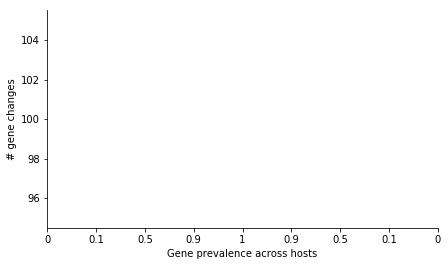

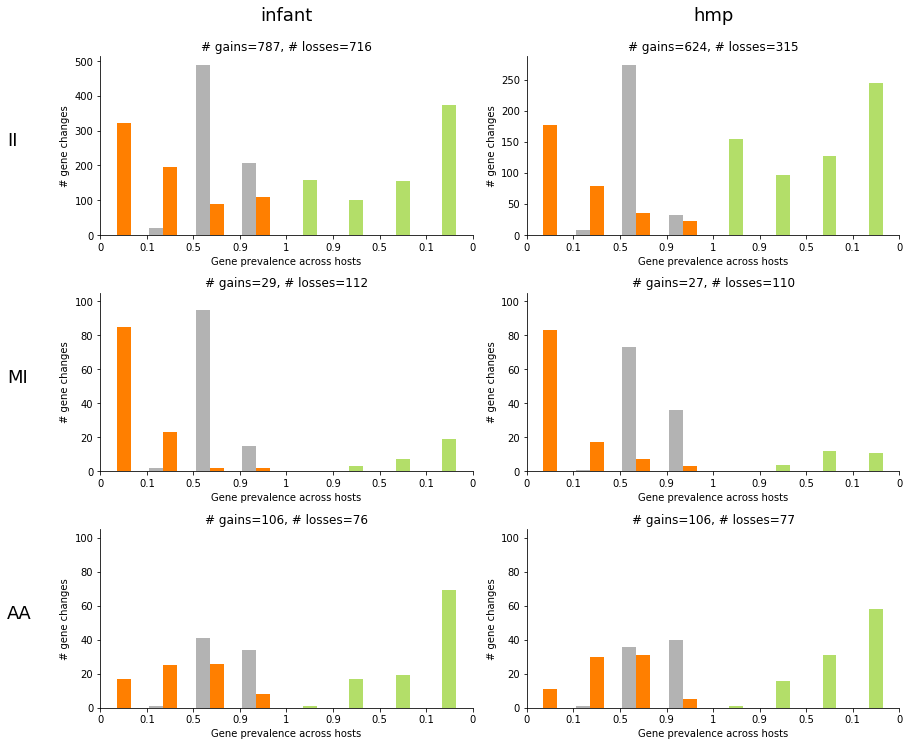

In [18]:
fig, ax = plt.subplots(3, 2, figsize=(12, 10)) # sharey='row' # originally (12, 10) for 3 x 2
colors = {'1D': 'orange', '4D': 'green', '2D': 'brown', '3D': 'maroon'}

i=0
event_type = 'modification'

tp_types = ['II', 'MI', 'AA']
prev_cohorts = ['infant', 'hmp']

for tp_type in tp_types:
    j = 0
    for prev_cohort in prev_cohorts:
        
        ax[i][j].spines['top'].set_visible(False); ax[i][j].spines['right'].set_visible(False)
        ax[i][j].get_xaxis().tick_bottom(); ax[i][j].get_yaxis().tick_left() 
        ax[i][j].set_xlabel('Gene prevalence across hosts')
        ax[i][j].set_ylabel('# gene changes')
        ax[i][j].set_xlim([gene_freq_xticks[0],gene_freq_xticks[-1]])
        ax[i][j].set_xticks(gene_freq_xticks)
        ax[i][j].set_xticklabels(gene_freq_xticklabels)
        ax[i][j].plot([0,0],[100,100],'k-')
        
        ax[i][j].bar(gene_gain_virtual_freqs, gene_gain_prev_distribution[prev_cohort][tp_type],
                     width=0.3,linewidth=0,facecolor='#b3de69',label='gain')
        ax[i][j].bar(gene_loss_virtual_freqs, gene_loss_prev_distribution[prev_cohort][tp_type],
                     width=0.3,linewidth=0, facecolor='#ff7f00',label='loss')
        ax[i][j].bar(gene_loss_virtual_freqs-0.3, gene_loss_null_prev_distribution[prev_cohort][tp_type],
                     width=0.3,linewidth=0, facecolor='0.7',label='de novo\nexpectation')
        
        ax[i][j].set_title("# gains=%i, # losses=%i" % (sum(gene_gain_prev_distribution[prev_cohort][tp_type]), 
                                                        sum(gene_loss_prev_distribution[prev_cohort][tp_type])))
        if j == 0:
            ax[i][j].text(-0.25, 0.5, tp_type, fontsize=18, transform=ax[i][j].transAxes)
        if i == 0:
            ax[i][j].text(0.5, 1.2, prev_cohort, ha='center', fontsize=18, transform=ax[i][j].transAxes)
        
        j += 1
    i += 1

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()
plt.show()
# fig.savefig('%s/modification_snp_prevs_%s.pdf' % (config.analysis_directory, sweep_type))

In [22]:
gene_gain_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(gene_gain_virtual_freqs)) for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}
gene_loss_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(gene_loss_virtual_freqs)) for tp_type in tp_types}
                     for prev_cohort in prev_cohorts}
gene_loss_null_prev_distribution = {prev_cohort: {tp_type: np.zeros(len(gene_loss_virtual_freqs)) for tp_type in tp_types} 
                          for prev_cohort in prev_cohorts}

for prev_cohort in prev_cohorts:
    for desired_tp_type in tp_types:
        
        total_freq_gains = np.zeros(len(gene_freq_bins)-1)*1.0
        total_freq_losses = np.zeros(len(gene_freq_bins)-1)*1.0
        total_null_freq_losses = np.zeros(len(gene_freq_bins)-1)*1.0

        for species in gene_gain_freqs:
            for sample_i, sample_j in gene_gain_freqs[species]:
                tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
                tp_type = tp_pair_to_tp_type(tp_pair)
                if tp_type != desired_tp_type:
                    continue
                for f_dict in gene_gain_freqs[species][(sample_i, sample_j)]:
                    f = f_dict[prev_cohort] if prev_cohort in f_dict else 0
                    f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                    total_freq_gains[f_idx] += 1

        for species in gene_loss_freqs:
            for sample_i, sample_j in gene_loss_freqs[species]:
                tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
                tp_type = tp_pair_to_tp_type(tp_pair)
                if tp_type != desired_tp_type:
                    continue
                for f_dict in gene_loss_freqs[species][(sample_i, sample_j)]:
                    f = f_dict[prev_cohort] if prev_cohort in f_dict else 0
                    f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                    total_freq_losses[f_idx] += 1

        for species in gene_loss_null_freqs:
            for sample_i, sample_j in gene_loss_null_freqs[species]:
                tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
                tp_type = tp_pair_to_tp_type(tp_pair)
                if tp_type != desired_tp_type:
                    continue
                for f_dict in gene_loss_null_freqs[species][(sample_i, sample_j)]:
                    if prev_cohort not in f_dict:
                        continue # ??? TODO
                    for f in f_dict[prev_cohort]:
                        f_idx = ((f>gene_freq_bins[:-1])*(f<=gene_freq_bins[1:])).argmax()
                        total_null_freq_losses[f_idx] += (1.0/num_bootstraps)
            
        gene_gain_prev_distribution[prev_cohort][desired_tp_type] = total_freq_gains
        gene_loss_prev_distribution[prev_cohort][desired_tp_type] = total_freq_losses
        gene_loss_null_prev_distribution[prev_cohort][desired_tp_type] = total_null_freq_losses

716.0
716.0000000000309
716.0
314.999999999995
112.0
112.0000000000006
112.0
110.0000000000002
77.0
76.00000000000048
77.0
77.00000000000051


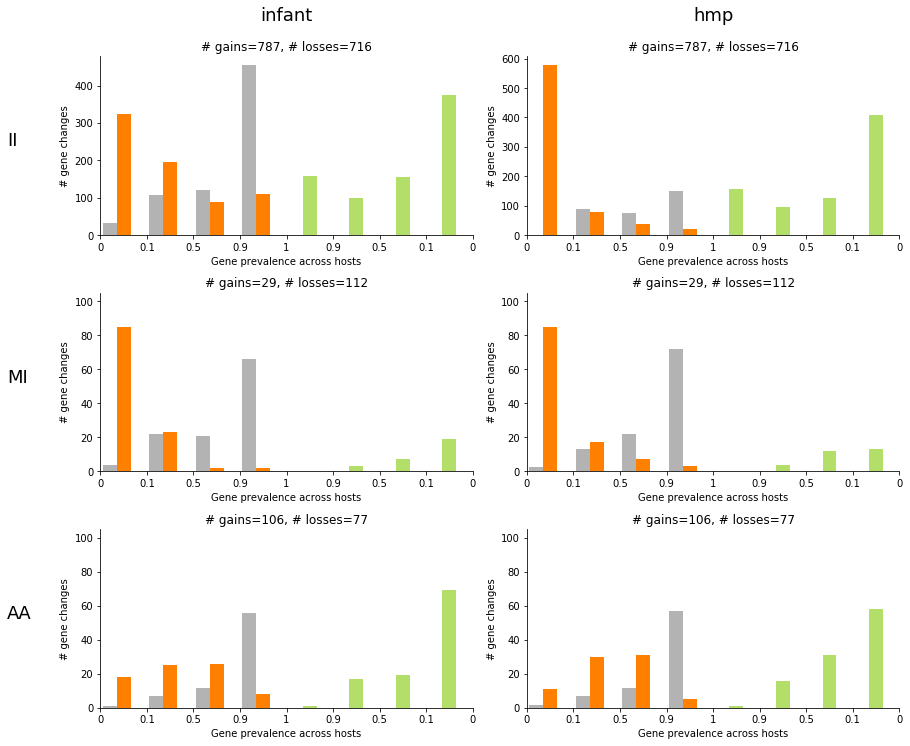

In [23]:
fig, ax = plt.subplots(3, 2, figsize=(12, 10)) # sharey='row' # originally (12, 10) for 3 x 2
colors = {'1D': 'orange', '4D': 'green', '2D': 'brown', '3D': 'maroon'}

i=0
event_type = 'modification'

tp_types = ['II', 'MI', 'AA']
prev_cohorts = ['infant', 'hmp']

for tp_type in tp_types:
    j = 0
    for prev_cohort in prev_cohorts:
        
        ax[i][j].spines['top'].set_visible(False); ax[i][j].spines['right'].set_visible(False)
        ax[i][j].get_xaxis().tick_bottom(); ax[i][j].get_yaxis().tick_left() 
        ax[i][j].set_xlabel('Gene prevalence across hosts')
        ax[i][j].set_ylabel('# gene changes')
        ax[i][j].set_xlim([gene_freq_xticks[0],gene_freq_xticks[-1]])
        ax[i][j].set_xticks(gene_freq_xticks)
        ax[i][j].set_xticklabels(gene_freq_xticklabels)
        ax[i][j].plot([0,0],[100,100],'k-')
        
        ax[i][j].bar(gene_gain_virtual_freqs, gene_gain_prev_distribution[prev_cohort][tp_type],
                     width=0.3,linewidth=0,facecolor='#b3de69',label='gain')
        ax[i][j].bar(gene_loss_virtual_freqs, gene_loss_prev_distribution[prev_cohort][tp_type],
                     width=0.3,linewidth=0, facecolor='#ff7f00',label='loss')
        ax[i][j].bar(gene_loss_virtual_freqs-0.3, gene_loss_null_prev_distribution[prev_cohort][tp_type],
                     width=0.3,linewidth=0, facecolor='0.7',label='de novo\nexpectation')
        
        print(sum(gene_loss_prev_distribution[prev_cohort][tp_type]))
        print(sum(gene_loss_null_prev_distribution[prev_cohort][tp_type]))
        
        ax[i][j].set_title("# gains=%i, # losses=%i" % (sum(gene_gain_prev_distribution[prev_cohort][tp_type]), 
                                                        sum(gene_loss_prev_distribution[prev_cohort][tp_type])))
        if j == 0:
            ax[i][j].text(-0.25, 0.5, tp_type, fontsize=18, transform=ax[i][j].transAxes)
        if i == 0:
            ax[i][j].text(0.5, 1.2, prev_cohort, ha='center', fontsize=18, transform=ax[i][j].transAxes)
        
        j += 1
    i += 1

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()
plt.show()
# fig.savefig('%s/modification_snp_prevs_%s.pdf' % (config.analysis_directory, sweep_type))

In [54]:
# Mother-infant: looks like there are more losses than gains.
# But in the rates plot, the gain rate is higher.
# What gives?

count_mi_dict = {'loss': 0, 'gain': 0}
gain_tups = []
loss_tups = []
days_mi = 0

for species in gene_changes:
    for sample_i, sample_j in gene_changes[species]:
                
        tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
        tp_type = tp_pair_to_tp_type(tp_pair)
        
        if tp_type == 'MI':
            
            # Condition on MI within first week
            '''
            if sample_j in infant_samples and mi_sample_day_dict[sample_j] > 7:
                continue
            if sample_i in infant_samples and mi_sample_day_dict[sample_i] > 7:
                continue
            '''
            days = sample_pair_to_days(sample_i, sample_j)
        
            gains, losses = gene_changes[species][(sample_i, sample_j)]
            if type(gains) == type(1): # Replacement
                pass
            else: # No change or modification
                count_mi_dict['gain'] += len(gains)
                count_mi_dict['loss'] += len(losses)
                days_mi += days
                gain_tups.append((len(gains), days))
                loss_tups.append((len(losses), days))

In [35]:
from utils import core_gene_utils
species_name = 'Bacteroides_vulgatus_57955'
x = core_gene_utils.parse_gene_freqs(species_name, prev_cohort='infant')

In [24]:
# Parallelism (for SNP changes) at site level

custom_cohorts_ordered = ['MI', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'II(other)', 'MM', 'AA']
variant_types = ['4D', '1D', '2D', '3D']

custom_cohort_tests = {}
custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples_no_olm)
# custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples_no_olm) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['Day 0-Week 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7))
custom_cohort_tests['Week 1-Month 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 7 and mi_sample_day_dict[sample_j] <= 31))
custom_cohort_tests['Month 1-Year 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 31 and mi_sample_day_dict[sample_j] <= 366))
custom_cohort_tests['II(other)'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm))
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)

# cohort -> site -> count of SNP changes
genes_by_cohort_agg = {cohort: defaultdict(int) for cohort in custom_cohorts_ordered}
# cohort -> site -> variant type -> count of SNP changes
genes_by_cohort = {cohort: {} for cohort in custom_cohorts_ordered}

# cohort -> site -> count of unique hosts
num_host_genes_by_cohort = {cohort: defaultdict(set) for cohort in custom_cohorts_ordered}

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:
        val = snp_changes[species][(sample_i, sample_j)]
        subject_tuple = (sample_subject_map[sample_i], sample_subject_map[sample_j])
        custom_cohort = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        if type(val) == type([]):
            for gene_id, contig, position, variant_type, A1, D1, A2, D2 in val:
                site = (gene_id, contig, position)
                if site == ('435590.9.peg.1738', 'NC_009614', 2160159L):
                    print(species)
                    print((sample_order_map[sample_i], sample_order_map[sample_j]))
                    print(val)
                if site == ('435590.9.peg.3037', 'NC_009614', 3742405L):
                    pass
                if site not in genes_by_cohort[custom_cohort]:
                    genes_by_cohort[custom_cohort][site] = {vartype: 0 for vartype in variant_types}
                genes_by_cohort[custom_cohort][site][variant_type] += 1
                genes_by_cohort_agg[custom_cohort][site] += 1
                num_host_genes_by_cohort[custom_cohort][site].add(subject_tuple)

Bacteroides_vulgatus_57955
(('20-M', 1), ('20-I', 2))
[('435590.9.peg.1738', 'NC_009614', 2160159L, '2D', 0.0, 63.0, 42.0, 42.0)]
Bacteroides_vulgatus_57955
(('20-I', 1), ('20-I', 2))
[('435590.9.peg.1738', 'NC_009614', 2160159L, '2D', 0.0, 88.0, 42.0, 42.0), ('435590.9.peg.1906', 'NC_009614', 2388971L, '4D', 53.0, 58.0, 4.0, 28.0)]
Bacteroides_vulgatus_57955
(('B02369-I', 7), ('B02369-I', 200.38500000000002))
[('435590.9.peg.1738', 'NC_009614', 2160159L, '2D', 1.0, 63.0, 28.0, 28.0)]
Bacteroides_vulgatus_57955
(('20-M', 1), ('20-I', 3))
[('435590.9.peg.1738', 'NC_009614', 2160159L, '2D', 0.0, 63.0, 138.0, 138.0)]


In [25]:
for custom_cohort in genes_by_cohort_agg:
    for site in genes_by_cohort_agg[custom_cohort]:
        count = genes_by_cohort_agg[custom_cohort][site]
        unique_hosts = num_host_genes_by_cohort[custom_cohort][site]
        if count > 1:
            print('%s | %s: %i SNP changes in %i hosts' % (custom_cohort, site, count, len(unique_hosts)))

MI | ('435590.9.peg.2509', 'NC_009614', 3117210L): 3 SNP changes in 1 hosts
MI | ('565040.3.peg.1727', 'NC_015052', 1972104L): 3 SNP changes in 1 hosts
MI | ('565040.3.peg.1727', 'NC_015052', 1972077L): 3 SNP changes in 1 hosts
MI | ('435590.9.peg.1197', 'NC_009614', 1552441L): 4 SNP changes in 1 hosts
MI | ('449673.7.peg.1768', 'NZ_DS499673', 535514L): 2 SNP changes in 1 hosts
MI | ('435590.9.peg.2142', 'NC_009614', 2683430L): 3 SNP changes in 1 hosts
MI | ('1137135.3.peg.3465', 'AHZD01000406', 1450L): 3 SNP changes in 1 hosts
MI | ('435590.9.peg.2119', 'NC_009614', 2654453L): 2 SNP changes in 1 hosts
MI | ('435590.9.peg.1324', 'NC_009614', 1712073L): 2 SNP changes in 1 hosts
MI | ('1339327.3.peg.2899', 'JGDJ01000204', 3609L): 2 SNP changes in 1 hosts
MI | ('435590.9.peg.543', 'NC_009614', 746526L): 4 SNP changes in 1 hosts
MI | ('565040.3.peg.1727', 'NC_015052', 1972092L): 3 SNP changes in 1 hosts
MI | ('565040.3.peg.1727', 'NC_015052', 1972078L): 3 SNP changes in 1 hosts
MI | ('1077

In [25]:
# Parallelism (for gene changes at ID level)

custom_cohorts_ordered = ['MI', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'II(other)', 'MM', 'AA']
variant_types = ['4D', '1D', '2D', '3D']

def custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j):
    for cohort in custom_cohort_tests:
        if custom_cohort_tests[cohort](sample_i, sample_j):
            return cohort

custom_cohort_tests = {}
custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples_no_olm)
# custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples_no_olm) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['Day 0-Week 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7))
custom_cohort_tests['Week 1-Month 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 7 and mi_sample_day_dict[sample_j] <= 31))
custom_cohort_tests['Month 1-Year 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 31 and mi_sample_day_dict[sample_j] <= 366))
custom_cohort_tests['II(other)'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm))
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)

# cohort -> gene ID -> variant type -> count of gene gains
gain_genes_by_cohort = {cohort: defaultdict(int) for cohort in custom_cohorts_ordered}

# cohort -> gene ID -> variant type -> count of gene gains
loss_genes_by_cohort = {cohort: defaultdict(int) for cohort in custom_cohorts_ordered}

# cohort -> gene ID -> count of unique hosts
gain_num_host_genes_by_cohort = {cohort: defaultdict(set) for cohort in custom_cohorts_ordered}
loss_num_host_genes_by_cohort = {cohort: defaultdict(set) for cohort in custom_cohorts_ordered}

for species in gene_changes:    
    for sample_i, sample_j in gene_changes[species]:
        
        gains, losses = gene_changes[species][(sample_i, sample_j)]
        subject_tuple = (sample_subject_map[sample_i], sample_subject_map[sample_j])
        custom_cohort = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        
        if type(gains) == type([]): # Modification event
            
            # Gains
            for gene_id, D1, Dm1, D2, Dm2 in gains:
                gain_genes_by_cohort[custom_cohort][gene_id] += 1
                gain_num_host_genes_by_cohort[custom_cohort][gene_id].add(subject_tuple)
            
            # Losses
            for gene_id, D1, Dm1, D2, Dm2 in losses:
                loss_genes_by_cohort[custom_cohort][gene_id] += 1
                loss_num_host_genes_by_cohort[custom_cohort][gene_id].add(subject_tuple)

In [28]:
gainloss_genes_by_cohort = {cohort: defaultdict(int) for cohort in custom_cohorts_ordered}

for cohort in custom_cohorts_ordered:
    combined_genes = set(gain_genes_by_cohort[cohort].keys() + loss_genes_by_cohort[cohort].keys())
    for gene in combined_genes:
        if gene not in gain_genes_by_cohort[cohort]:
            gain_genes_by_cohort[cohort][gene] = 0
        if gene not in loss_genes_by_cohort[cohort]:
            loss_genes_by_cohort[cohort][gene] = 0
        
        combined_gene_change_count = gain_genes_by_cohort[cohort][gene] + loss_genes_by_cohort[cohort][gene]
        
        gainloss_genes_by_cohort[cohort][gene] = combined_gene_change_count

In [29]:
# Store gene change annotation info in tabular form
    
for cat in custom_cohorts_ordered:
    
    f = open('%s/%s_gene_ID_change_parallelism.tsv' % (config.analysis_directory, cat.replace(' ', '_')), 'w')
    f.write('\t'.join(['num_change', 'num_gains', 'num_unique_hosts_gains', 'num_loss', 'num_unique_hosts_loss', 'gene ID']) + '\n')
    
    for gene, total_count in sorted(gainloss_genes_by_cohort[cat].items(), key=lambda x: x[1], reverse=True):
        
        num_gains = gain_genes_by_cohort[cat][gene]
        num_unique_hosts_gains = len(gain_num_host_genes_by_cohort[cat][gene])
        num_loss = loss_genes_by_cohort[cat][gene]
        num_unique_hosts_loss = len(loss_num_host_genes_by_cohort[cat][gene])
        
        f.write('\t'.join([str(x) for x in [total_count, num_gains, num_unique_hosts_gains, num_loss, num_unique_hosts_loss, gene]]) + '\n')
    f.close()

In [33]:
sorted(gain_genes_by_cohort['AA'].items(), key=lambda x: x[1], reverse=True)

[('445970.5.peg.1209', 2),
 ('445970.5.peg.899', 1),
 ('1339352.3.peg.2990', 1),
 ('997892.3.peg.598', 1),
 ('742726.3.peg.2032', 1),
 ('1203465.3.peg.5778', 1),
 ('657321.5.peg.621', 1),
 ('657321.5.peg.620', 1),
 ('457391.3.peg.2464', 1),
 ('1203465.3.peg.5777', 1),
 ('1203465.3.peg.5776', 1),
 ('1203465.3.peg.4370', 1),
 ('1203465.3.peg.4371', 1),
 ('1120974.3.peg.2388', 1),
 ('1121098.7.peg.3549', 1),
 ('1121098.7.peg.3546', 1),
 ('1203465.3.peg.2360', 1),
 ('445970.5.peg.944', 1),
 ('445970.5.peg.942', 1),
 ('1203465.3.peg.5666', 1),
 ('1203465.3.peg.5668', 1),
 ('1203465.3.peg.4367', 1),
 ('997877.3.peg.3197', 1),
 ('411901.7.peg.1092', 1),
 ('457391.3.peg.2945', 1),
 ('457394.3.peg.3525', 1),
 ('1073351.3.peg.2498', 1),
 ('1118061.3.peg.414', 1),
 ('1203465.3.peg.2391', 1),
 ('1121098.3.peg.2172', 1),
 ('457391.3.peg.2665', 1),
 ('1163670.3.peg.4517', 1),
 ('449673.7.peg.2369', 1),
 ('1121098.7.peg.2045', 1),
 ('445970.5.peg.930', 1),
 ('445970.5.peg.934', 1),
 ('657321.5.peg.21

In [8]:
# Parallelism (for gene changes)

custom_cohorts_ordered = ['MI', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'II(other)', 'MM', 'AA']
variant_types = ['4D', '1D', '2D', '3D']

def custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j):
    for cohort in custom_cohort_tests:
        if custom_cohort_tests[cohort](sample_i, sample_j):
            return cohort

custom_cohort_tests = {}
custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples_no_olm)
# custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples_no_olm) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['Day 0-Week 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7))
custom_cohort_tests['Week 1-Month 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 7 and mi_sample_day_dict[sample_j] <= 31))
custom_cohort_tests['Month 1-Year 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 31 and mi_sample_day_dict[sample_j] <= 366))
custom_cohort_tests['II(other)'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm))
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)

# cohort -> gene -> variant type -> count of gene gains
gain_genes_by_cohort = {cohort: defaultdict(int) for cohort in custom_cohorts_ordered}

# cohort -> gene -> variant type -> count of gene gains
loss_genes_by_cohort = {cohort: defaultdict(int) for cohort in custom_cohorts_ordered}

# cohort -> gene -> count of unique hosts
gain_num_host_genes_by_cohort = {cohort: defaultdict(set) for cohort in custom_cohorts_ordered}
loss_num_host_genes_by_cohort = {cohort: defaultdict(set) for cohort in custom_cohorts_ordered}

for species in gene_changes:
    
    print("Working on %s...." % species)
    genome_ids = midas_db_utils.get_ref_genome_ids(species)
    
    # load the gene descriptions for all genomes coresponding to this speceis:
    gene_descriptions=parse_patric.load_patric_gene_descriptions(genome_ids)
    
    for sample_i, sample_j in gene_changes[species]:
        
        gains, losses = gene_changes[species][(sample_i, sample_j)]
        subject_tuple = (sample_subject_map[sample_i], sample_subject_map[sample_j])
        custom_cohort = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        
        if type(gains) == type([]): # Modification event
            
            # Gains
            for gene_id, D1, Dm1, D2, Dm2 in gains:
                desc = gene_descriptions[gene_id]
                gain_genes_by_cohort[custom_cohort][desc] += 1
                gain_num_host_genes_by_cohort[custom_cohort][desc].add(subject_tuple)
            
            # Losses
            for gene_id, D1, Dm1, D2, Dm2 in losses:
                desc = gene_descriptions[gene_id]
                loss_genes_by_cohort[custom_cohort][desc] += 1
                loss_num_host_genes_by_cohort[custom_cohort][desc].add(subject_tuple)

pickle.dump(gain_genes_by_cohort, open('%s/gain_genes_by_cohort.pkl' % config.analysis_directory, 'wb'))
pickle.dump(loss_genes_by_cohort, open('%s/loss_genes_by_cohort.pkl' % config.analysis_directory, 'wb'))
pickle.dump(gain_num_host_genes_by_cohort, open('%s/gain_num_host_genes_by_cohort.pkl' % config.analysis_directory, 'wb'))
pickle.dump(loss_num_host_genes_by_cohort , open('%s/loss_num_host_genes_by_cohort.pkl' % config.analysis_directory, 'wb'))

Working on Lactobacillus_paracasei_55666....
Working on Leclercia_adecarboxylata_62497....
Working on Bacteroides_sartorii_54642....
Working on Megamonas_hypermegale_57114....
Working on Bacteroides_intestinalis_61596....
Working on Bacteroides_uniformis_57318....
Working on Bifidobacterium_bifidum_55065....
Working on Clostridium_bolteae_57158....
Working on Streptococcus_gallolyticus_57748....
Working on Clostridium_paraputrificum_59909....
Working on Subdoligranulum_sp_62068....
Working on Enterococcus_faecium_56710....
Working on Streptococcus_lutetiensis_58501....
Working on Phascolarctobacterium_succinatutens_61948....
Working on Faecalibacterium_prausnitzii_62201....
Working on Faecalibacterium_prausnitzii_61481....
Working on Streptococcus_anginosus_58223....
Working on Blautia_wexlerae_56130....
Working on Dorea_longicatena_61473....
Working on Staphylococcus_warneri_58053....
Working on Enterococcus_faecalis_55915....
Working on Streptococcus_salivarius_58037....
Working on A

In [35]:
gain_genes_by_cohort = pickle.load(open('%s/gain_genes_by_cohort.pkl' % config.analysis_directory, 'rb'))
loss_genes_by_cohort = pickle.load(open('%s/loss_genes_by_cohort.pkl' % config.analysis_directory, 'rb'))
gain_num_host_genes_by_cohort = pickle.load(open('%s/gain_num_host_genes_by_cohort.pkl' % config.analysis_directory, 'rb'))
loss_num_host_genes_by_cohort = pickle.load(open('%s/loss_num_host_genes_by_cohort.pkl' % config.analysis_directory, 'rb'))

In [36]:
gainloss_genes_by_cohort = {cohort: defaultdict(int) for cohort in custom_cohorts_ordered}

for cohort in custom_cohorts_ordered:
    combined_genes = set(gain_genes_by_cohort[cohort].keys() + loss_genes_by_cohort[cohort].keys())
    for gene in combined_genes:
        if gene not in gain_genes_by_cohort[cohort]:
            gain_genes_by_cohort[cohort][gene] = 0
        if gene not in loss_genes_by_cohort[cohort]:
            loss_genes_by_cohort[cohort][gene] = 0
        
        combined_gene_change_count = gain_genes_by_cohort[cohort][gene] + loss_genes_by_cohort[cohort][gene]
        
        gainloss_genes_by_cohort[cohort][gene] = combined_gene_change_count

In [37]:
# Store gene change annotation info in tabular form
    
for cat in custom_cohorts_ordered:
    
    f = open('%s/%s_gene_change_gene_annotation_parallelism.tsv' % (config.analysis_directory, cat.replace(' ', '_')), 'w')
    f.write('\t'.join(['num_change', 'num_gains', 'num_unique_hosts_gains', 'num_loss', 'num_unique_hosts_loss', 'gene']) + '\n')
    
    for gene, total_count in sorted(gainloss_genes_by_cohort[cat].items(), key=lambda x: x[1], reverse=True):
        
        num_gains = gain_genes_by_cohort[cat][gene]
        num_unique_hosts_gains = len(gain_num_host_genes_by_cohort[cat][gene])
        num_loss = loss_genes_by_cohort[cat][gene]
        num_unique_hosts_loss = len(loss_num_host_genes_by_cohort[cat][gene])
        
        f.write('\t'.join([str(x) for x in [total_count, num_gains, num_unique_hosts_gains, num_loss, num_unique_hosts_loss, gene]]) + '\n')
    f.close()

In [8]:
# Parallelism (for gene changes) (infant-infant only)

custom_cohorts_ordered = ['MI', 'II', 'MM', 'AA']
variant_types = ['4D', '1D', '2D', '3D']

def custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j):
    for cohort in custom_cohort_tests:
        if custom_cohort_tests[cohort](sample_i, sample_j):
            return cohort

custom_cohort_tests = {}
custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples_no_olm)
custom_cohort_tests['II'] = lambda sample_i, sample_j: (sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm)
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)

# cohort -> gene -> variant type -> count of gene gains
gain_genes_by_cohort = {cohort: defaultdict(int) for cohort in custom_cohorts_ordered}

# cohort -> gene -> variant type -> count of gene gains
loss_genes_by_cohort = {cohort: defaultdict(int) for cohort in custom_cohorts_ordered}

# cohort -> gene -> count of unique hosts
gain_num_host_genes_by_cohort = {cohort: defaultdict(set) for cohort in custom_cohorts_ordered}
loss_num_host_genes_by_cohort = {cohort: defaultdict(set) for cohort in custom_cohorts_ordered}

for species in gene_changes:
    
    print("Working on %s...." % species)
    genome_ids = midas_db_utils.get_ref_genome_ids(species)
    
    # load the gene descriptions for all genomes coresponding to this speceis:
    gene_descriptions=parse_patric.load_patric_gene_descriptions(genome_ids)
    
    for sample_i, sample_j in gene_changes[species]:
        
        gains, losses = gene_changes[species][(sample_i, sample_j)]
        subject_tuple = (sample_subject_map[sample_i], sample_subject_map[sample_j])
        custom_cohort = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        
        if type(gains) == type([]): # Modification event
            
            # Gains
            for gene_id, D1, Dm1, D2, Dm2 in gains:
                desc = gene_descriptions[gene_id]
                gain_genes_by_cohort[custom_cohort][desc] += 1
                gain_num_host_genes_by_cohort[custom_cohort][desc].add(subject_tuple)
            
            # Losses
            for gene_id, D1, Dm1, D2, Dm2 in losses:
                desc = gene_descriptions[gene_id]
                loss_genes_by_cohort[custom_cohort][desc] += 1
                loss_num_host_genes_by_cohort[custom_cohort][desc].add(subject_tuple)

'''
pickle.dump(gain_genes_by_cohort, open('%s/gain_genes_by_cohort.pkl' % config.analysis_directory, 'wb'))
pickle.dump(loss_genes_by_cohort, open('%s/loss_genes_by_cohort.pkl' % config.analysis_directory, 'wb'))
pickle.dump(gain_num_host_genes_by_cohort, open('%s/gain_num_host_genes_by_cohort.pkl' % config.analysis_directory, 'wb'))
pickle.dump(loss_num_host_genes_by_cohort , open('%s/loss_num_host_genes_by_cohort.pkl' % config.analysis_directory, 'wb'))
'''

Working on Lactobacillus_paracasei_55666....
Working on Leclercia_adecarboxylata_62497....
Working on Bacteroides_sartorii_54642....
Working on Megamonas_hypermegale_57114....
Working on Bacteroides_intestinalis_61596....
Working on Bacteroides_uniformis_57318....
Working on Bifidobacterium_bifidum_55065....
Working on Clostridium_bolteae_57158....
Working on Streptococcus_gallolyticus_57748....
Working on Clostridium_paraputrificum_59909....
Working on Subdoligranulum_sp_62068....
Working on Enterococcus_faecium_56710....
Working on Streptococcus_lutetiensis_58501....
Working on Phascolarctobacterium_succinatutens_61948....
Working on Faecalibacterium_prausnitzii_62201....
Working on Faecalibacterium_prausnitzii_61481....
Working on Streptococcus_anginosus_58223....
Working on Blautia_wexlerae_56130....
Working on Dorea_longicatena_61473....
Working on Staphylococcus_warneri_58053....
Working on Enterococcus_faecalis_55915....
Working on Streptococcus_salivarius_58037....
Working on A

"\npickle.dump(gain_genes_by_cohort, open('%s/gain_genes_by_cohort.pkl' % config.analysis_directory, 'wb'))\npickle.dump(loss_genes_by_cohort, open('%s/loss_genes_by_cohort.pkl' % config.analysis_directory, 'wb'))\npickle.dump(gain_num_host_genes_by_cohort, open('%s/gain_num_host_genes_by_cohort.pkl' % config.analysis_directory, 'wb'))\npickle.dump(loss_num_host_genes_by_cohort , open('%s/loss_num_host_genes_by_cohort.pkl' % config.analysis_directory, 'wb'))\n"

In [9]:
gainloss_genes_by_cohort = {cohort: defaultdict(int) for cohort in custom_cohorts_ordered}

for cohort in custom_cohorts_ordered:
    combined_genes = set(gain_genes_by_cohort[cohort].keys() + loss_genes_by_cohort[cohort].keys())
    for gene in combined_genes:
        if gene not in gain_genes_by_cohort[cohort]:
            gain_genes_by_cohort[cohort][gene] = 0
        if gene not in loss_genes_by_cohort[cohort]:
            loss_genes_by_cohort[cohort][gene] = 0
        
        combined_gene_change_count = gain_genes_by_cohort[cohort][gene] + loss_genes_by_cohort[cohort][gene]
        
        gainloss_genes_by_cohort[cohort][gene] = combined_gene_change_count

In [10]:
# Store gene change annotation info in tabular form
    
for cat in custom_cohorts_ordered:
    
    f = open('%s/%s_gene_change_gene_annotation.tsv' % (config.analysis_directory, cat.replace(' ', '_')), 'w')
    f.write('\t'.join(['num_change', 'num_gains', 'num_unique_hosts_gains', 'num_loss', 'num_unique_hosts_loss', 'gene']) + '\n')
    
    for gene, total_count in sorted(gainloss_genes_by_cohort[cat].items(), key=lambda x: x[1], reverse=True):
        
        num_gains = gain_genes_by_cohort[cat][gene]
        num_unique_hosts_gains = len(gain_num_host_genes_by_cohort[cat][gene])
        num_loss = loss_genes_by_cohort[cat][gene]
        num_unique_hosts_loss = len(loss_num_host_genes_by_cohort[cat][gene])
        
        f.write('\t'.join([str(x) for x in [total_count, num_gains, num_unique_hosts_gains, num_loss, num_unique_hosts_loss, gene]]) + '\n')
    f.close()

In [56]:
# Gene ID parallelism (for SNP changes)

custom_cohorts_ordered = ['MI', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'II(other)', 'MM', 'AA']
variant_types = ['4D', '1D', '2D', '3D']

def custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j):
    for cohort in custom_cohort_tests:
        if custom_cohort_tests[cohort](sample_i, sample_j):
            return cohort

custom_cohort_tests = {}
custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples_no_olm)
# custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples_no_olm) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['Day 0-Week 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7))
custom_cohort_tests['Week 1-Month 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 7 and mi_sample_day_dict[sample_j] <= 31))
custom_cohort_tests['Month 1-Year 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 31 and mi_sample_day_dict[sample_j] <= 366))
custom_cohort_tests['II(other)'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm))
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)

# cohort -> gene -> variant type -> count of SNP changes
genes_by_cohort = {cohort: {} for cohort in custom_cohorts_ordered}

# cohort -> gene -> count of unique hosts
num_host_genes_by_cohort = {cohort: defaultdict(set) for cohort in custom_cohorts_ordered}

for species in snp_changes:
    
    for sample_i, sample_j in snp_changes[species]:
        val = snp_changes[species][(sample_i, sample_j)]
        subject_tuple = (sample_subject_map[sample_i], sample_subject_map[sample_j])
        custom_cohort = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        if type(val) == type([]):
            for gene_id, contig, position, variant_type, A1, D1, A2, D2 in val:
                if gene_id not in genes_by_cohort[custom_cohort]:
                    genes_by_cohort[custom_cohort][gene_id] = {vartype: 0 for vartype in variant_types}
                genes_by_cohort[custom_cohort][gene_id][variant_type] += 1
                num_host_genes_by_cohort[custom_cohort][gene_id].add(subject_tuple)

In [57]:
# Store SNP change annotation info in tabular form
    
for cat in custom_cohorts_ordered:
    
    f = open('%s/%s_snp_change_gene_ID_parallelism.tsv' % (config.analysis_directory, cat.replace(' ', '_')), 'w')
    f.write('\t'.join(['num_unique_hosts', 'num_change', 'num_1d', 'num_2d', 'num_3d', 'num_4d', 'gene_id']) + '\n')
    
    for gene, count_dict in sorted(genes_by_cohort[cat].items(), key=lambda x: x[1], reverse=True):
        
        count_1d = count_dict['1D']
        count_2d = count_dict['2D']
        count_3d = count_dict['3D']
        count_4d = count_dict['4D']
        num_unique_hosts = len(num_host_genes_by_cohort[cat][gene])
        total_count = count_1d + count_2d + count_3d + count_4d
        
        f.write('\t'.join([str(x) for x in [num_unique_hosts, total_count, count_1d, count_2d, count_3d, count_4d, gene]]) + '\n')
    f.close()

In [49]:
# Gene parallelism (for SNP changes)

custom_cohorts_ordered = ['MI', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'II(other)', 'MM', 'AA']
variant_types = ['4D', '1D', '2D', '3D']

def custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j):
    for cohort in custom_cohort_tests:
        if custom_cohort_tests[cohort](sample_i, sample_j):
            return cohort

custom_cohort_tests = {}
custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples_no_olm)
# custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples_no_olm) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['Day 0-Week 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7))
custom_cohort_tests['Week 1-Month 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 7 and mi_sample_day_dict[sample_j] <= 31))
custom_cohort_tests['Month 1-Year 1'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm) and (mi_sample_day_dict[sample_i] >= 31 and mi_sample_day_dict[sample_j] <= 366))
custom_cohort_tests['II(other)'] = lambda sample_i, sample_j: ((sample_i in infant_samples_no_olm and sample_j in infant_samples_no_olm))
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)

# cohort -> gene -> variant type -> count of SNP changes
genes_by_cohort = {cohort: {} for cohort in custom_cohorts_ordered}

# cohort -> gene -> count of unique hosts
num_host_genes_by_cohort = {cohort: defaultdict(set) for cohort in custom_cohorts_ordered}

for species in snp_changes:
    print("Working on %s...." % species)
    genome_ids = midas_db_utils.get_ref_genome_ids(species)
    # load the gene descriptions for all genomes coresponding to this speceis:
    gene_descriptions=parse_patric.load_patric_gene_descriptions(genome_ids)
    
    for sample_i, sample_j in snp_changes[species]:
        val = snp_changes[species][(sample_i, sample_j)]
        subject_tuple = (sample_subject_map[sample_i], sample_subject_map[sample_j])
        custom_cohort = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        if type(val) == type([]):
            for gene_id, contig, position, variant_type, A1, D1, A2, D2 in val:
                try:
                    desc = gene_descriptions[gene_id]                    
                except:
                    print("Weird")
                    continue
                if desc not in genes_by_cohort[custom_cohort]:
                    genes_by_cohort[custom_cohort][desc] = {vartype: 0 for vartype in variant_types}
                genes_by_cohort[custom_cohort][desc][variant_type] += 1
                num_host_genes_by_cohort[custom_cohort][desc].add(subject_tuple)

# pickle.dump(genes_by_cohort, open('%s/genes_by_cohort_with_vartype.pkl' % config.analysis_directory, 'wb'))
pickle.dump(num_host_genes_by_cohort, open('%s/num_host_genes_by_cohort_with_vartype.pkl' % config.analysis_directory, 'wb'))

Working on Lactobacillus_paracasei_55666....
Working on Leclercia_adecarboxylata_62497....
Working on Bacteroides_sartorii_54642....
Working on Megamonas_hypermegale_57114....
Working on Bacteroides_intestinalis_61596....
Working on Bacteroides_uniformis_57318....
Working on Bifidobacterium_bifidum_55065....
Working on Clostridium_bolteae_57158....
Working on Streptococcus_gallolyticus_57748....
Working on Clostridium_paraputrificum_59909....
Working on Subdoligranulum_sp_62068....
Working on Enterococcus_faecium_56710....
Working on Streptococcus_lutetiensis_58501....
Working on Phascolarctobacterium_succinatutens_61948....
Working on Faecalibacterium_prausnitzii_62201....
Working on Faecalibacterium_prausnitzii_61481....
Working on Streptococcus_anginosus_58223....
Working on Blautia_wexlerae_56130....
Working on Dorea_longicatena_61473....
Working on Staphylococcus_warneri_58053....
Working on Enterococcus_faecalis_55915....
Working on Streptococcus_salivarius_58037....
Working on A

In [54]:
genes_by_cohort = pickle.load(open('%s/genes_by_cohort_with_vartype.pkl' % config.analysis_directory, 'rb'))
num_host_genes_by_cohort = pickle.load(open('%s/num_host_genes_by_cohort_with_vartype.pkl' % config.analysis_directory, 'rb'))

In [55]:
# Store SNP change annotation info in tabular form
    
for cat in custom_cohorts_ordered:
    
    f = open('%s/%s_snp_change_gene_annotation_parallelism.tsv' % (config.analysis_directory, cat.replace(' ', '_')), 'w')
    f.write('\t'.join(['num_unique_hosts', 'num_change', 'num_1d', 'num_2d', 'num_3d', 'num_4d', 'gene']) + '\n')
    
    for gene, count_dict in sorted(genes_by_cohort[cat].items(), key=lambda x: x[1], reverse=True):
        
        count_1d = count_dict['1D']
        count_2d = count_dict['2D']
        count_3d = count_dict['3D']
        count_4d = count_dict['4D']
        num_unique_hosts = len(num_host_genes_by_cohort[cat][gene])
        total_count = count_1d + count_2d + count_3d + count_4d
        
        f.write('\t'.join([str(x) for x in [num_unique_hosts, total_count, count_1d, count_2d, count_3d, count_4d, gene]]) + '\n')
    f.close()

In [39]:
for cohort in genes_by_cohort:
    print(cohort)
    gene_count_dict = genes_by_cohort[cohort]
    total = 0
    for gene, count_dict in sorted(gene_count_dict.items(), key=lambda item: sum(item[1].values()), reverse=True):
        count = sum(count_dict.values())
        print('%i %s' % (count, gene))
        total += count
    print("===================================")
    print("TOTAL: " + str(total) + " SNP changes")
    print('')

AA
91 hypothetical protein
10 HAD-superfamily hydrolase, subfamily IA, variant 3
6 Peptidase M50
6 Outer membrane TonB-dependent transporter, utilization system for glycans and polysaccharides (PUL), SusC family
3 Modification methylase Cfr9I (EC 2.1.1.113)
3 RND efflux system, inner membrane transporter
3 Sensory box/GGDEF family protein
3 DNA topoisomerase I (EC 5.99.1.2)
3 ATP-dependent Clp protease, ATP-binding subunit ClpC
3 DNA gyrase subunit A (EC 5.99.1.3)
2 Two-component system sensor histidine kinase
2 Argininosuccinate lyase (EC 4.3.2.1)
2 Cell surface glycan-binding lipoprotein, utilization system for glycans and polysaccharides (PUL), SusD family
2 Mannose-6-phosphate isomerase (EC 5.3.1.8)
2 DNA-directed RNA polymerase beta subunit (EC 2.7.7.6)
2 6-phosphofructokinase (EC 2.7.1.11)
2 Methyl-accepting chemotaxis protein
2 Site-specific tyrosine recombinase XerC
2 23S rRNA (adenine(2503)-C(2))-methyltransferase @ tRNA (adenine(37)-C(2))-methyltransferase (EC 2.1.1.192)
1 1,

In [40]:
# Combine infant-infant cohorts to confirm numbers

combined_gene_count_dict = defaultdict(int)

for cohort in ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'II(other)']:
    gene_count_dict = genes_by_cohort[cohort]
    for gene in gene_count_dict:
        count = sum(gene_count_dict[gene].values())
        combined_gene_count_dict[gene] += count

total = 0
for gene, count in sorted(combined_gene_count_dict.items(), key=lambda item: item[1], reverse=True):
    print('%i %s' % (count, gene))
    total += count
print("===================================")
print("TOTAL: " + str(total) + " SNP changes")
print('')

72 hypothetical protein
17 Arginine permease RocE
11 Outer membrane TonB-dependent transporter, utilization system for glycans and polysaccharides (PUL), SusC family
8 Periplasmic ligand-binding sensor domain COG3292 / BaeS-type histidine kinase / OmpR-type DNA-binding response regulator
7 Glycosyltransferase
5 Cell surface glycan-binding lipoprotein, utilization system for glycans and polysaccharides (PUL), SusD family
4 Type I restriction-modification system, specificity subunit S
4 Transcriptional regulator, AraC family
4 Two-component system sensor histidine kinase
3 Acetylornithine deacetylase/Succinyl-diaminopimelate desuccinylase and related deacylases
3 Serine/threonine-protein kinase PknB (EC 2.7.11.1)
3 beta-galactosidase (EC 3.2.1.23)
3 Lyzozyme M1 (1,4-beta-N-acetylmuramidase) (EC 3.2.1.17)
3 Tn916, NLP/P60 family protein
3 putative membrane protein
3 Sporulation transcription regulator WhiA
2 Cell division protein FtsL
2 Related to F420H2-dehydrogenase, beta subunit
2 ROK 

In [41]:
gene_count_dict[gene]

{'1D': 1, '2D': 0, '3D': 0, '4D': 0}

In [42]:
genes_by_cohort['II(other)']

{'1-deoxy-D-xylulose 5-phosphate synthase (EC 2.2.1.7)': {'1D': 1,
  '2D': 0,
  '3D': 0,
  '4D': 0},
 '2-C-methyl-D-erythritol 2,4-cyclodiphosphate synthase (EC 4.6.1.12)': {'1D': 0,
  '2D': 0,
  '3D': 0,
  '4D': 1},
 '4-hydroxy-tetrahydrodipicolinate synthase (EC 4.3.3.7)': {'1D': 1,
  '2D': 0,
  '3D': 0,
  '4D': 0},
 'ABC transporter related': {'1D': 1, '2D': 0, '3D': 0, '4D': 0},
 'ABC transporter, ATP-binding protein': {'1D': 1, '2D': 0, '3D': 0, '4D': 0},
 'ABC transporter, substrate-binding protein (cluster 1, maltose/g3p/polyamine/iron)': {'1D': 1,
  '2D': 0,
  '3D': 0,
  '4D': 0},
 'ACT domain-containing protein': {'1D': 1, '2D': 0, '3D': 0, '4D': 0},
 'ADP-ribose pyrophosphatase (EC 3.6.1.13)': {'1D': 1,
  '2D': 0,
  '3D': 0,
  '4D': 0},
 'ATP-dependent DNA helicase RecG (EC 3.6.4.12)': {'1D': 1,
  '2D': 0,
  '3D': 0,
  '4D': 0},
 'ATP-dependent DNA helicase RecQ': {'1D': 2, '2D': 0, '3D': 0, '4D': 0},
 'ATP-dependent DNA helicase RecS (RecQ family)': {'1D': 0,
  '2D': 1,
  '3

In [43]:
# Summarize genes_by_cohort info
for cohort in custom_cohorts_ordered:
    print("%s: %i unique genes, %i SNP changes" % (cohort, len(genes_by_cohort[cohort]), sum([genes_by_cohort[cohort][gene] for gene in genes_by_cohort[cohort]])))

TypeError: unsupported operand type(s) for +: 'int' and 'dict'

In [44]:
aa_genes = set(genes_by_cohort['AA'])
mm_genes = set(genes_by_cohort['MI'])
for gene in mm_genes:
    if gene in aa_genes:
        print(gene)
        print('')

putative protein involved in capsular polysaccharide biosynthesis

DNA mismatch repair protein MutL

Two-component system sensor histidine kinase

Transcriptional regulator YeiE, LysR family

Outer membrane TonB-dependent transporter, utilization system for glycans and polysaccharides (PUL), SusC family

Aminopeptidase C (EC 3.4.22.40)

beta-galactosidase (EC 3.2.1.23)

Transcriptional regulator, LysR family

beta-glucosidase (EC 3.2.1.21)

hypothetical protein

Polygalacturonase (EC 3.2.1.15)

Permease of the drug/metabolite transporter (DMT) superfamily

Malate dehydrogenase (EC 1.1.1.37)

Fucose permease

Cell surface glycan-binding lipoprotein, utilization system for glycans and polysaccharides (PUL), SusD family



In [ ]:
# Try to replicate dN/dS values for HMP1-2

prev_cohort = 'hmp'

snp_change_count_by_freq = {vt: np.zeros(len(derived_virtual_freqs)) for vt in variant_types}
total_opportunities_by_freq = {vt: np.zeros(len(derived_virtual_freqs)) for vt in variant_types}

for species in snp_change_freqs_with_opps:
    for sample_i, sample_j in snp_change_freqs_with_opps[species]:
        # For each SNP change in this QP pair...
        for vartype, freq_dict, opp_dict in snp_change_freqs_with_opps[species][(sample_i, sample_j)]:
            f = freq_dict[prev_cohort]
            f_idx = get_f_idx(f)
            snp_change_count_by_freq[vartype][f_idx] += 1
            for other_vartype in opp_dict:
                if math.isnan(opp_dict[other_vartype]):
                    continue
                total_opportunities_by_freq[other_vartype][f_idx] += opp_dict[other_vartype]

In [ ]:
total_opportunities_by_freq

In [ ]:
non_ns = snp_change_count_by_freq['1D']
syn_ns = snp_change_count_by_freq['4D']
non_opportunities = total_opportunities_by_freq['1D']
syn_opportunities = total_opportunities_by_freq['4D']
total_opportunities = non_opportunities + syn_opportunities

observed_dNdSs = non_ns*1.0/syn_ns / (non_opportunities*1.0/syn_opportunities)

In [ ]:
observed_dNdSs

In [8]:
# Reproduce Ferretti strain transmission rate

sweep_type = 'full' # assume full for now
pp_prev_cohort = 'all'
min_coverage = 0

ddir = config.data_directory
pdir = "%s/pickles/cov%i_prev_%s/nonconsecutive/" % (ddir, min_coverage, pp_prev_cohort)

ferretti_full_snp_changes = pickle.load(open('%s/ferretti_all_snp_changes_%s.pkl' % (pdir, sweep_type), 'rb'))

In [11]:
mother_infant_snp_diff_dist = []
for species in ferretti_full_snp_changes:
    for s1, s2 in ferretti_full_snp_changes[species]:
        snp_diffs = ferretti_full_snp_changes[species][(s1, s2)]
        if s1 in mother_samples and s2 in infant_samples:
            if su.is_same_mi_subject(s1, s2, sample_subject_map):
                mother_infant_snp_diff_dist.append(snp_diffs)

In [13]:
shared_count = 0

for num in mother_infant_snp_diff_dist:
    if num < 5:
        shared_count += 1

In [17]:
shared_count

17573